# JPX Tokyo Stock Exchange Prediction: Tokyo Gas Study Case

*This project was built by a team of four persons including Azizha Zeinita*

* **Project Goal**

Japan Exchange Group, Inc. (JPX) is a holding company operating one of the largest stock exchanges in the world, which one of it’s significant stocks is **Tokyo Gas** stock. This project will **compare several models against real future returns**& of Tokyo Gas stock after the training phase is complete. Other **external datasets** that are closely related to stock price, such as Japan GDP, Unemployment Rate, Oil Price, etc., will also involved in different combinations to find the best output.


* **Datasets**
 
 *Stock Data*

    * Tokyo Gas Stock (JPX)

    Source:
        * https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data
 
 *External Data*
 
    * Japan Seasonally Adjusted Gross Domestic Product (GDP) 
    * Japan  Seasonally Adjusted Unemployment Rate
    * Daily Crude Oil Price
    * Daily Exchange Rate for USD JPY
    * Japan Daily 10 year Treasury Bond Interest Rate
    * Nikkei 225 index 

    Sources:

        * FRED (https://fred.stlouisfed.org/) *via API
        * Yahoo Finance (https://finance.yahoo.com/) *via API
        * Ministry of Finance in Japan (https://www.mof.go.jp/english/policy/jgbs/reference/interest_rate/index.htm)


* **Methods and Evaluation**

Time series models using **ARIMA, VAR, PROPHET, Long Short-Term Memory (LSTM)** with evaluation metrics **MAE, MSE, MAPE, sMAPE, MASE**

# Preliminaries

In [4]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Basic libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sktime.forecasting.all import temporal_train_test_split
from tensorflow import keras
import tensorflow as tf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')


## Functions

In [7]:
# Function for simple EDA
def df_overview(df):
    dtype_df = pd.DataFrame(df.dtypes, columns=["type"])
    numNA_df = pd.DataFrame(df.isnull().sum(), columns=["NAs"])
    nunique_df = pd.DataFrame(df.nunique(), columns=["unique"])
    describe_df = df.describe(include="all").T[["count", "min", "max", "mean"]]
    overview_df = pd.concat([dtype_df, numNA_df, nunique_df, describe_df], axis=1)
    overview_df.fillna(value="-", inplace=True)
    overview_df["count"] =  overview_df["count"].astype(int)
    overview_df["(%)"] = round((overview_df["NAs"]/df.shape[0])*100, 1)
    overview_df.loc[overview_df["NAs"] == 0, "(%)"] = "-"
    overview_df = overview_df.reindex(columns=["type", "count", "NAs", "(%)", "unique", "min", "max", "mean"])
    display(overview_df)

In [8]:
# Libraries for ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for ADF & KPSS
from statsmodels.tsa.stattools import kpss, adfuller

# Library for Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Function to run both ADF and KPSS tests
def adf_kpss(timeseries, alpha=0.05):
  # ADF test
  adf_test = adfuller(timeseries, autolag="AIC")
  adf_result = pd.Series(adf_test[0:3],
                         index=["Test Statistic", "p-value", "Lags Used"])
  for key, value in adf_test[4].items():
    adf_result["Critical Value (%s)"%key] = value

  # KPSS test with regression="c"
  kpss_test_c = kpss(timeseries, regression="c")
  kpss_result_c = pd.Series(kpss_test_c[0:3],
                          index=["Test Statistic", "p-value", "Lags Used"])
  for key, value in kpss_test_c[3].items():
    kpss_result_c["Critical Value (%s)"%key] = value

  # KPSS test with regression="ct"
  kpss_test_ct = kpss(timeseries, regression="ct")
  kpss_result_ct = pd.Series(kpss_test_ct[0:3],
                          index=["Test Statistic", "p-value", "Lags Used"])
  for key, value in kpss_test_ct[3].items():
    kpss_result_ct["Critical Value (%s)"%key] = value
  
  # Result table
  result = pd.concat([adf_result, kpss_result_c, kpss_result_ct], axis=1).dropna()
  result.columns = ["ADF", "KPSS('c')", "KPSS('ct')"]

  # Determine whether timeseries is stationary or not from each test
  adf_pval = result.loc["p-value", "ADF"]
  adf_bool = adf_pval <= alpha
  print(f"stationarity from ADF test: {adf_bool}")

  kpss_c_pval = result.loc["p-value", "KPSS('c')"]
  kpss_c_bool = kpss_c_pval >= alpha
  print(f"stationarity from KPSS test('c'): {kpss_c_bool}")

  kpss_ct_pval = result.loc["p-value", "KPSS('ct')"]
  kpss_ct_bool = kpss_ct_pval >= alpha
  print(f"stationarity from KPSS test('ct'): {kpss_ct_bool}\n")
  
  # Show the result table
  display(result)

In [9]:
# Function to show lineplot, histogram, and ADF/KPSS result for series
def create_plot_adf_kpss(timeseries, title, alpha=0.05):
    fig, axes = plt.subplots(1,2, figsize=(16,5))
    axes[0] = timeseries.plot(ax=axes[0])
    axes[0].set_title(title)
    axes[0].grid()
    axes[1].hist(timeseries)
    axes[1].set_title(f"Histogram of {title}")
    plt.show()

    print(f"\nADF/KPSS tests for {title} (alpha={alpha}):")
    adf_kpss(timeseries, alpha)

In [124]:
# acf, pacf Import
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to plot ACF/PACF and PACF for timeseries
def plot_acf_pacf(timeseries, title, lags=50, auto_ylims=True):
    fig, axes = plt.subplots(2,1, figsize=(16,10))
    plot_acf(timeseries, lags=lags, title=f"ACF for {title}", ax=axes[0], zero=False, auto_ylims=auto_ylims)
    axes[0].grid()
    plot_pacf(timeseries, lags=lags, title=f"PACF for {title}", ax=axes[1], zero=False, auto_ylims=auto_ylims)
    axes[1].grid()
    plt.show()


In [48]:
# Libraries for metrics
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import MeanSquaredError

def calc_metrics(y_true, y_pred, round_value=4, print_result=True, return_dict=False):
    # Create dict
    metrics_dict = dict()

    # MAE
    mae = MeanAbsoluteError()
    metrics_dict["MAE"] = mae(y_true, y_pred)

    # MSE
    mse = MeanSquaredError(square_root=False)
    metrics_dict["MSE"] = mse(y_true, y_pred)

    # MAPE
    mape = MeanAbsolutePercentageError(symmetric=False)
    metrics_dict["MAPE"] = mape(y_true, y_pred)

    # SMAPE
    smape = MeanAbsolutePercentageError(symmetric=True)
    metrics_dict["sMAPE"] = smape(y_true, y_pred)

    # MASE(for monthly seasonal timeseries)
    naive_foacast_error = y_true.diff(12).mean()
    metrics_dict["MASE"] = mae(y_true, y_pred)/naive_foacast_error

    # Round values
    for key, value in metrics_dict.items():
        metrics_dict[key] = round(value, round_value)

    # Print result or return metrics_dict
    if print_result:
        print("Test Error Metrics")
        for key, value in metrics_dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return metrics_dict

In [49]:
def make_plot(train_y, test_y, pred_y, title):
    fig, ax = plt.subplots(figsize=(16,5))
    train_y.plot(ax=ax, label="Training")
    test_y.plot(ax=ax, label="Test", color="black")
    pred_y.plot(ax=ax, label=title, linestyle="dashed")
    plt.legend()
    plt.show()

## Stock Data Load
- Stock Price: Daily closing price for each stocks (the Core)
- Stock List: Company names and industry the company is in (for EDA)

In [50]:
PATH = "/Users/azizhazeinita/Project/Tokyo Gas/"
df_listings = pd.read_csv(PATH + 'stock_list.csv')
df_stock_price = pd.read_csv(PATH + 'stock_prices.csv')

In [51]:
# Apply => No NAs, dtype:int or float
print("df_stock_price")
df_overview(df_stock_price)
print("\ndf_listings")
df_overview(df_listings)

df_stock_price


type    count      NAs   (%)   unique       min  \
RowId              object  2332531        0     -  2332531         -   
Date               object  2332531        0     -     1202         -   
SecuritiesCode      int64  2332531        0     -     2000    1301.0   
Open              float64  2324923     7608   0.3    23067      14.0   
High              float64  2324923     7608   0.3    23960      15.0   
Low               float64  2324923     7608   0.3    23904      13.0   
Close             float64  2324923     7608   0.3    24046      14.0   
Volume              int64  2332531        0     -    89006       0.0   
AdjustmentFactor  float64  2332531        0     -       19       0.1   
ExpectedDividend  float64    18865  2313666  99.2      446       0.0   
SupervisionFlag      bool  2332531        0     -        2         -   
Target            float64  2332293      238   0.0   354507 -0.578541   

                          max           mean  
RowId                       -              -  
Date                        -              -  
SecuritiesCode         9997.0    5894.835185  
Open                 109950.0    2594.510783  
High                 110500.0    2626.539682  
Low                  107200.0    2561.227039  
Close                109550.0    2594.023446  
Volume            643654000.0  691936.556556  
AdjustmentFactor         20.0       1.000508  
ExpectedDividend       1070.0       22.01773  
SupervisionFlag             -              -  
Target               1.119512       0.000445


df_listings


type  count  NAs   (%)  unique         min  \
SecuritiesCode            int64   4417    0     -    4417      1301.0   
EffectiveDate             int64   4417    0     -      10  20000101.0   
Name                     object   4417    0     -    4411           -   
Section/Products         object   4417    0     -      11           -   
NewMarketSegment         object   3772  645  14.6       6           -   
33SectorCode             object   4417    0     -      34           -   
33SectorName             object   4417    0     -      34           -   
17SectorCode             object   4417    0     -      18           -   
17SectorName             object   4417    0     -      34           -   
NewIndexSeriesSizeCode   object   4417    0     -       6           -   
NewIndexSeriesSize       object   4417    0     -       6           -   
TradeDate               float64   4121  296   6.7      10  20211216.0   
Close                   float64   4121  296   6.7    2566         1.8   
IssuedShares            float64   4121  296   6.7    4011      2242.0   
MarketCapitalization    float64   4121  296   6.7    4121  38786600.0   
Universe0                  bool   4417    0     -       2           -   

                                     max                 mean  
SecuritiesCode                   25935.0          5547.191306  
EffectiveDate                 20220225.0      20197579.726738  
Name                                   -                    -  
Section/Products                       -                    -  
NewMarketSegment                       -                    -  
33SectorCode                           -                    -  
33SectorName                           -                    -  
17SectorCode                           -                    -  
17SectorName                           -                    -  
NewIndexSeriesSizeCode                 -                    -  
NewIndexSeriesSize                     -                    -  
TradeDate                     20211230.0      20211229.954137  
Close                           711000.0            6376.7347  
IssuedShares               16314987460.0      89922667.041686  
MarketCapitalization    52192239810720.0  218440012227.214966  
Universe0                              -                    -





## External Data Load

- Following 6 external data
    - `jp_gdp.csv`
    - `jp_unemp.csv`
    - `oil.csv`
    - `usdjpy.csv`
    - `jp_interest_rate_long.csv`
    - `jp_n225.csv`

In [52]:
# Function to load the data and create series
def load_(path, f_name, col_name):
    # Load dataframe
    df = pd.read_csv(os.path.join(path, f_name))
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index(df["Date"])
    df.columns = ["Date", col_name]

    # Extract needed external data (other than "Date" column) as series
    series = df[col_name]

    # Return both df and series
    return df, series

In [53]:
# Path
PATH_ = "/Users/azizhazeinita/Project/Tokyo Gas/external_data/"

# GDP
gdp, gdp_s = load_(PATH_, "jp_gdp.csv", "jp_gdp")

# Unemployment rate
unemp, unemp_s = load_(PATH_, "jp_unemp.csv", "jp_unemp")

# Oil price
oil, oil_s = load_(PATH_, "oil.csv", "oil")

# JPY/USD
usdjpy, usdjpy_s = load_(PATH_, "usdjpy.csv", "usdjpy")

# Interest Rate (long-term)
interest, interest_s = load_(PATH_, "jp_interest_rate_long.csv", "jp_i")

# Nikkei 225 index
n225, n225_s = load_(PATH_, "jp_n225.csv", "n225")

# EDA

## Industry EDA

In [54]:
temp = df_listings.groupby('33SectorName').count().sort_values('SecuritiesCode', ascending=False)
temp.head(10)

SecuritiesCode  EffectiveDate  Name  \
33SectorName                                                       
Information & Communication             551            551   551   
Services                                521            521   521   
-                                       500            500   500   
Retail Trade                            359            359   359   
Wholesale Trade                         320            320   320   
Electric Appliances                     255            255   255   
Machinery                               230            230   230   
Chemicals                               218            218   218   
Construction                            170            170   170   
Real Estate                             143            143   143   

                             Section/Products  NewMarketSegment  33SectorCode  \
33SectorName                                                                    
Information & Communication               551               538           551   
Services                                  521               502           521   
-                                         500                10           500   
Retail Trade                              359               337           359   
Wholesale Trade                           320               311           320   
Electric Appliances                       255               243           255   
Machinery                                 230               227           230   
Chemicals                                 218               214           218   
Construction                              170               157           170   
Real Estate                               143               137           143   

                             17SectorCode  17SectorName  \
33SectorName                                              
Information & Communication           551           551   
Services                              521           521   
-                                     500           500   
Retail Trade                          359           359   
Wholesale Trade                       320           320   
Electric Appliances                   255           255   
Machinery                             230           230   
Chemicals                             218           218   
Construction                          170           170   
Real Estate                           143           143   

                             NewIndexSeriesSizeCode  NewIndexSeriesSize  \
33SectorName                                                              
Information & Communication                     551                 551   
Services                                        521                 521   
-                                               500                 500   
Retail Trade                                    359                 359   
Wholesale Trade                                 320                 320   
Electric Appliances                             255                 255   
Machinery                                       230                 230   
Chemicals                                       218                 218   
Construction                                    170                 170   
Real Estate                                     143                 143   

                             TradeDate  Close  IssuedShares  \
33SectorName                                                  
Information & Communication        539    539           539   
Services                           506    506           506   
-                                  345    345           345   
Retail Trade                       339    339           339   
Wholesale Trade                    311    311           311   
Electric Appliances                243    243           243   
Machinery                          228    228           228   
Chemicals                          214    214           214   

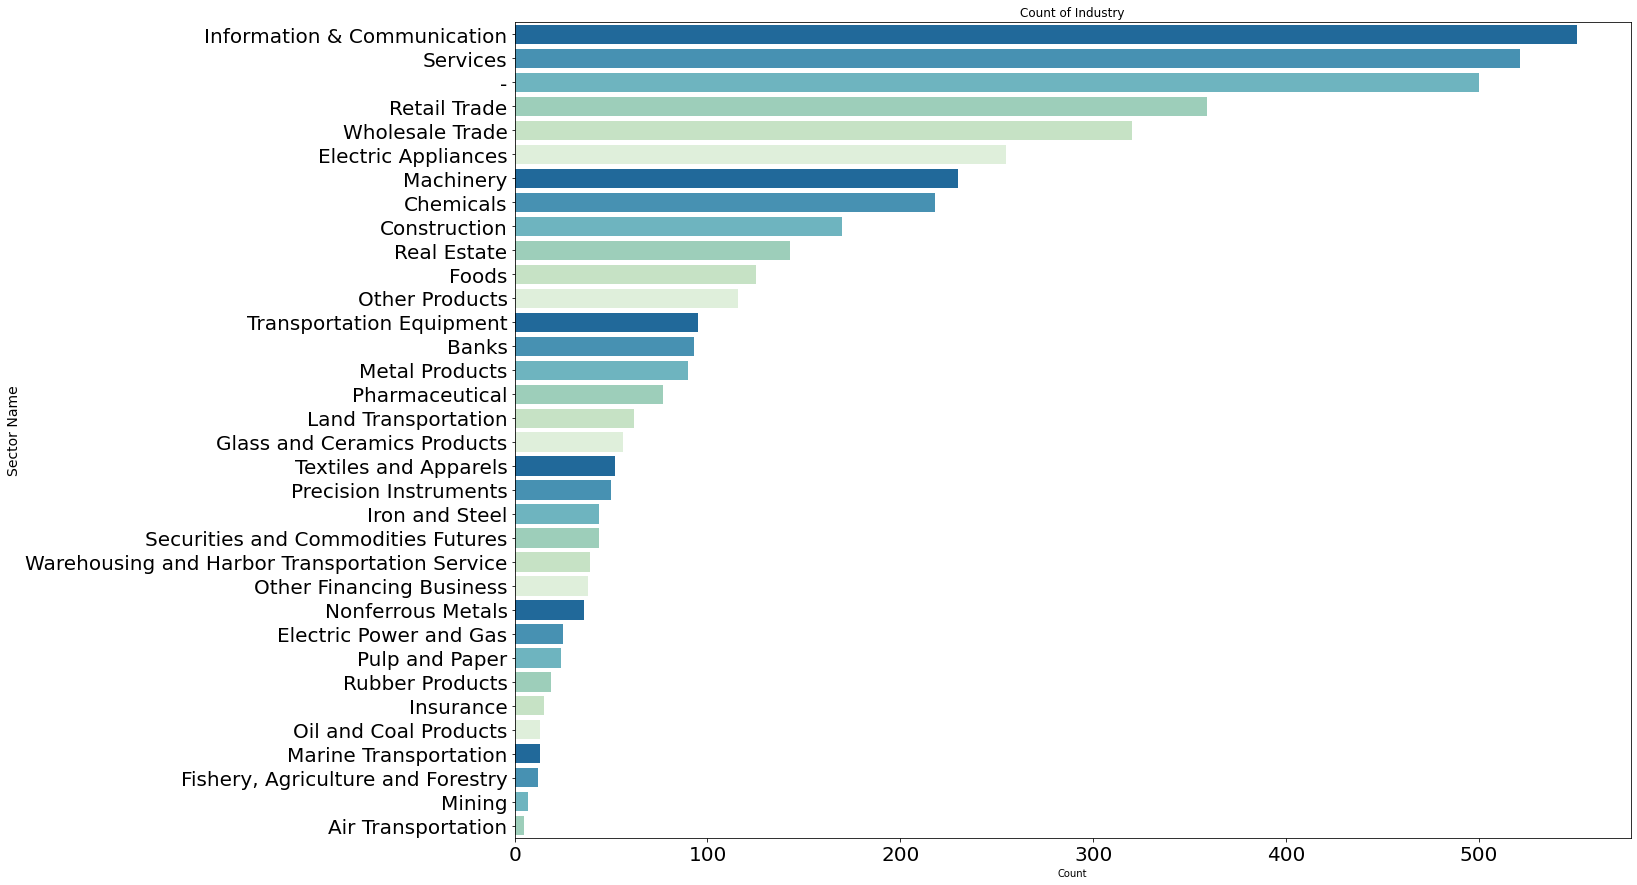

In [55]:
# The number of companies in each industry
temp = df_listings.groupby('33SectorName').count().sort_values('SecuritiesCode', ascending=False)

plt.figure(figsize=(20,15))
sns.barplot(y = temp.index, x = temp['Name'], orient="h",
            palette = sns.color_palette("GnBu_r"))
plt.ylabel('Sector Name', fontsize = 14)
plt.xlabel('Count', fontsize = 10)
plt.title('Count of Industry')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

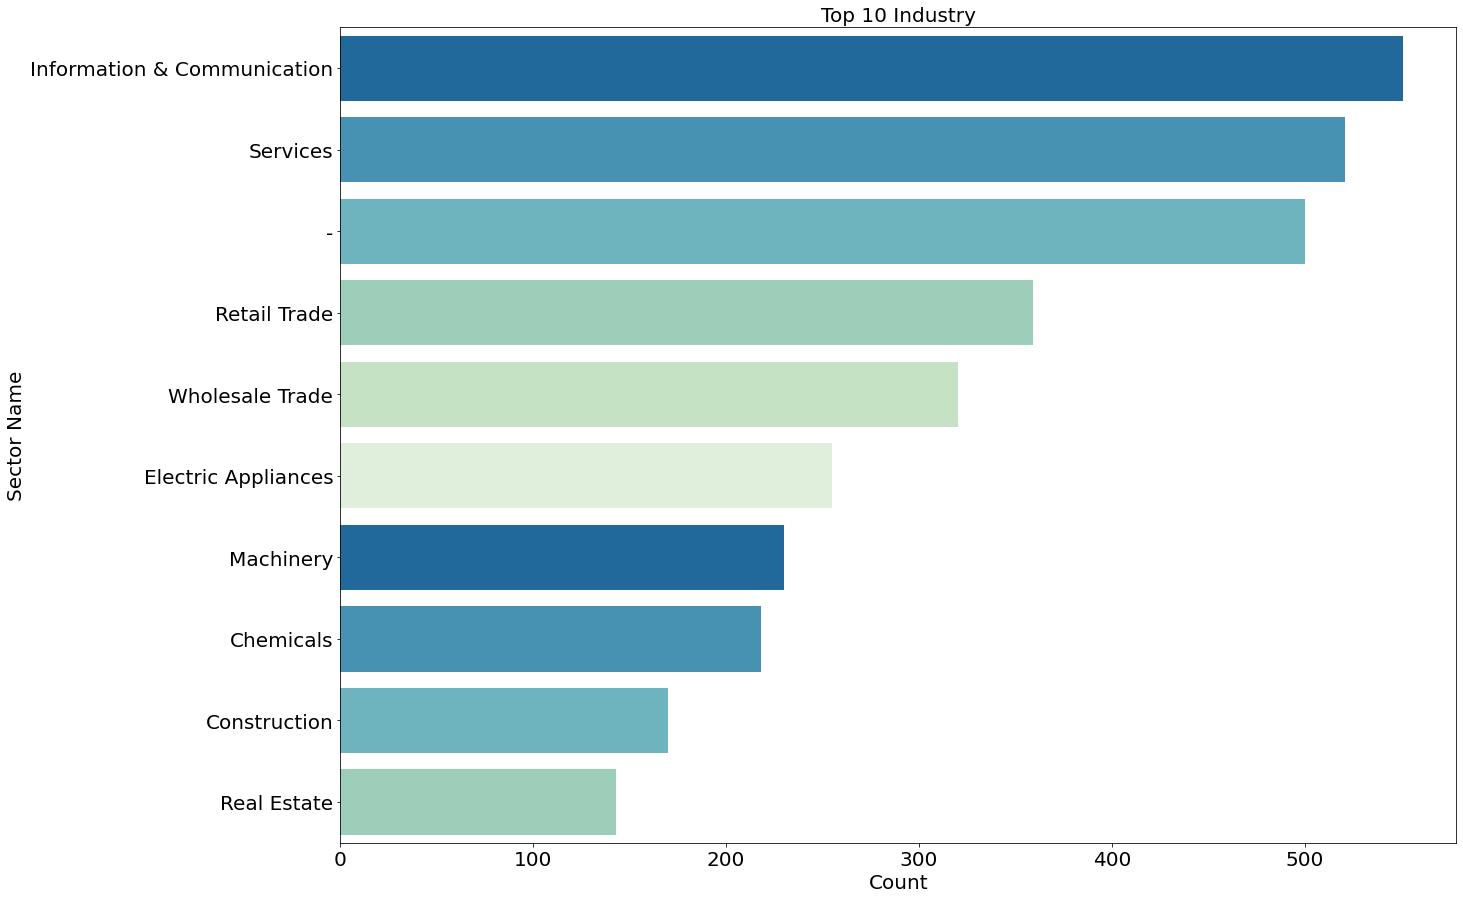

In [56]:
#The top 10 industry intern of nunmber
temp2 = df_listings.groupby('33SectorName').count().sort_values('SecuritiesCode', ascending=False).head(10)

plt.figure(figsize=(20,15))
sns.barplot(y = temp2.index, x = temp2['Name'], orient="h",
            palette = sns.color_palette("GnBu_r"))
plt.ylabel('Sector Name', fontsize = 20)
plt.xlabel('Count', fontsize = 20)
plt.title('Top 10 Industry', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

## Energy Comapny list


In [57]:
def create_df_energy(df_raw=df_listings):
    # Elec & Gas
    df_gas = df_raw[(df_raw["33SectorName"] == "Electric Power and Gas")]
    df_gas.loc[df_gas["Name"].str.contains("Power"), "Category"] = "Electric Utility"
    df_gas.loc[df_gas["Name"].str.contains("GAS"), "Category"] = "Gas Utility"
    df_gas.loc[df_gas["Name"].str.contains("METAWATER"), "Category"] = "Other"
    df_gas["Category"] = df_gas["Category"].fillna("Other Electricity Service")

    # Oil & Coal
    df_oil = df_raw[(df_raw["33SectorName"] == "Oil and Coal Products")]
    oil_company = ["ENEOS Holdings,Inc.", "Idemitsu Kosan Co.,Ltd.", "COSMO ENERGY HOLDINGS COMPANY,LIMITED",
                   "TonenGeneral Sekiyu K.K.", "Fuji Oil Company,Ltd.", "TOA OIL COMPANY,LIMITED"]
    df_oil.loc[df_oil["Name"].isin(oil_company), "Category"] = "Oil"
    df_oil.loc[df_oil["Name"]=="VITEC HOLDINGS CO.,LTD.", "Category"] = "Other"
    df_oil["Category"] = df_oil["Category"].fillna("Oil Products Manufacturer")

    # Merge
    df_energy = pd.concat([df_gas, df_oil], axis=0)

    return df_energy

df_energy = create_df_energy()
df_energy[["SecuritiesCode", "Name", "33SectorName", "Category", "Section/Products"]]

SecuritiesCode                                               Name  \
4181            9501  Tokyo Electric Power Company Holdings,Incorpor...   
4182            9502          Chubu Electric Power Company,Incorporated   
4183            9503     The Kansai Electric Power Company,Incorporated   
4184            9504    The Chugoku Electric Power Company,Incorporated   
4185            9505                    Hokuriku Electric Power Company   
4186            9506         Tohoku Electric Power Company,Incorporated   
4187            9507        Shikoku Electric Power Company,Incorporated   
4188            9508         Kyushu Electric Power Company,Incorporated   
4189            9509       Hokkaido Electric Power Company,Incorporated   
4190            9511    The Okinawa Electric Power Company,Incorporated   
4191            9513                Electric Power Development Co.,Ltd.   
4192            9514                                         EF-ON INC.   
4193            9517                                      eREX Co.,Ltd.   
4194            9519                                        RENOVA,Inc.   
4195            9522                           Renewable Japan Co.,Ltd.   
4196            9531                                 TOKYO GAS CO.,LTD.   
4197            9532                                 OSAKA GAS CO.,LTD.   
4198            9533                                  TOHO GAS CO.,LTD.   
4199            9534                              HOKKAIDO GAS CO.,LTD.   
4200            9535                             HIROSHIMA GAS CO.,LTD.   
4201            9536                        SAIBU GAS HOLDINGS CO.,LTD.   
4202            9537                              HOKURIKU GAS CO.,LTD.   
4203            9539                                 KEIYO GAS CO.,LTD.   
4204            9543                              SHIZUOKA GAS CO.,LTD.   
4205            9551                                 METAWATER Co.,Ltd.   
1044            3315          NIPPON COKE & ENGINEERING COMPANY,LIMITED   
2060            5002                            VITEC HOLDINGS CO.,LTD.   
2061            5008                            TOA OIL COMPANY,LIMITED   
2063            5010                              NIPPON SEIRO CO.,LTD.   
2064            5011                                 NICHIREKI CO.,LTD.   
2065            5012                           TonenGeneral Sekiyu K.K.   
2066            5013                 Yushiro Chemical Industry Co.,Ltd.   
2067            5015                                    BP Castrol K.K.   
2068            5017                              Fuji Oil Company,Ltd.   
2069            5018                                MORESCO Corporation   
2070            5019                            Idemitsu Kosan Co.,Ltd.   
2071            5020                                ENEOS Holdings,Inc.   
2072            5021              COSMO ENERGY HOLDINGS COMPANY,LIMITED   

                33SectorName                   Category  \
4181  Electric Power and Gas           Electric Utility   
4182  Electric Power and Gas           Electric Utility   
4183  Electric Power and Gas           Electric Utility   
4184  Electric Power and Gas           Electric Utility   
4185  Electric Power and Gas           Electric Utility   
4186  Electric Power and Gas           Electric Utility   
4187  Electric Power and Gas           Electric Utility   
4188  Electric Power and Gas           Electric Utility   
4189  Electric Power and Gas           Electric Utility   
4190  Electric Power and Gas           Electric Utility   
4191  Electric Power and Gas           Electric Utility   
4192  Electric Power and Gas  Other Electricity Service   
4193  Electric Power and Gas  Other Electricity Service   
4194  Electric Power and Gas  Other Electricity Service   
4195  Electric Power and Gas  Other Electricity Service   
4196  Electric Power and Gas                Gas Utility   
4197  Electric Power and Gas                Gas Utility   
4198  Electric Pow

In [58]:
df_energy.shape

(38, 17)

## Merge data

In [59]:
# Merge df_stock_price & df_energy
df = pd.merge(
    left=df_stock_price,
    right=df_energy[["SecuritiesCode", "Name", "33SectorName", "Category", "Section/Products"]],
    on="SecuritiesCode", how="left"
    ).dropna(subset=["Name"])
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(df["Date"], drop=True)

In [60]:
# Comapnies not included in stock_price.csv
df_energy[df_energy["Name"].isin(list(set(df_energy["Name"].unique()).difference(set(df["Name"].unique()))))]

SecuritiesCode  EffectiveDate                      Name  \
4192            9514       20211230                EF-ON INC.   
4195            9522       20211230  Renewable Japan Co.,Ltd.   
2060            5002       20000101   VITEC HOLDINGS CO.,LTD.   
2063            5010       20211230     NIPPON SEIRO CO.,LTD.   
2065            5012       20000101  TonenGeneral Sekiyu K.K.   
2069            5018       20211230       MORESCO Corporation   

              Section/Products NewMarketSegment 33SectorCode  \
4192  First Section (Domestic)     Prime Market         4050   
4195        Mothers (Domestic)    Growth Market         4050   
2060  First Section (Domestic)              NaN         3300   
2063  Second Section(Domestic)  Standard Market         3300   
2065  First Section (Domestic)              NaN         3300   
2069  First Section (Domestic)     Prime Market         3300   

                33SectorName 17SectorCode           17SectorName  \
4192  Electric Power and Gas           11  ELECTRIC POWER & GAS    
4195  Electric Power and Gas           11  ELECTRIC POWER & GAS    
2060   Oil and Coal Products            2       ENERGY RESOURCES   
2063   Oil and Coal Products            2      ENERGY RESOURCES    
2065   Oil and Coal Products            2       ENERGY RESOURCES   
2069   Oil and Coal Products            2      ENERGY RESOURCES    

     NewIndexSeriesSizeCode NewIndexSeriesSize   TradeDate   Close  \
4192                      7      TOPIX Small 2  20211230.0   618.0   
4195                      -                  -  20211230.0  1709.0   
2060                      4       TOPIX Mid400         NaN     NaN   
2063                      -                  -  20211230.0   191.0   
2065                      4       TOPIX Mid400         NaN     NaN   
2069                      7      TOPIX Small 2  20211230.0  1161.0   

      IssuedShares  MarketCapitalization  Universe0                   Category  
4192    21636579.0          1.337141e+10      False  Other Electricity Service  
4195    28420910.0          4.857134e+10      False  Other Electricity Service  
2060           NaN                   NaN      False                      Other  
2063    22400000.0          4.278400e+09      False  Oil Products Manufacturer  
2065           NaN                   NaN      False                        Oil  
2069     9696500.0          1.125764e+10      False  Oil Products Manufacturer

## Plots by category

### Elextric Industry

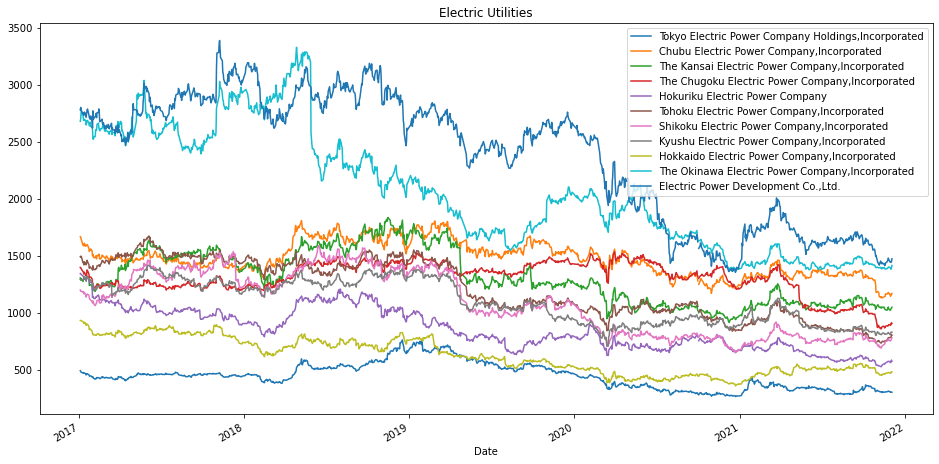

In [61]:
fig, ax = plt.subplots(figsize=(16,8))
for c in df.loc[df["Category"]=="Electric Utility", "Name"].unique():
    df.loc[df["Name"]==c, "Close"].plot(ax=ax, label=c)
ax.legend(loc="upper right")
ax.set_title("Electric Utilities")
plt.show()

### Gas Industry

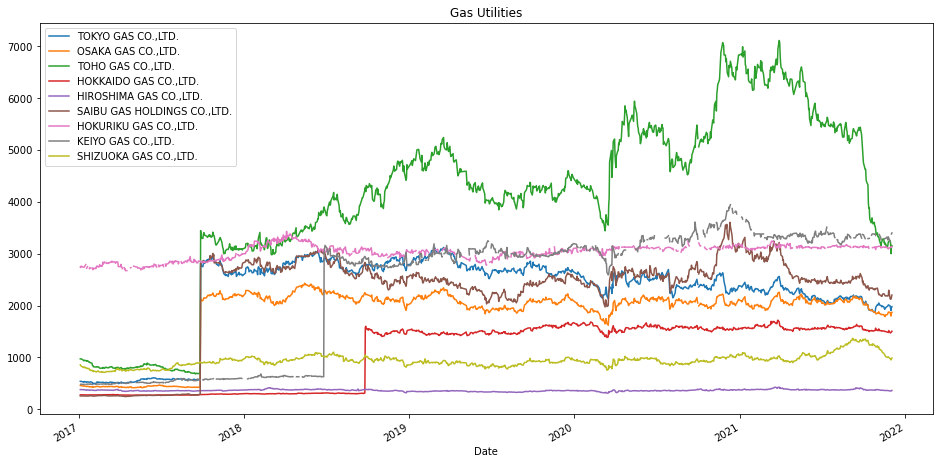

In [62]:
fig, ax = plt.subplots(figsize=(16,8))
for c in df.loc[df["Category"]=="Gas Utility", "Name"].unique():
    df.loc[df["Name"]==c, "Close"].plot(ax=ax, label=c)
ax.legend(loc="upper left")
ax.set_title("Gas Utilities")
plt.show()

### Oil Industry

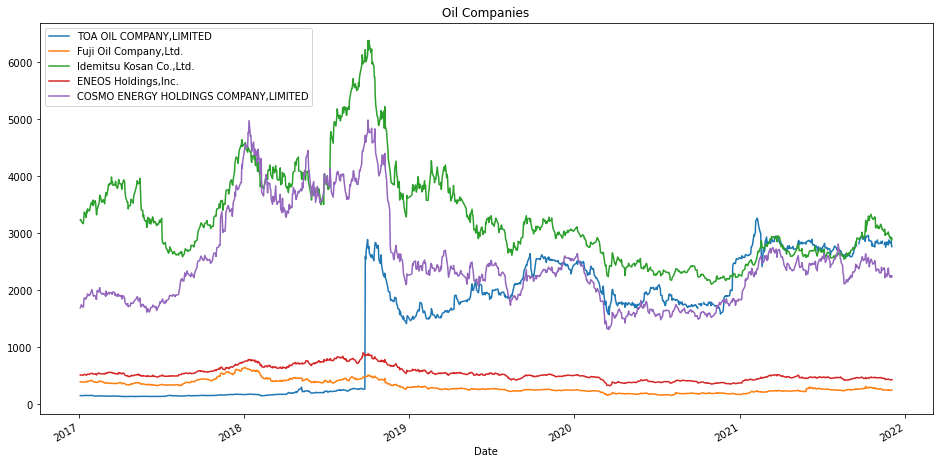

In [63]:
fig, ax = plt.subplots(figsize=(16,8))
for c in df.loc[df["Category"]=="Oil", "Name"].unique():
    df.loc[df["Name"]==c, "Close"].plot(ax=ax, label=c)
ax.legend(loc="upper left")
ax.set_title("Oil Companies")
plt.show()

### Other energy related companies

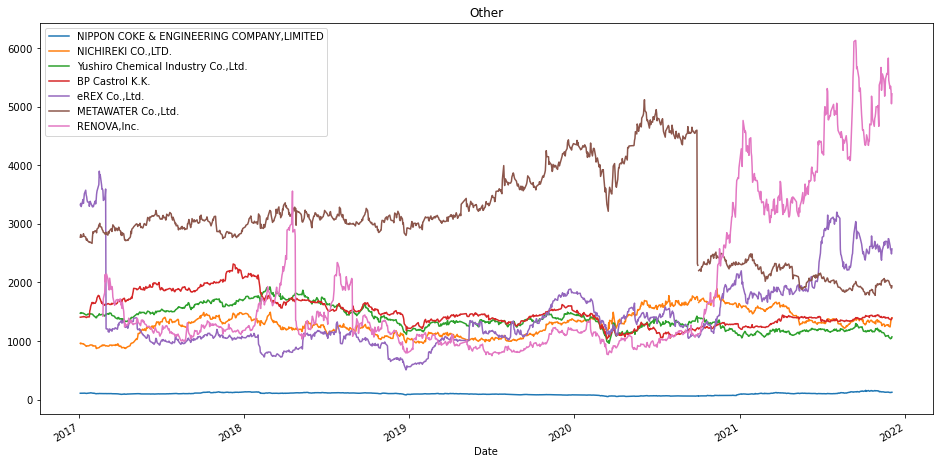

In [64]:
fig, ax = plt.subplots(figsize=(16,8))
for c in df.loc[df["Category"].isin(["Other Electricity Service", "Oil Products Manufacturer", "Other"]), "Name"].unique():
    df.loc[df["Name"]==c, "Close"].plot(ax=ax, label=c)
ax.legend(loc="upper left")
ax.set_title("Other")
plt.show()


## Main 5 Companies
- Eneos: Largest oil wholesaler in Japan
- Tokyo/Kansai Electric Power: Largest & Second largest electric utility in Japan (Tokyo and Osaka area)
- Tokyo/Osaka Gas: Largest & Second largest gas utility in Japan (Tokyo and Osaka area)

In [65]:
main5 = df.copy().loc[df["SecuritiesCode"].isin([9501, 9503, 9531, 9532, 5020]), ["Date", "SecuritiesCode", "Close", "Name", "Category"]]
main5.loc[main5["Name"]=="ENEOS Holdings,Inc.", "Name"] = "ENEOS"
main5.loc[main5["Name"]=="Tokyo Electric Power Company Holdings,Incorporated", "Name"] = "Tokyo Electric Power"
main5.loc[main5["Name"]=="The Kansai Electric Power Company,Incorporated", "Name"] = "Kansai Electric Power"
main5.loc[main5["Name"]=="TOKYO GAS CO.,LTD.", "Name"] = "Tokyo Gas"
main5.loc[main5["Name"]=="OSAKA GAS CO.,LTD.", "Name"] = "Osaka Gas"

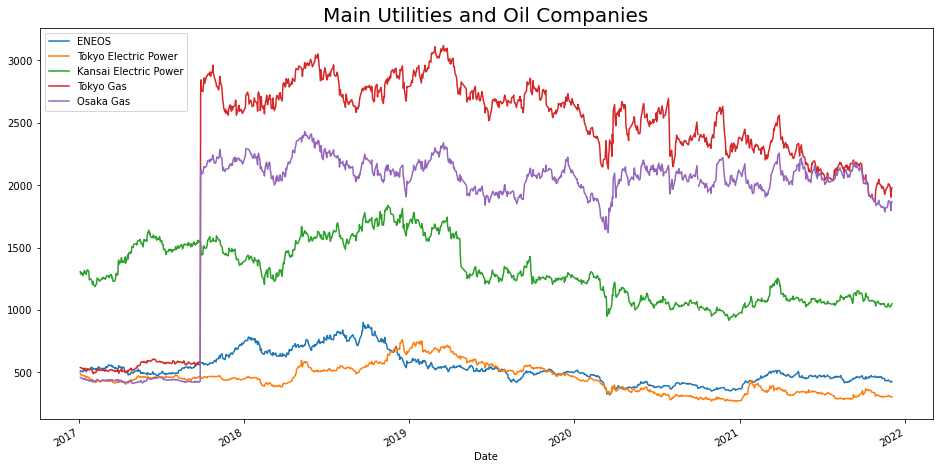

In [66]:
fig, ax = plt.subplots(figsize=(16,8))
for c in main5["Name"].unique():
    main5.loc[main5["Name"]==c, "Close"].plot(ax=ax, label=c)
ax.legend(loc="upper left")
ax.set_title("Main Utilities and Oil Companies", fontsize = 20)
plt.show()

In [67]:
# Tokyo Gas & Osaka Gas change unit of stocks from 9/27/2017 (5 shares to 1 share)
main5.loc[(main5["SecuritiesCode"].isin([9531, 9532])) & (main5.index.year==2017) & (main5.index.month==9) & (main5.index.day>20)].sort_values("SecuritiesCode")


Date  SecuritiesCode   Close       Name     Category
Date                                                                 
2017-09-21 2017-09-21            9531   564.7  Tokyo Gas  Gas Utility
2017-09-22 2017-09-22            9531   567.7  Tokyo Gas  Gas Utility
2017-09-25 2017-09-25            9531   560.1  Tokyo Gas  Gas Utility
2017-09-26 2017-09-26            9531   564.4  Tokyo Gas  Gas Utility
2017-09-27 2017-09-27            9531  2763.0  Tokyo Gas  Gas Utility
2017-09-28 2017-09-28            9531  2844.0  Tokyo Gas  Gas Utility
2017-09-29 2017-09-29            9531  2758.0  Tokyo Gas  Gas Utility
2017-09-21 2017-09-21            9532   420.4  Osaka Gas  Gas Utility
2017-09-22 2017-09-22            9532   422.1  Osaka Gas  Gas Utility
2017-09-25 2017-09-25            9532   425.2  Osaka Gas  Gas Utility
2017-09-26 2017-09-26            9532   429.8  Osaka Gas  Gas Utility
2017-09-27 2017-09-27            9532  2094.5  Osaka Gas  Gas Utility
2017-09-28 2017-09-28            9532  2123.0  Osaka Gas  Gas Utility
2017-09-29 2017-09-29            9532  2092.0  Osaka Gas  Gas Utility

In [68]:
main5["Adjusted Close"] = main5["Close"]
main5.loc[(main5["SecuritiesCode"].isin([9531, 9532])) & (main5["Date"] < dt.datetime(2017,9,27)), "Adjusted Close"] = main5.loc[(main5["SecuritiesCode"].isin([9531, 9532])) & (main5["Date"] < dt.datetime(2017,9,27)), "Adjusted Close"]*5


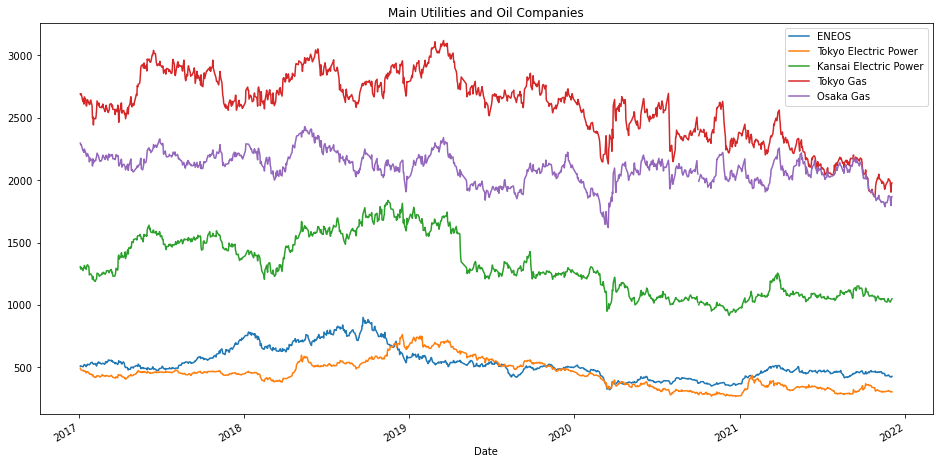

In [69]:
fig, ax = plt.subplots(figsize=(16,8))
for c in main5["Name"].unique():
    main5.loc[main5["Name"]==c, "Adjusted Close"].plot(ax=ax, label=c)
ax.legend(loc="upper right")
ax.set_title("Main Utilities and Oil Companies")
plt.show()

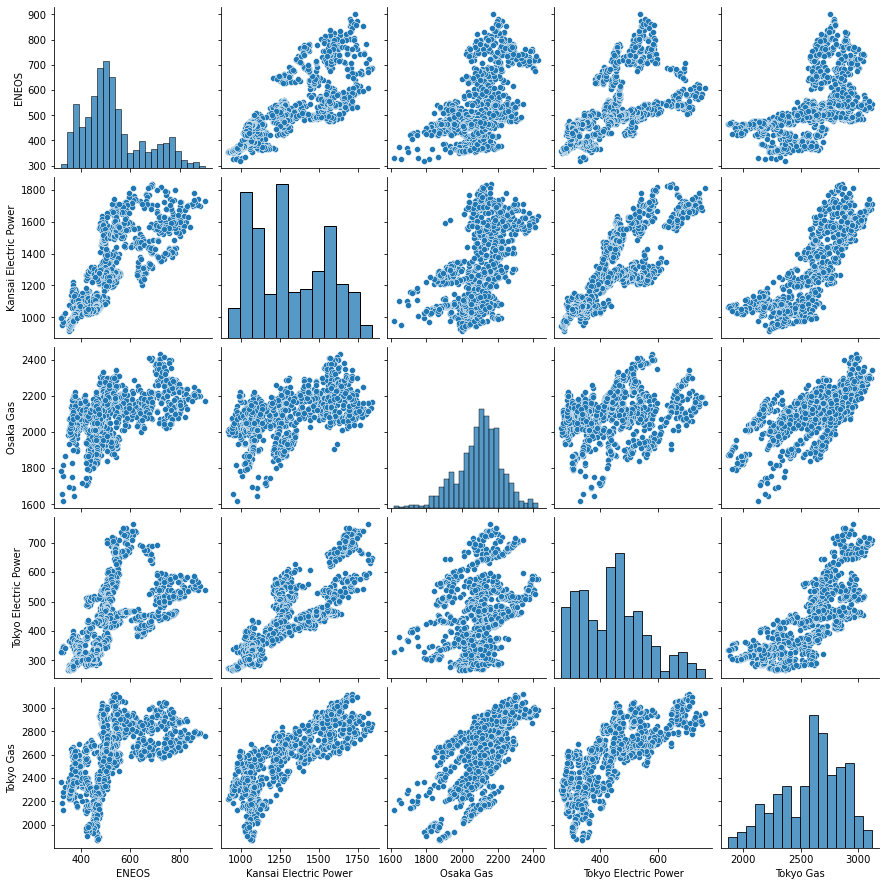

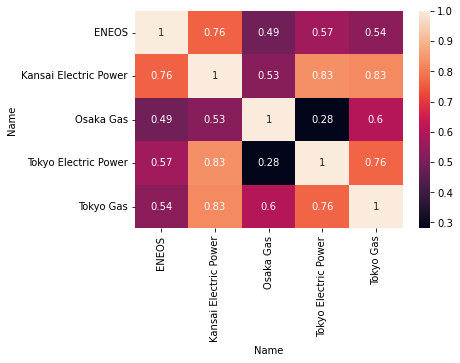

In [70]:
# See correlation
main5_corr = main5.copy()
main5_corr = main5_corr.pivot(index=["Date"], columns="Name", values="Adjusted Close")
sns.pairplot(main5_corr)
plt.show()
sns.heatmap(main5_corr.corr(), annot=True)
plt.show()


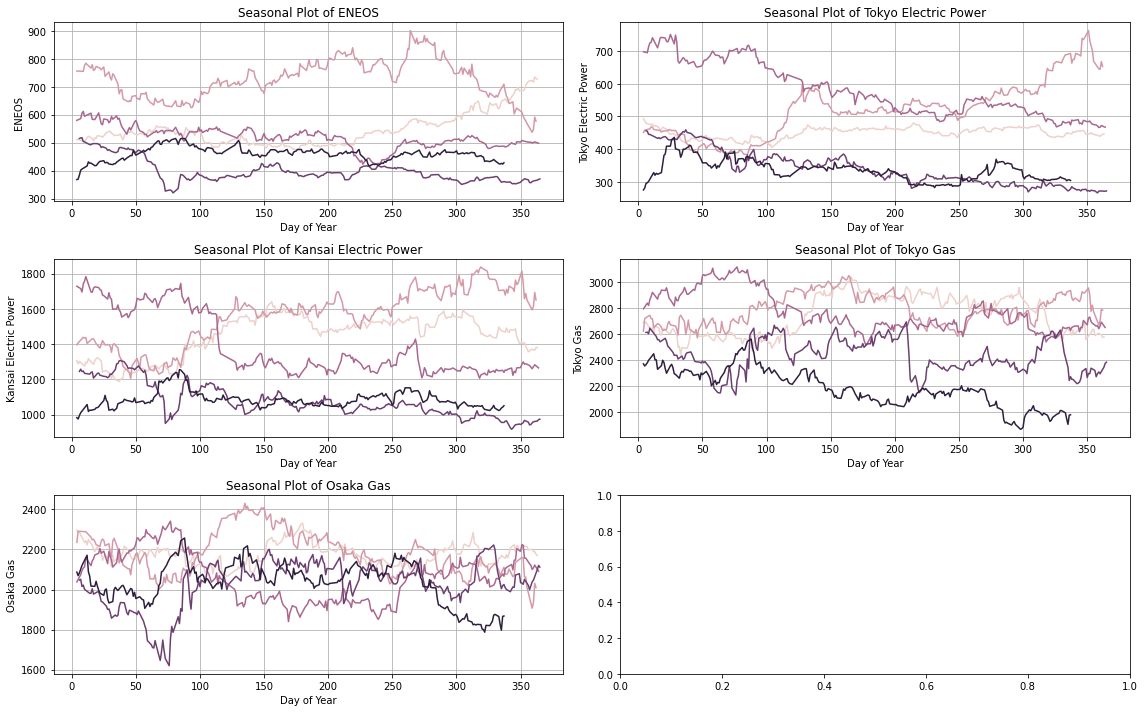

In [71]:
# Function to create plot to see seasonality
def check_seasonality(timeseries, title, ax=None):
    df = pd.DataFrame(timeseries)
    df.columns = ["price"]
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear

    if ax==None:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.lineplot("dayofyear", "price", data=df, hue="year", ax=ax, legend=None)
        ax.set_title(f"Seasonal Plot of {title}")
        ax.set_xlabel("Day of Year")
        ax.set_ylabel(title)
        ax.grid()
        plt.show()
    else:
        sns.lineplot("dayofyear", "price", data=df, hue="year", ax=ax, legend=None)
        ax.set_title(f"Seasonal Plot of {title}")
        ax.set_xlabel("Day of Year")
        ax.set_ylabel(title)
        ax.grid()
        return ax

# Check seasonality for main 5 companies => Seem no seasonality
fig, axes = plt.subplots(3,2, figsize=(16,10), tight_layout=True)
axes_flat = [s for sublist in axes for s in sublist]
for i, name in enumerate(main5["Name"].unique()):
    check_seasonality(main5.loc[main5["Name"]==name, "Adjusted Close"], name, ax=axes_flat[i])
plt.show()

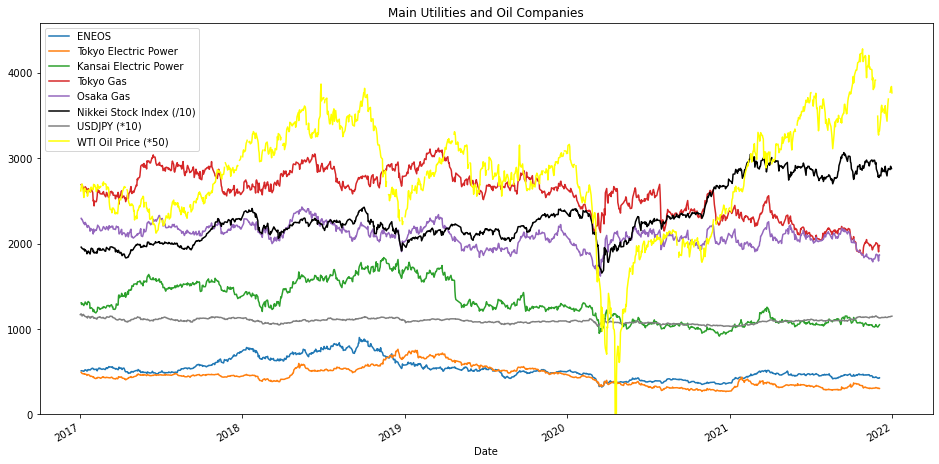

In [72]:
fig, ax = plt.subplots(figsize=(16,8))
for c in main5["Name"].unique():
    main5.loc[main5["Name"]==c, "Adjusted Close"].plot(ax=ax, label=c)
ax.set_title("Main Utilities and Oil Companies")
ax.plot(n225["n225"]/10, color="Black", label="Nikkei Stock Index (/10)")
ax.plot(usdjpy["usdjpy"]*10, color="grey", label="USDJPY (*10)")
ax.plot(oil["oil"]*50, color="yellow", label="WTI Oil Price (*50)")
ax.legend(loc="upper left")
ax.set_ylim(0,)
plt.show()

# ARIMA Models(Tokyo Gas)
- Training: 2017-2020
- Test: 2021
- Original series: Not stationary
- First order differencing: Stationary

## Daily Analysis ARIMA(1 Year Prediction)

In [109]:
tokyo_gas = main5.loc[main5["Name"]=="Tokyo Gas", "Adjusted Close"]
tokyo_gas = tokyo_gas.dropna()
tokyo_gas.name = "Tokyo Gas"

### Univariate ARIMA

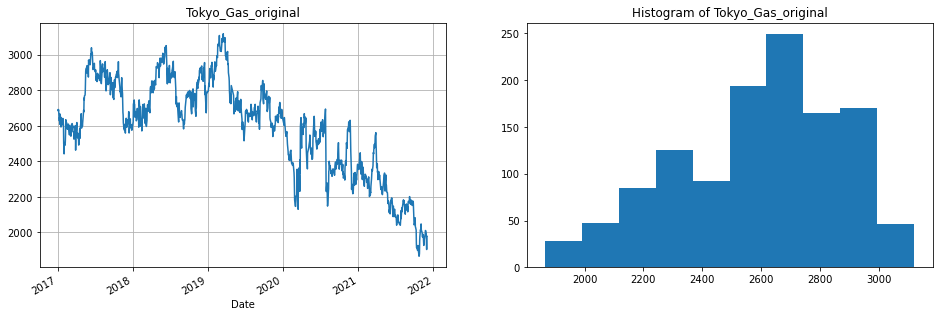


ADF/KPSS tests for Tokyo_Gas_original (alpha=0.05):
stationarity from ADF test: False
stationarity from KPSS test('c'): False
stationarity from KPSS test('ct'): False



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.201363   3.438455    0.722794
p-value               0.673009   0.010000    0.010000
Lags Used             9.000000  23.000000   23.000000
Critical Value (1%)  -3.435852   0.739000    0.216000
Critical Value (5%)  -2.863970   0.463000    0.146000
Critical Value (10%) -2.568064   0.347000    0.119000

In [110]:
# Check stationarity
create_plot_adf_kpss(tokyo_gas, "Tokyo_Gas_original")

In [116]:
# Take first difference
tokyo_gas_diff = tokyo_gas.diff().dropna()

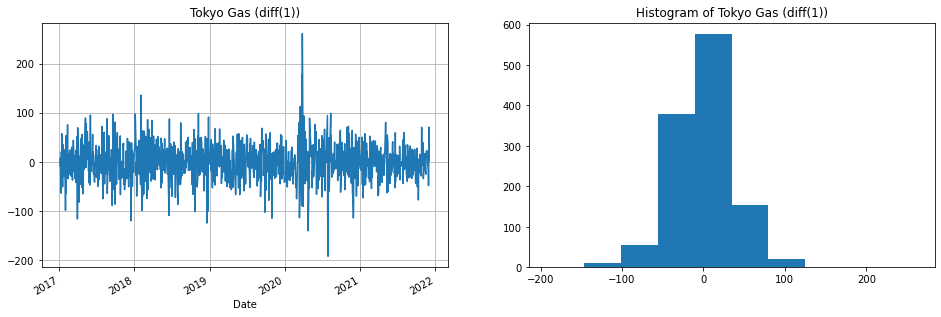


ADF/KPSS tests for Tokyo Gas (diff(1)) (alpha=0.05):
stationarity from ADF test: True
stationarity from KPSS test('c'): True
stationarity from KPSS test('ct'): True



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.315887e+01   0.089789      0.0155
p-value               1.319894e-24   0.100000      0.1000
Lags Used             8.000000e+00  23.000000     23.0000
Critical Value (1%)  -3.435852e+00   0.739000      0.2160
Critical Value (5%)  -2.863970e+00   0.463000      0.1460
Critical Value (10%) -2.568064e+00   0.347000      0.1190

In [115]:
# Check stationarity
create_plot_adf_kpss(tokyo_gas_diff, "Tokyo Gas (diff(1))")

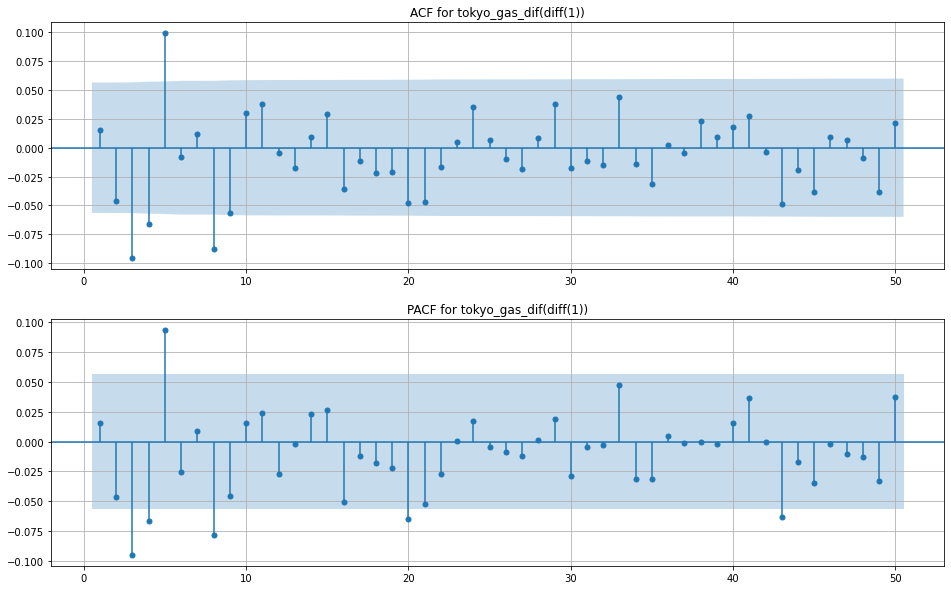

In [125]:
plot_acf_pacf(tokyo_gas_diff, "tokyo_gas_dif(diff(1))", lags=50)

In [78]:
# Using data before 2020 as training
y_train = tokyo_gas[tokyo_gas.index.year!=2021]
y_test = tokyo_gas[tokyo_gas.index.year==2021]

In [79]:
arima_model = auto_arima(y_train, start_p=0, d=1, start_q=0, seasonal=False)
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  975
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -4942.886
Date:                Wed, 05 Oct 2022   AIC                           9897.771
Time:                        16:54:34   BIC                           9927.060
Sample:                             0   HQIC                          9908.917
                                - 975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7169      0.103     -6.935      0.000      -0.920      -0.514
ar.L2         -0.0480      0.029     -1.646      0.100      -0.105       0.009
ar.L3         -0.1299      0.034     -3.864      0.0

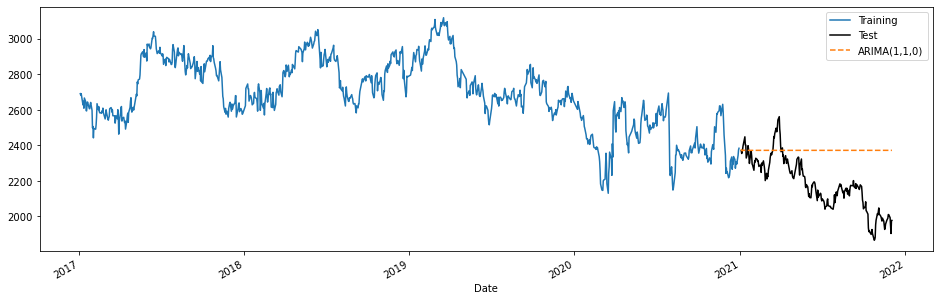

In [80]:
y_pred_arima110 = arima_model.predict(len(y_test))
y_pred_arima110 = pd.Series(y_pred_arima110)
y_pred_arima110.index = y_test.index
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_arima110.plot(ax=ax, label="ARIMA(1,1,0)", linestyle="dashed")
plt.legend()
plt.show()

In [81]:
arima110_metrics = calc_metrics(y_test, y_pred_arima110, return_dict=True)

Test Error Metrics
MAE: 203.792
MSE: 58725.0992
MAPE: 0.0978
sMAPE: 0.0914
MASE: -8.7564


### Multivariate ARIMAX

In [82]:
# Merge data and fill NAs with interpolation
tokyo_gas_m = pd.concat([tokyo_gas, oil_s, n225_s], axis=1)
tokyo_gas_m = tokyo_gas_m.dropna(subset=["Tokyo Gas"])
tokyo_gas_m["oil"] = tokyo_gas_m["oil"].interpolate()
tokyo_gas_m["n225"] = tokyo_gas_m["n225"].interpolate()
tokyo_gas_m

Tokyo Gas    oil          n225
Date                                      
2017-01-04     2691.5  53.26  19594.160156
2017-01-05     2683.5  53.77  19520.689453
2017-01-06     2691.5  53.98  19454.330078
2017-01-10     2628.0  50.82  19301.439453
2017-01-11     2648.5  52.19  19364.669922
...               ...    ...           ...
2021-11-29     1993.0  69.88  28283.919922
2021-11-30     1945.0  66.14  27821.759766
2021-12-01     1904.0  65.44  27935.619141
2021-12-02     1975.0  66.60  27753.369141
2021-12-03     1978.0  66.39  28029.570312

[1201 rows x 3 columns]

#### With Oil Regressor

In [83]:
# Using data before 2020 as training
X_train_oil = tokyo_gas_m.loc[tokyo_gas_m.index.year!=2021, "oil"]
X_test_oil = tokyo_gas_m.loc[tokyo_gas_m.index.year==2021, "oil"]

In [84]:
arimax_oil = auto_arima(y_train, X=X_train_oil.values.reshape(-1, 1), start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_oil.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  975
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -4942.464
Date:                Wed, 05 Oct 2022   AIC                           9898.927
Time:                        16:55:29   BIC                           9933.097
Sample:                             0   HQIC                          9911.931
                                - 975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4327      0.776      0.558      0.577      -1.088       1.953
ar.L1         -0.7055      0.109     -6.459      0.000      -0.920      -0.491
ar.L2         -0.0480      0.029     -1.655      0.0

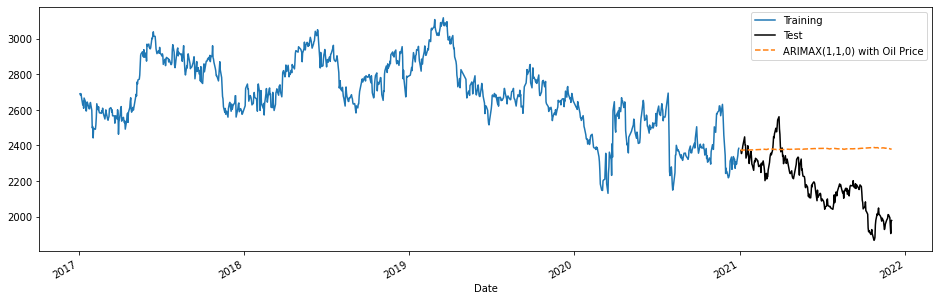

In [ ]:
y_pred_arimax110_oil = arimax_oil.predict(len(y_test), X=X_test_oil.values.reshape(-1, 1))
y_pred_arimax110_oil = pd.Series(y_pred_arimax110_oil)
y_pred_arimax110_oil.index = y_test.index
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_arimax110_oil.plot(ax=ax, label="ARIMAX(1,1,0) with Oil Price", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
arima110_oil_metrics = calc_metrics(y_test, y_pred_arimax110_oil, return_dict=True)

Test Error Metrics
MAE: 211.5135
MSE: 63002.5703
MAPE: 0.1015
sMAPE: 0.0946
MASE: -9.0882


#### With NIKKEI225 Regressor

In [ ]:
# Using data before 2020 as training
X_train_n225 = tokyo_gas_m.loc[tokyo_gas_m.index.year!=2021, "n225"]
X_test_n225 = tokyo_gas_m.loc[tokyo_gas_m.index.year==2021, "n225"]

In [ ]:
arimax_n225 = auto_arima(y_train, X=X_train_n225.values.reshape(-1, 1), start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_n225.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  975
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4876.087
Date:                Thu, 02 Jun 2022   AIC                           9756.175
Time:                        22:06:01   BIC                           9765.938
Sample:                             0   HQIC                          9759.890
                                - 975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0627      0.003     19.136      0.000       0.056       0.069
sigma2      1305.8502     37.170     35.132      0.000    1232.999    1378.701
Ljung-Box (L1) (Q):                   0.60   Jarque-

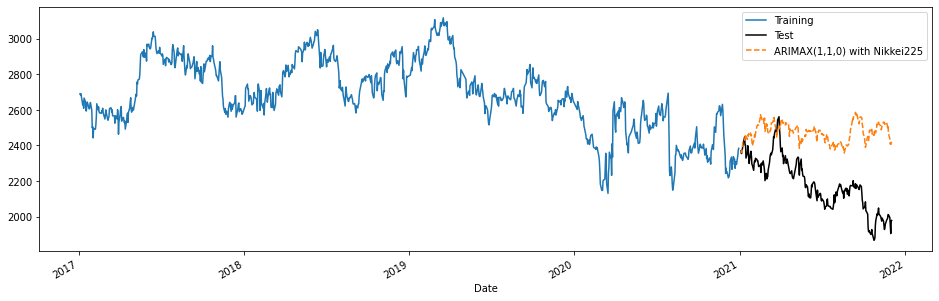

In [ ]:
y_pred_arimax110_n225 = arimax_n225.predict(len(y_test), X=X_test_n225.values.reshape(-1, 1))
y_pred_arimax110_n225 = pd.Series(y_pred_arimax110_n225)
y_pred_arimax110_n225.index = y_test.index
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_arimax110_n225.plot(ax=ax, label="ARIMAX(1,1,0) with Nikkei225", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
arima110_n225_metrics = calc_metrics(y_test, y_pred_arimax110_n225, return_dict=True)

Test Error Metrics
MAE: 292.0734
MSE: 107173.8052
MAPE: 0.1389
sMAPE: 0.1274
MASE: -12.5497


#### Oil & Nikkei

In [ ]:
# Using data before 2020 as training
X_train_oiln225 = tokyo_gas_m.loc[tokyo_gas_m.index.year!=2021, ["oil", "n225"]]
X_test_oiln225 = tokyo_gas_m.loc[tokyo_gas_m.index.year==2021, ["oil", "n225"]]

In [ ]:
arimax_oiln225 = auto_arima(y_train, X=X_train_oiln225, start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_oiln225.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  975
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4875.807
Date:                Thu, 02 Jun 2022   AIC                           9757.613
Time:                        22:06:03   BIC                           9772.258
Sample:                             0   HQIC                          9763.186
                                - 975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
oil            0.3317      0.626      0.530      0.596      -0.895       1.559
n225           0.0625      0.003     19.055      0.000       0.056       0.069
sigma2      1305.1005     37.129     35.150      0.0

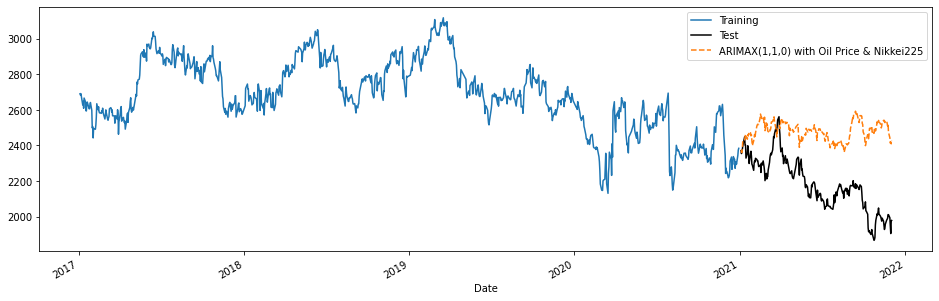

In [ ]:
y_pred_arimax110_oiln225 = arimax_oiln225.predict(len(y_test), X=X_test_oiln225)
y_pred_arimax110_oiln225 = pd.Series(y_pred_arimax110_oiln225)
y_pred_arimax110_oiln225.index = y_test.index
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_arimax110_oiln225.plot(ax=ax, label="ARIMAX(1,1,0) with Oil Price & Nikkei225", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
arima110_oiln225_metrics = calc_metrics(y_test, y_pred_arimax110_oiln225, return_dict=True)

Test Error Metrics
MAE: 298.0109
MSE: 111508.5736
MAPE: 0.1417
sMAPE: 0.1298
MASE: -12.8048


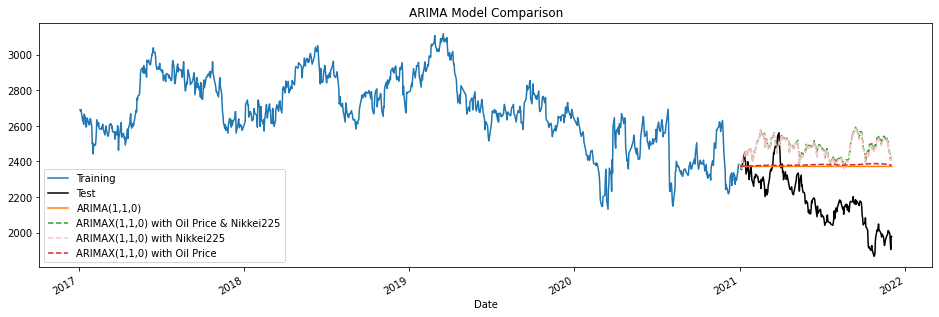

In [ ]:
y_pred_arimax110_oiln225 = arimax_oiln225.predict(len(y_test), X=X_test_oiln225)
y_pred_arimax110_oiln225 = pd.Series(y_pred_arimax110_oiln225)
y_pred_arimax110_oiln225.index = y_test.index
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_arima110.plot(ax=ax, label="ARIMA(1,1,0)", linestyle="solid")
y_pred_arimax110_oiln225.plot(ax=ax, label="ARIMAX(1,1,0) with Oil Price & Nikkei225", linestyle="dashed")
y_pred_arimax110_n225.plot(ax=ax, label="ARIMAX(1,1,0) with Nikkei225", linestyle="dashed", color = 'pink')
y_pred_arimax110_oil.plot(ax=ax, label="ARIMAX(1,1,0) with Oil Price", linestyle="dashed")
ax.set_title("ARIMA Model Comparison")
plt.legend()
plt.show()

## Weekly Analysis ARIMA (6 Monthes Prediction)

### Pre-processing & stationarity check for weekly data
- Original sereies is non-stationary / differenced series is stationary.
- There's no seasonality in the series.
- ACF/PACF indicates ARIMA(1,1,0) or ARIMA(0,1,1).

In [85]:
# Take average of each week
tokyo_gas_weekly = tokyo_gas.resample("W").mean()
# Fill NA with interpolation
tokyo_gas_weekly = tokyo_gas_weekly.interpolate()

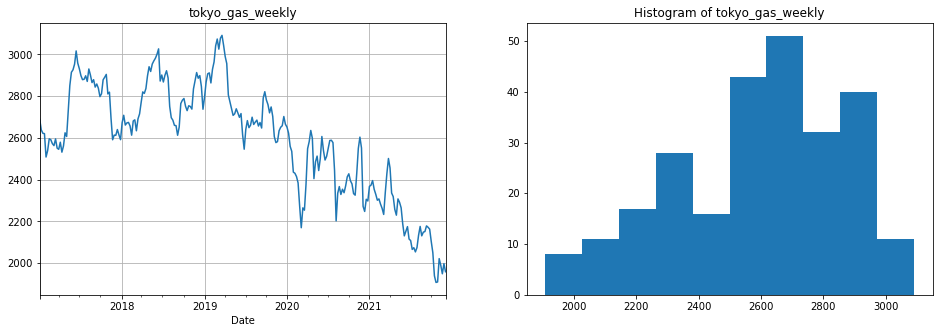


ADF/KPSS tests for tokyo_gas_weekly (alpha=0.05):
stationarity from ADF test: False
stationarity from KPSS test('c'): False
stationarity from KPSS test('ct'): False



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -0.666585   1.195419    0.302181
p-value               0.855216   0.010000    0.010000
Lags Used             4.000000  16.000000   16.000000
Critical Value (1%)  -3.456569   0.739000    0.216000
Critical Value (5%)  -2.873079   0.463000    0.146000
Critical Value (10%) -2.572919   0.347000    0.119000

In [86]:
# Check stationarity
create_plot_adf_kpss(tokyo_gas_weekly, "tokyo_gas_weekly")

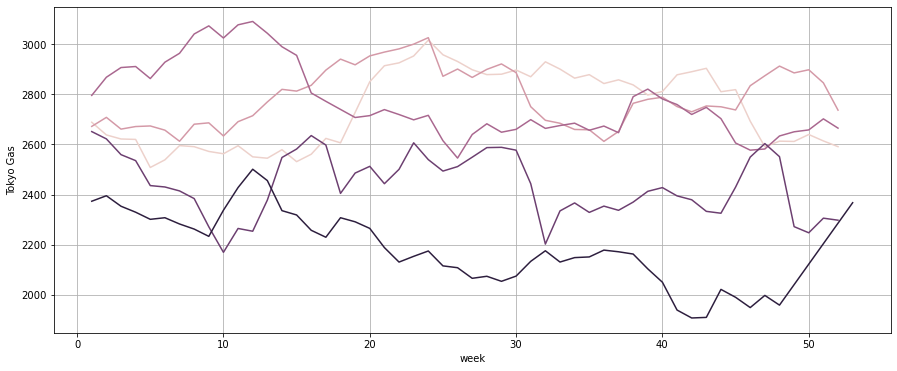

In [87]:
# Check seasonality: No seasonality
df_season = pd.DataFrame(tokyo_gas_weekly)
df_season["year"] = df_season.index.year
df_season["week"] = df_season.index.week

# Line plot
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot("week", "Tokyo Gas", data=df_season, hue="year", ax=ax, legend=None)
ax.grid()
plt.show()

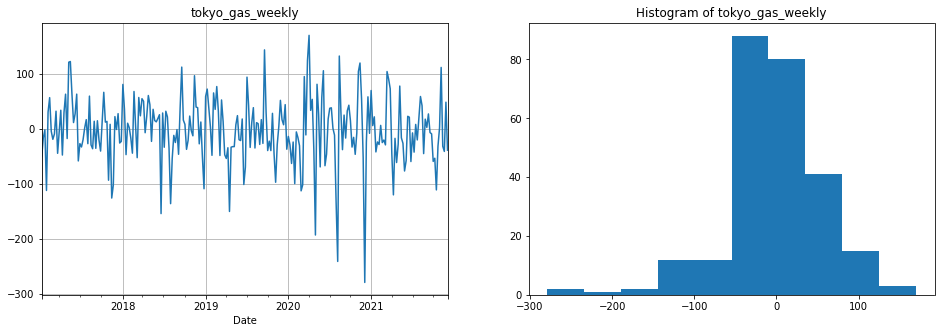


ADF/KPSS tests for tokyo_gas_weekly (alpha=0.05):
stationarity from ADF test: True
stationarity from KPSS test('c'): True
stationarity from KPSS test('ct'): True



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -9.766553e+00   0.161865    0.026794
p-value               7.323609e-17   0.100000    0.100000
Lags Used             3.000000e+00  16.000000   16.000000
Critical Value (1%)  -3.456569e+00   0.739000    0.216000
Critical Value (5%)  -2.873079e+00   0.463000    0.146000
Critical Value (10%) -2.572919e+00   0.347000    0.119000

In [88]:
# Check stationarity for differenced data
create_plot_adf_kpss(tokyo_gas_weekly.diff().dropna(), "tokyo_gas_weekly")

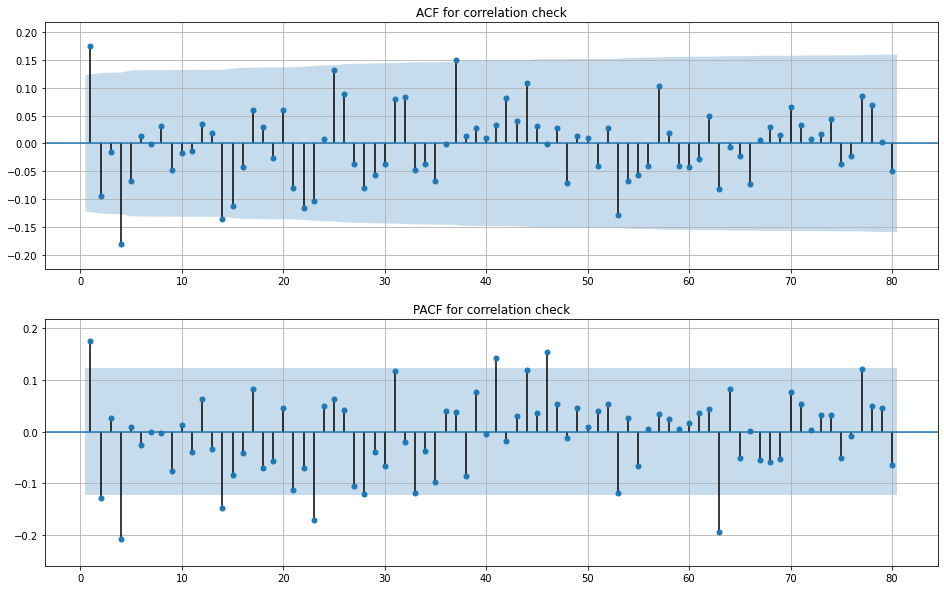

In [ ]:
plot_acf_pacf(tokyo_gas_weekly.diff().dropna(), title = 'correlation check', lags=80)

### Pre-processing for external regressors
-  GDP (quarterly), unemployment rate (monthly): Forward fill
- Interest rate / Nikkei 225: interpolate for 2019-05-05 (same as eneos)


In [ ]:
# GDP
gdp_weekly = gdp_s.resample("W").mean().fillna(method="ffill")

In [ ]:
# unemplyment rate
unemp_weekly = unemp_s.resample("W").mean().fillna(method="ffill")

In [ ]:
# Oil Price
oil_weekly = oil_s.resample("W").mean()

In [ ]:
# JPY/USD
usdjpy_weekly = usdjpy_s.resample("W").mean()

In [ ]:
# Interest Rate (long-term)
interest_weekly = interest_s.resample("W").mean()

In [ ]:
# Find NAs for interest_weekly
interest_weekly[interest_weekly.isna()]

Date
2019-05-05   NaN
Freq: W-SUN, Name: jp_i, dtype: float64

In [ ]:
# Interpolation
interest_weekly = interest_weekly.interpolate()

In [ ]:
# Nikkei 225 index
n225_weekly = n225_s.resample("W").mean()

In [ ]:
# Find NAs
n225_weekly[n225_weekly.isna()]

Date
2019-05-05   NaN
Freq: W-SUN, Name: n225, dtype: float64

In [ ]:
# Interpolation
n225_weekly = n225_weekly.interpolate()

In [ ]:
# Merge data
weekly_m = pd.concat([tokyo_gas_weekly, gdp_weekly, unemp_weekly, oil_weekly, usdjpy_weekly, interest_weekly, n225_weekly], axis=1)

# Show rows with NAs => Need to fill jp_gdp (since last observation for gdp_weekly is for 2021-10-03)
weekly_m[weekly_m.isnull().any(axis=1)]

Tokyo Gas    jp_gdp  jp_unemp        oil      usdjpy     jp_i  \
Date                                                                        
2017-01-01        NaN  547306.2       3.1        NaN         NaN      NaN   
2021-10-10    2050.30       NaN       2.8  78.504000  111.295401  0.07200   
2021-10-17    1939.30       NaN       2.8  81.176000  113.262399  0.08740   
2021-10-24    1907.70       NaN       2.8  83.476000  114.278200  0.09280   
2021-10-31    1910.00       NaN       2.8  83.844000  113.801801  0.09940   
2021-11-07    2021.75       NaN       2.9  81.788000  114.039799  0.08300   
2021-11-14    1990.20       NaN       2.9  81.930000  113.517799  0.06840   
2021-11-21    1949.20       NaN       2.9  78.992000  114.297801  0.08020   
2021-11-28    1997.75       NaN       2.9  77.793333  114.909200  0.08475   
2021-12-05    1959.00       NaN       2.8  66.890000  113.345203  0.06980   
2021-12-12        NaN       NaN       NaN  71.314000  113.431400  0.05800   
2021-12-19        NaN       NaN       NaN  71.184000  113.724001  0.05820   
2021-12-26        NaN       NaN       NaN  71.625000  113.950601  0.06920   
2022-01-02        NaN       NaN       NaN  76.048000  114.781801  0.07950   

                    n225  
Date                      
2017-01-01           NaN  
2021-10-10  27904.605859  
2021-10-17  28497.729687  
2021-10-24  29001.992188  
2021-10-31  28903.487891  
2021-11-07  29643.479980  
2021-11-14  29357.424219  
2021-11-21  29723.555859  
2021-11-28  29331.916992  
2021-12-05  27964.847656  
2021-12-12  28481.365625  
2021-12-19  28628.970313  
2021-12-26  28519.714062  
2022-01-02  28861.053223

In [ ]:
# Drop rows when "Tokyo Gas" is NA 
weekly_m = weekly_m.dropna(subset=["Tokyo Gas"])
# Fill NAs for jp_gdp with forward fill
weekly_m["jp_gdp"] = weekly_m["jp_gdp"].fillna(method="ffill")

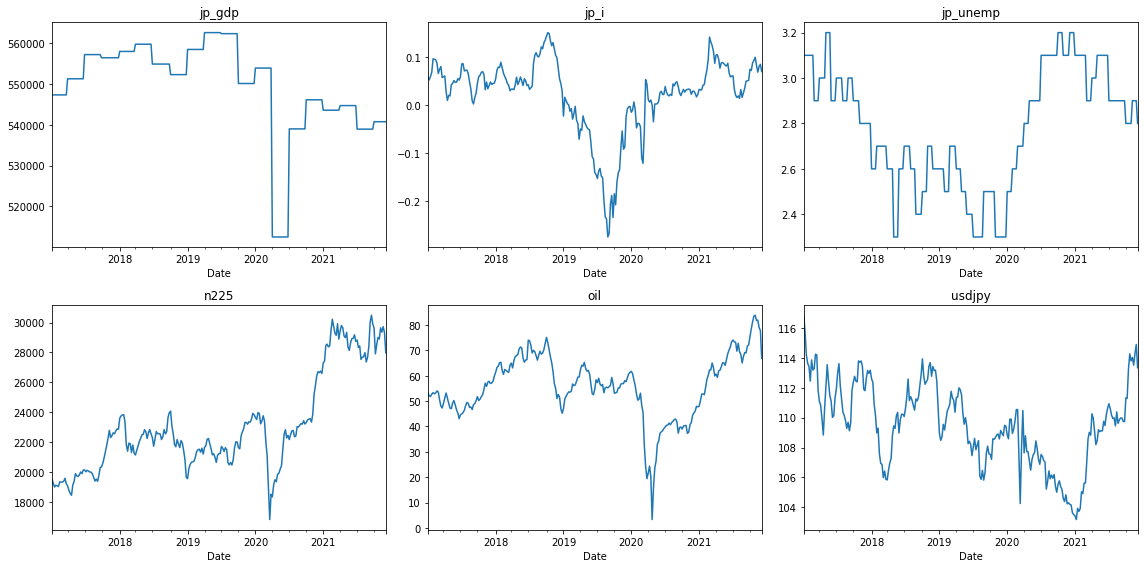

In [ ]:
# Plot external regressors
fig, axes = plt.subplots(2,3, figsize=(16,8), tight_layout=True)
axes_flat = [s for sublist in axes for s in sublist]
for i, c in enumerate(weekly_m.columns.difference(["Tokyo Gas"])):
    weekly_m[c].plot(ax=axes_flat[i])
    axes_flat[i].set_title(c)
plt.show()

### Data Splitting

In [ ]:
# Using data before June 2021 as training
# One Year Prediction does not generate meaningul outcome, we decided to predict 6 monthes
df_train = weekly_m[:-23]
df_test = weekly_m[-23:]

In [ ]:
# extract Tokyo Gas sereis as y_train and y_test
y_train = df_train["Tokyo Gas"]
y_test = df_test["Tokyo Gas"]

### ARIMA Model Pipeline and Visualization 

In [ ]:
# Make prediction with arima model from pmdarima
def predict_from_arima(arima_model, test_y, test_X=None):
    y_pred = arima_model.predict(n_periods=len(test_y), X=test_X)
    y_pred = pd.Series(y_pred)
    y_pred.index = test_y.index
    return y_pred

In [ ]:
# Make plot fro training/test/prediction
def make_plot(train_y, test_y, pred_y, title):
    fig, ax = plt.subplots(figsize=(16,5))
    train_y.plot(ax=ax, label="Training")
    test_y.plot(ax=ax, label="Test", color="black")
    pred_y.plot(ax=ax, label=title, linestyle="dashed")
    plt.legend()
    plt.show()

### Univariate ARIMA

In [ ]:
arima_uni = auto_arima(y_train, start_p=0, d=1, start_q=0, seasonal=False)
print(arima_uni.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1278.170
Date:                Thu, 02 Jun 2022   AIC                           2566.341
Time:                        22:06:13   BIC                           2583.596
Sample:                             0   HQIC                          2573.299
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4466      0.170      2.630      0.009       0.114       0.779
ar.L2          0.3680      0.171      2.158      0.031       0.034       0.702
ma.L1         -0.2512      0.148     -1.694      0.0

ARIMA(0,1,1) / No-


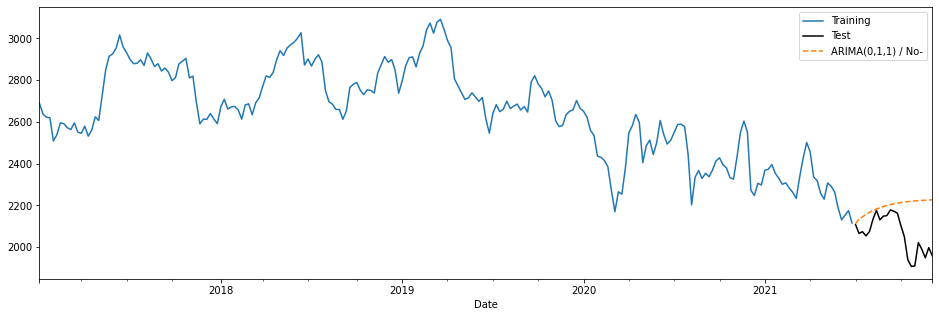

Test Error Metrics
MAE: 131.9129
MSE: 28228.7658
MAPE: 0.0661
sMAPE: 0.0627
MASE: -1.1125


In [ ]:
print("ARIMA(0,1,1) / No-")
pred_arima011 = predict_from_arima(arima_uni, y_test)
make_plot(y_train, y_test, pred_arima011, "ARIMA(0,1,1) / No-")
metrics_arima011 = calc_metrics(y_test, pred_arima011, return_dict=True)

### Multivariate ARIMAX

#### NIKKEI 225 Regressor

In [ ]:
arimax_n225 = auto_arima(y_train, X=df_train[["n225"]], start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_n225.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1273.925
Date:                Thu, 02 Jun 2022   AIC                           2555.851
Time:                        22:06:20   BIC                           2569.655
Sample:                    01-08-2017   HQIC                          2561.417
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
n225           0.0303      0.006      4.702      0.000       0.018       0.043
ar.L1         -0.4806      0.168     -2.854      0.004      -0.811      -0.151
ma.L1          0.7074      0.147      4.811      0.0

ARIMAX(0,1,1) / n225


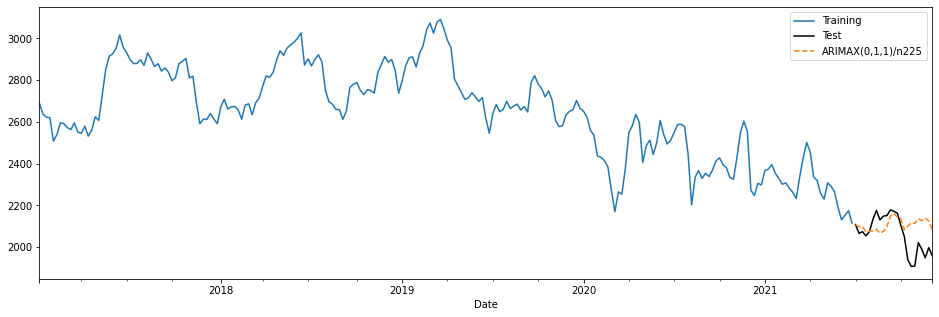

Test Error Metrics
MAE: 78.5779
MSE: 10447.2298
MAPE: 0.0393
sMAPE: 0.0382
MASE: -0.6627


In [ ]:
print("ARIMAX(0,1,1) / n225")
pred_arimax011_n225 = predict_from_arima(arimax_n225, y_test, test_X=df_test[["n225"]])
make_plot(y_train, y_test, pred_arimax011_n225, "ARIMAX(0,1,1)/n225")
metrics_arimax011_n225 = calc_metrics(y_test, pred_arimax011_n225, return_dict=True)

#### Oil Regressor

In [ ]:
arimax_oil= auto_arima(y_train, X=df_train[["oil"]], start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_oil.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1278.155
Date:                Thu, 02 Jun 2022   AIC                           2568.310
Time:                        22:06:32   BIC                           2589.016
Sample:                    01-08-2017   HQIC                          2576.659
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
oil           -0.2549      1.125     -0.227      0.821      -2.460       1.950
ar.L1          0.4455      0.169      2.630      0.009       0.114       0.778
ar.L2          0.3680      0.172      2.139      0.0

ARIMAX(0,1,1) / oil&usdjpy


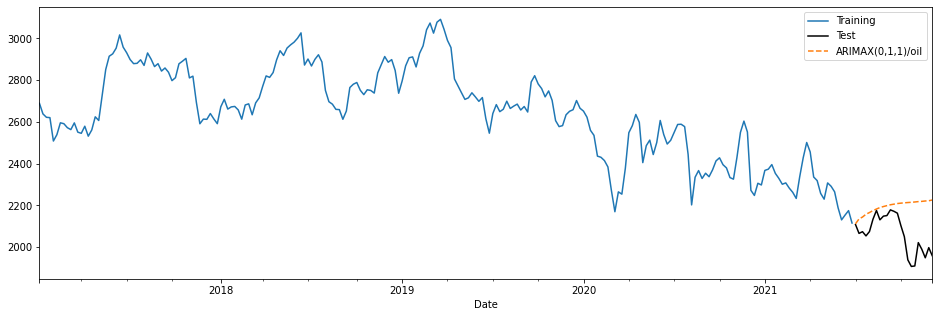

Test Error Metrics
MAE: 129.9804
MSE: 27404.4503
MAPE: 0.0652
sMAPE: 0.0618
MASE: -1.0962


In [ ]:
print("ARIMAX(0,1,1) / oil&usdjpy")
pred_arimax011_oil = predict_from_arima(arimax_oil, y_test, test_X=df_test[["oil"]])
make_plot(y_train, y_test, pred_arimax011_oil, "ARIMAX(0,1,1)/oil")
metrics_arimax011_oil= calc_metrics(y_test, pred_arimax011_oil, return_dict=True)

#### All external regressors

In [ ]:
arimax_all = auto_arima(y_train, X=df_train[df_train.columns.difference(["Tokyo Gas"])], start_p=0, d=1, start_q=0, seasonal=False)
print(arimax_all.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1271.564
Date:                Thu, 02 Jun 2022   AIC                           2561.128
Time:                        22:06:42   BIC                           2592.187
Sample:                    01-08-2017   HQIC                          2573.652
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
jp_gdp        -0.0020      0.001     -2.732      0.006      -0.004      -0.001
jp_i          20.2221    183.043      0.110      0.912    -338.535     378.980
jp_unemp      -3.8768     68.513     -0.057      0.9

ARIMAX(1,1,1) / all 


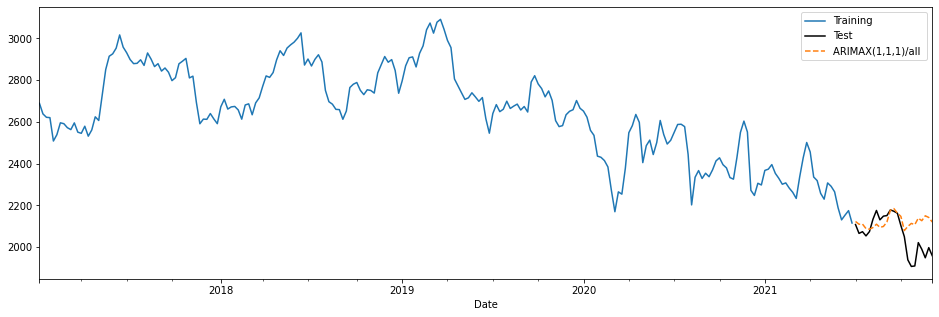

Test Error Metrics
MAE: 77.2154
MSE: 10671.9102
MAPE: 0.0388
sMAPE: 0.0375
MASE: -0.6512


In [ ]:
print("ARIMAX(1,1,1) / all ")
pred_arimax011_all = predict_from_arima(arimax_all, y_test, test_X=df_test[df_test.columns.difference(["Tokyo Gas"])])
make_plot(y_train, y_test, pred_arimax011_all, "ARIMAX(1,1,1)/all ")
metrics_arimax011_all = calc_metrics(y_test, pred_arimax011_all, return_dict=True)

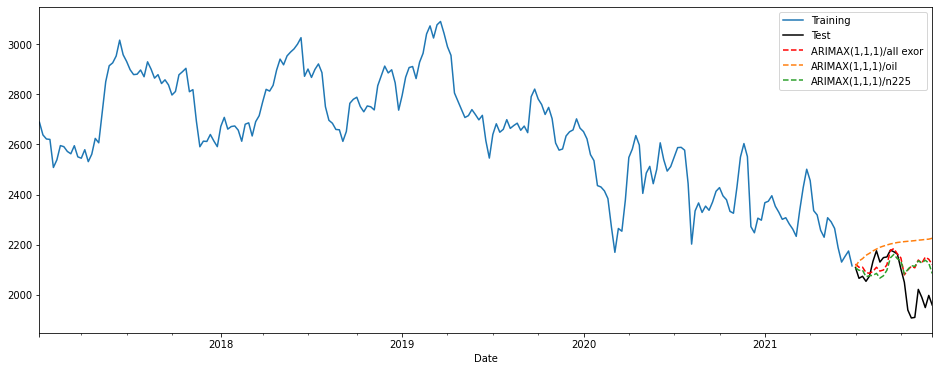

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
pred_arimax011_all.plot(ax=ax, label="ARIMAX(1,1,1)/all exor", linestyle="dashed", color = 'red')
pred_arimax011_oil.plot(ax=ax, label="ARIMAX(1,1,1)/oil", linestyle="dashed")
pred_arimax011_n225.plot(ax=ax, label="ARIMAX(1,1,1)/n225", linestyle="dashed" )
plt.legend()
plt.show()

In [ ]:
#Accuracy Check
weekly_pred = dict()
weekly_metrics = dict()

weekly_pred["ARIMA(0,1,1) / No-"] = pred_arima011
weekly_metrics["ARIMA(0,1,1) / No-"] = metrics_arima011

weekly_pred["ARIMAX(0,1,1) / all"] = pred_arimax011_all
weekly_metrics["ARIMAX(0,1,1) / all"] = metrics_arimax011_all

weekly_pred["ARIMAX(0,1,1) / n225"] = pred_arimax011_n225
weekly_metrics["ARIMAX(0,1,1) / n225"] = metrics_arimax011_n225

weekly_pred["ARIMAX(0,1,1) / oil"] = pred_arimax011_oil
weekly_metrics["ARIMAX(0,1,1) / oil "] = metrics_arimax011_oil

pd.DataFrame(weekly_metrics).T

MAE         MSE    MAPE   sMAPE    MASE
ARIMA(0,1,1) / No-    131.9129  28228.7658  0.0661  0.0627 -1.1125
ARIMAX(0,1,1) / all    77.2154  10671.9102  0.0388  0.0375 -0.6512
ARIMAX(0,1,1) / n225   78.5779  10447.2298  0.0393  0.0382 -0.6627
ARIMAX(0,1,1) / oil   129.9804  27404.4503  0.0652  0.0618 -1.0962

# VAR Model (Tokyo Gas)

In [89]:
tokyo = main5.loc[main5["Name"]=="Tokyo Gas", "Adjusted Close"]
tokyo = tokyo.dropna()
tokyo.name = "tokyo"

### Pre-processing & stationarity check 


In [90]:
tokyo = pd.DataFrame(tokyo)
tokyo.reset_index()

Date   tokyo
0    2017-01-04  2691.5
1    2017-01-05  2683.5
2    2017-01-06  2691.5
3    2017-01-10  2628.0
4    2017-01-11  2648.5
...         ...     ...
1196 2021-11-29  1993.0
1197 2021-11-30  1945.0
1198 2021-12-01  1904.0
1199 2021-12-02  1975.0
1200 2021-12-03  1978.0

[1201 rows x 2 columns]

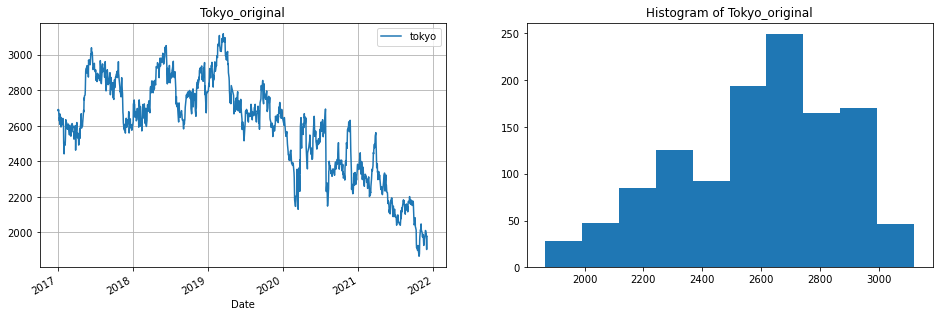


ADF/KPSS tests for Tokyo_original (alpha=0.05):
stationarity from ADF test: False
stationarity from KPSS test('c'): False
stationarity from KPSS test('ct'): False



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.201363   3.438455    0.722794
p-value               0.673009   0.010000    0.010000
Lags Used             9.000000  23.000000   23.000000
Critical Value (1%)  -3.435852   0.739000    0.216000
Critical Value (5%)  -2.863970   0.463000    0.146000
Critical Value (10%) -2.568064   0.347000    0.119000

In [91]:
# Check stationarity
create_plot_adf_kpss(tokyo, "Tokyo_original")

In [92]:
# Take first difference
tokyo_diff = tokyo.diff().dropna()

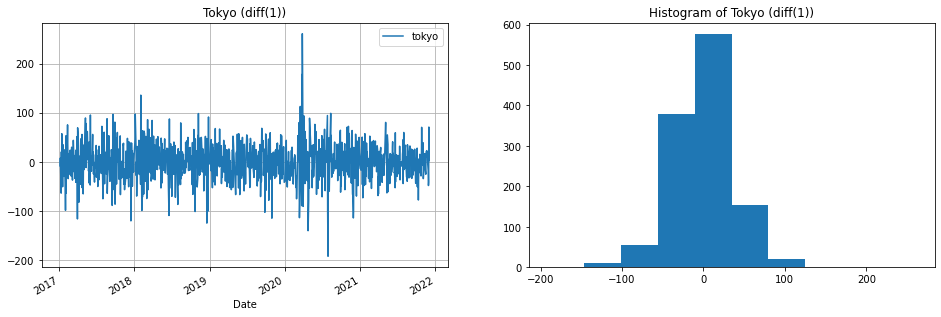


ADF/KPSS tests for Tokyo (diff(1)) (alpha=0.05):
stationarity from ADF test: True
stationarity from KPSS test('c'): True
stationarity from KPSS test('ct'): True



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.315887e+01   0.089789      0.0155
p-value               1.319894e-24   0.100000      0.1000
Lags Used             8.000000e+00  23.000000     23.0000
Critical Value (1%)  -3.435852e+00   0.739000      0.2160
Critical Value (5%)  -2.863970e+00   0.463000      0.1460
Critical Value (10%) -2.568064e+00   0.347000      0.1190

In [93]:
# Check stationarity
create_plot_adf_kpss(tokyo_diff, "Tokyo (diff(1))")

In [ ]:
# Using data before 2020 as training
y_train = tokyo[tokyo.index.year!=2021]
y_test = tokyo[tokyo.index.year==2021]

In [ ]:
y_train

tokyo
Date              
2017-01-04  2691.5
2017-01-05  2683.5
2017-01-06  2691.5
2017-01-10  2628.0
2017-01-11  2648.5
...            ...
2020-12-24  2308.5
2020-12-25  2294.5
2020-12-28  2344.5
2020-12-29  2374.5
2020-12-30  2384.0

[975 rows x 1 columns]

### Vector Auto Regression (VAR) - Oil

In [94]:
# Merge data and fill NAs with interpolation
tokyo_1 = pd.concat([tokyo, oil_s], axis=1)
tokyo_1 = tokyo_1.dropna(subset=["tokyo"])
tokyo_1["oil"] = tokyo_1["oil"].interpolate()
tokyo_1

tokyo    oil
Date                     
2017-01-04  2691.5  53.26
2017-01-05  2683.5  53.77
2017-01-06  2691.5  53.98
2017-01-10  2628.0  50.82
2017-01-11  2648.5  52.19
...            ...    ...
2021-11-29  1993.0  69.88
2021-11-30  1945.0  66.14
2021-12-01  1904.0  65.44
2021-12-02  1975.0  66.60
2021-12-03  1978.0  66.39

[1201 rows x 2 columns]

In [95]:
# Take first difference
tokyo_1_diff = tokyo_1.diff().dropna()

In [96]:
# Split into train/test
train_diff1 = tokyo_1_diff[tokyo_1_diff.index.year!=2021]
test_diff1 = tokyo_1_diff[tokyo_1_diff.index.year==2021]

In [97]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model1 = VAR(train_diff1)

results_aic1 =[]
for p in range(1,21):
    results1 = var_model1.fit(p)
    results_aic1.append(results1.aic)

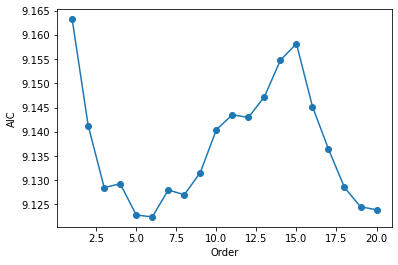

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic1, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model1 = var_model1.fit(6)
print(var2_model1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     20:54:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.25338
Nobs:                     968.000    HQIC:                   9.17228
Log likelihood:          -7136.32    FPE:                    9158.52
AIC:                      9.12244    Det(Omega_mle):         8917.39
--------------------------------------------------------------------
Results for equation tokyo
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.340061         1.246938           -0.273           0.785
L1.tokyo         0.022771         0.032311            0.705           0.481
L1.oil          -0.386131         0.513725           -0.752           0.452
L2.t

In [ ]:
# Calculate yhat
yhat_var2_1 = var2_model1.forecast(var_model1.endog, steps=len(test_diff1))

In [ ]:
# clean up yhat
df_yhat_var2_1 = pd.DataFrame(yhat_var2_1)
df_yhat_var2_1.index = test_diff1.index
df_yhat_var2_1.columns = test_diff1.columns
df_yhat_var2_1

tokyo       oil
Date                           
2021-01-04  -4.650032 -0.247341
2021-01-05 -10.324048 -0.155952
2021-01-06   2.018371  0.042515
2021-01-07   1.968440 -0.135240
2021-01-08   0.930132  0.061009
...               ...       ...
2021-11-29  -0.298810 -0.004684
2021-11-30  -0.298810 -0.004684
2021-12-01  -0.298810 -0.004684
2021-12-02  -0.298810 -0.004684
2021-12-03  -0.298810 -0.004684

[226 rows x 2 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_1 = pd.concat([tokyo_1[tokyo_1.index==pd.datetime(2020,12,30)], df_yhat_var2_1], axis=0).cumsum()
df_pred_var2_1 = df_pred_var2_1[df_pred_var2_1.index!=pd.datetime(2020,12,30)]

In [ ]:
y_pred_var2_1 = df_pred_var2_1["tokyo"]

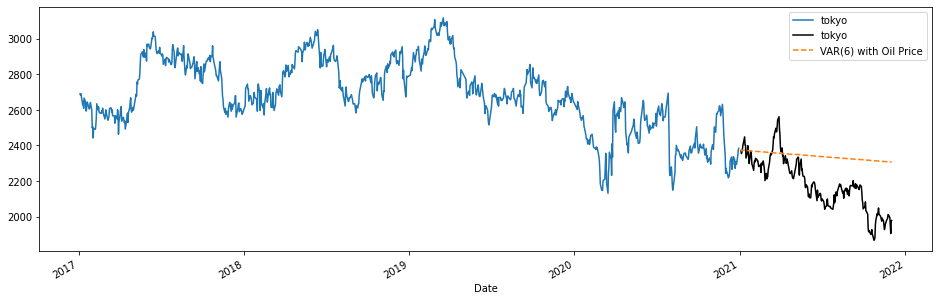

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_1.plot(ax=ax, label="VAR(6) with Oil Price", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics1 = calc_metrics(y_test, y_pred_var2_1, return_dict=True)

Test Error Metrics
MAE: 173.6549
MSE: 42873.2797
MAPE: 0.0833
sMAPE: 0.0786
MASE: tokyo   -7.4615
dtype: float64


### Vector Auto Regression (VAR) - Oil & N225

In [ ]:
# Merge data and fill NAs with interpolation
tokyo_2 = pd.concat([tokyo, oil_s, n225_s], axis=1)
tokyo_2 = tokyo_2.dropna(subset=["tokyo"])
tokyo_2["oil"] = tokyo_2["oil"].interpolate()
tokyo_2["n225"] = tokyo_2["n225"].interpolate()
tokyo_2

tokyo    oil          n225
Date                                   
2017-01-04  2691.5  53.26  19594.160156
2017-01-05  2683.5  53.77  19520.689453
2017-01-06  2691.5  53.98  19454.330078
2017-01-10  2628.0  50.82  19301.439453
2017-01-11  2648.5  52.19  19364.669922
...            ...    ...           ...
2021-11-29  1993.0  69.88  28283.919922
2021-11-30  1945.0  66.14  27821.759766
2021-12-01  1904.0  65.44  27935.619141
2021-12-02  1975.0  66.60  27753.369141
2021-12-03  1978.0  66.39  28029.570312

[1201 rows x 3 columns]

In [ ]:
# Take first difference
tokyo_2_diff = tokyo_2.diff().dropna()

In [ ]:
# Split into train/test
train_diff2 = tokyo_2_diff[tokyo_2_diff.index.year!=2021]
test_diff2 = tokyo_2_diff[tokyo_2_diff.index.year==2021]

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model2 = VAR(train_diff2)

results_aic2 =[]
for p in range(1,21):
    results2 = var_model2.fit(p)
    results_aic2.append(results2.aic)

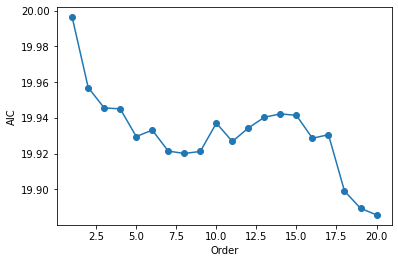

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic2, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model2 = var_model2.fit(20)
print(var2_model2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jun, 2022
Time:                     18:34:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.8181
Nobs:                     954.000    HQIC:                   20.2408
Log likelihood:          -13363.5    FPE:                4.32974e+08
AIC:                      19.8857    Det(Omega_mle):     3.59509e+08
--------------------------------------------------------------------
Results for equation tokyo
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.351132         1.258189            0.279           0.780
L1.tokyo          0.015093         0.036327            0.415           0.678
L1.oil           -0.542846         0.558643           -0.972           0.331

In [ ]:
# Calculate yhat
yhat_var2_2 = var2_model2.forecast(var_model2.endog, steps=len(test_diff2))

In [ ]:
# clean up yhat
df_yhat_var2_2 = pd.DataFrame(yhat_var2_2)
df_yhat_var2_2.index = test_diff2.index
df_yhat_var2_2.columns = test_diff2.columns
df_yhat_var2_2

tokyo       oil       n225
Date                                      
2021-01-04  11.688611  0.853693  99.427897
2021-01-05   2.689187 -0.254569  28.897992
2021-01-06   1.638704 -1.446170  19.718546
2021-01-07 -12.107077  1.342011 -37.381688
2021-01-08  -0.264490  1.536821 -17.597606
...               ...       ...        ...
2021-11-29  -0.158020 -0.004643   8.979042
2021-11-30  -0.158013 -0.004643   8.979046
2021-12-01  -0.158008 -0.004643   8.979024
2021-12-02  -0.158005 -0.004644   8.978982
2021-12-03  -0.158006 -0.004644   8.978933

[226 rows x 3 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_2 = pd.concat([tokyo_2[tokyo_2.index==pd.datetime(2020,12,30)], df_yhat_var2_2], axis=0).cumsum()
df_pred_var2_2 = df_pred_var2_2[df_pred_var2_2.index!=pd.datetime(2020,12,30)]

In [ ]:
y_pred_var2_2 = df_pred_var2_2["tokyo"]

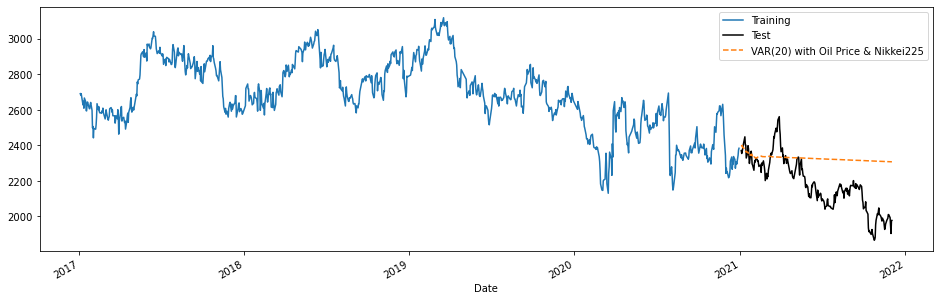

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_2.plot(ax=ax, label="VAR(20) with Oil Price & Nikkei225", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics2 = calc_metrics(y_test, y_pred_var2_2, return_dict=True)

Test Error Metrics
MAE: 164.9285
MSE: 40503.7034
MAPE: 0.0793
sMAPE: 0.0749
MASE: -7.0866


### Vector Auto Regression (VAR) - Oil, N225, Unemployment

In [ ]:
# Merge data and fill NAs with interpolation
tokyo_3 = pd.concat([tokyo, oil_s, n225_s, unemp_s], axis=1)
tokyo_3["jp_unemp"] = tokyo_3["jp_unemp"].fillna(method="ffill")
tokyo_3 = tokyo_3.dropna(subset=["tokyo"])
tokyo_3["oil"] = tokyo_3["oil"].interpolate()
tokyo_3["n225"] = tokyo_3["n225"].interpolate()
tokyo_3[tokyo_3.isnull().any(axis=1)]

Empty DataFrame
Columns: [tokyo, oil, n225, jp_unemp]
Index: []

In [ ]:
# Take first difference
tokyo_3_diff = tokyo_3.diff().dropna()

In [ ]:
# Split into train/test
train_diff3 = tokyo_3_diff[tokyo_3_diff.index.year!=2021]
test_diff3 = tokyo_3_diff[tokyo_3_diff.index.year==2021]

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model3 = VAR(train_diff3)

results_aic3 =[]
for p in range(1,21):
    results3 = var_model3.fit(p)
    results_aic3.append(results3.aic)

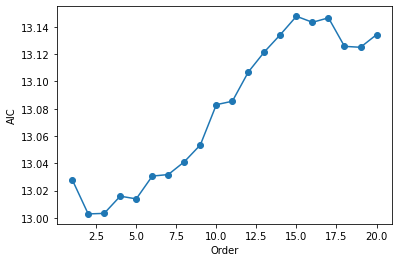

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic3, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model3 = var_model3.fit(2)
print(var2_model3.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jun, 2022
Time:                     11:41:01
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    13.1836
Nobs:                     972.000    HQIC:                   13.0717
Log likelihood:          -11800.2    FPE:                    443700.
AIC:                      13.0029    Det(Omega_mle):         427641.
--------------------------------------------------------------------
Results for equation tokyo
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.375938         1.265658           -0.297           0.766
L1.tokyo            0.016420         0.035015            0.469           0.639
L1.oil             -0.335657         0.514277           -0.653      

In [ ]:
# Calculate yhat
yhat_var2_3 = var2_model3.forecast(var_model3.endog, steps=len(test_diff3))

In [ ]:
# clean up yhat
df_yhat_var2_3 = pd.DataFrame(yhat_var2_3)
df_yhat_var2_3.index = test_diff3.index
df_yhat_var2_3.columns = test_diff3.columns
df_yhat_var2_3

tokyo       oil       n225  jp_unemp
Date                                               
2021-01-04  0.188015  0.419958  61.437427 -0.002616
2021-01-05 -1.670987 -0.351860   1.642294  0.000852
2021-01-06 -0.350625  0.098725  13.832494 -0.000179
2021-01-07 -0.091842  0.001737   5.826075  0.000130
2021-01-08 -0.354250 -0.019515   9.837397  0.000086
...              ...       ...        ...       ...
2021-11-29 -0.316197 -0.005540   8.283459  0.000100
2021-11-30 -0.316197 -0.005540   8.283459  0.000100
2021-12-01 -0.316197 -0.005540   8.283459  0.000100
2021-12-02 -0.316197 -0.005540   8.283459  0.000100
2021-12-03 -0.316197 -0.005540   8.283459  0.000100

[226 rows x 4 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_3 = pd.concat([tokyo_3[tokyo_3.index==pd.datetime(2020,12,30)], df_yhat_var2_3], axis=0).cumsum()
df_pred_var2_3 = df_pred_var2_3[df_pred_var2_3.index!=pd.datetime(2020,12,30)]

y_pred_var2_3 = df_pred_var2_3["tokyo"]

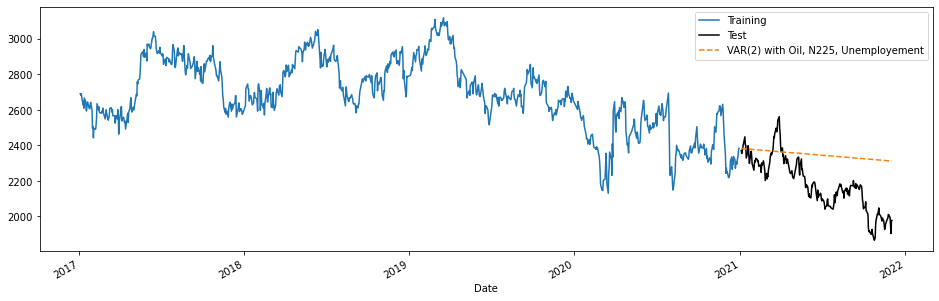

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_3.plot(ax=ax, label="VAR(2) with Oil, N225, Unemployement", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics3 = calc_metrics(y_test, y_pred_var2_3, return_dict=True)

Test Error Metrics
MAE: 179.2476
MSE: 44981.3307
MAPE: 0.0859
sMAPE: 0.081
MASE: -7.7018


### Vector Auto Regression (VAR) - Oil, N225, Unemployement, GDP

In [ ]:
# Merge data and fill NAs with interpolation
tokyo_4 = pd.concat([tokyo, oil_s, n225_s, unemp_s, gdp_s], axis=1)
tokyo_4["jp_gdp"] = tokyo_4["jp_gdp"].fillna(method="ffill")
tokyo_4["jp_unemp"] = tokyo_4["jp_unemp"].fillna(method="ffill")
tokyo_4 = tokyo_4.dropna(subset=["tokyo"])
tokyo_4["oil"] = tokyo_4["oil"].interpolate()
tokyo_4["n225"] = tokyo_4["n225"].interpolate()
tokyo_4[tokyo_4.isnull().any(axis=1)]

Empty DataFrame
Columns: [tokyo, oil, n225, jp_unemp, jp_gdp]
Index: []

In [ ]:
# Take first difference
tokyo_4_diff = tokyo_4.diff().dropna()

In [ ]:
# Split into train/test
train_diff4 = tokyo_4_diff[tokyo_4_diff.index.year!=2021]
test_diff4 = tokyo_4_diff[tokyo_4_diff.index.year==2021]

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model4 = VAR(train_diff4)

In [ ]:
results_aic4 =[]
for p in range(1,21):
    results4 = var_model4.fit(p)
    results_aic4.append(results4.aic)


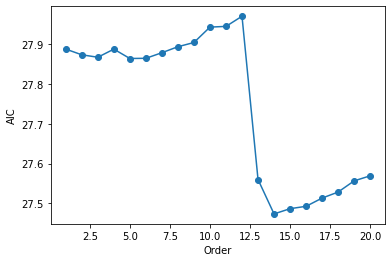

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic4, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model4 = var_model4.fit(14)
print(var2_model4.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jun, 2022
Time:                     11:42:13
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    29.2735
Nobs:                     960.000    HQIC:                   28.1591
Log likelihood:          -19643.3    FPE:                8.55638e+11
AIC:                      27.4738    Det(Omega_mle):     5.98898e+11
--------------------------------------------------------------------
Results for equation tokyo
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.129350         1.274157            0.102           0.919
L1.tokyo             0.016725         0.036604            0.457           0.648
L1.oil              -0.028633         0.681797           -0.042 

In [ ]:
# Calculate yhat
yhat_var2_4 = var2_model4.forecast(var_model4.endog, steps=len(test_diff4))

In [ ]:
# clean up yhat
df_yhat_var2_4 = pd.DataFrame(yhat_var2_4)
df_yhat_var2_4.index = test_diff4.index
df_yhat_var2_4.columns = test_diff4.columns
df_yhat_var2_4

tokyo       oil       n225  jp_unemp      jp_gdp
Date                                                           
2021-01-04  6.479636  0.102098  86.754079  0.002943 -506.777595
2021-01-05 -1.216366  0.075738 -12.227668  0.005096  -21.508014
2021-01-06  3.386518 -0.012620  43.704692 -0.005312 -140.902446
2021-01-07 -9.955103  0.331145 -24.920802 -0.001603 -868.136344
2021-01-08  2.861119  0.558415  13.154791 -0.000842 -847.139945
...              ...       ...        ...       ...         ...
2021-11-29 -0.300903 -0.001475   8.935765  0.000080   -1.497658
2021-11-30 -0.300903 -0.001475   8.935766  0.000080   -1.497658
2021-12-01 -0.300903 -0.001475   8.935766  0.000080   -1.497661
2021-12-02 -0.300903 -0.001475   8.935766  0.000080   -1.497661
2021-12-03 -0.300903 -0.001475   8.935765  0.000080   -1.497659

[226 rows x 5 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_4 = pd.concat([tokyo_4[tokyo_4.index==pd.datetime(2020,12,30)], df_yhat_var2_4], axis=0).cumsum()
df_pred_var2_4 = df_pred_var2_4[df_pred_var2_4.index!=pd.datetime(2020,12,30)]

y_pred_var2_4 = df_pred_var2_4["tokyo"]

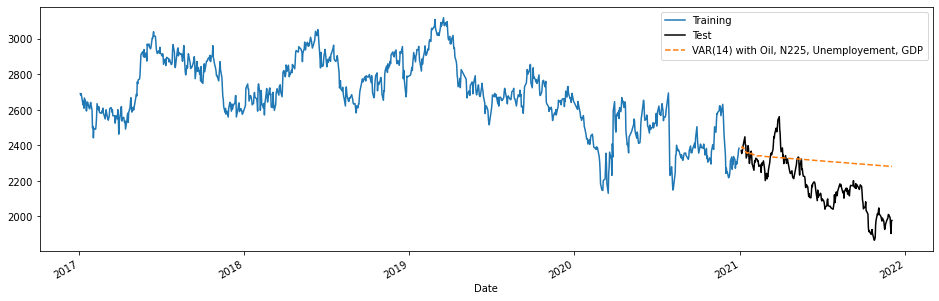

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_4.plot(ax=ax, label="VAR(14) with Oil, N225, Unemployement, GDP", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics4 = calc_metrics(y_test, y_pred_var2_4, return_dict=True)

Test Error Metrics
MAE: 155.0108
MSE: 35544.422
MAPE: 0.0744
sMAPE: 0.0706
MASE: -6.6604


### Vector Auto Regression (VAR) - Oil, N225, Unemployement, GDP, USD-JPY rate

In [ ]:
# Merge data and fill NAs with interpolation
tokyo_5 = pd.concat([tokyo, oil_s, n225_s, unemp_s, gdp_s, usdjpy_s], axis=1)
tokyo_5["jp_gdp"] = tokyo_5["jp_gdp"].fillna(method="ffill")
tokyo_5["jp_unemp"] = tokyo_5["jp_unemp"].fillna(method="ffill")
tokyo_5 = tokyo_5.dropna(subset=["tokyo"])
tokyo_5["oil"] = tokyo_5["oil"].interpolate()
tokyo_5["n225"] = tokyo_5["n225"].interpolate()
tokyo_5["usdjpy"] = tokyo_5["usdjpy"].interpolate()
tokyo_5[tokyo_5.isnull().any(axis=1)]

Empty DataFrame
Columns: [tokyo, oil, n225, jp_unemp, jp_gdp, usdjpy]
Index: []

In [ ]:
# Take first difference
tokyo_5_diff = tokyo_5.diff().dropna()

In [ ]:
# Split into train/test
train_diff5 = tokyo_5_diff[tokyo_5_diff.index.year!=2021]
test_diff5 = tokyo_5_diff[tokyo_5_diff.index.year==2021]

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model5 = VAR(train_diff5)

In [ ]:
results_aic5 =[]
for p in range(1,21):
    results5 = var_model5.fit(p)
    results_aic5.append(results5.aic)


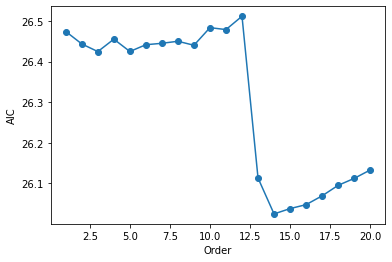

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic5, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model5 = var_model5.fit(14)
print(var2_model5.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jun, 2022
Time:                     18:42:17
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    28.6103
Nobs:                     960.000    HQIC:                   27.0094
Log likelihood:          -20155.0    FPE:                2.01203e+11
AIC:                      26.0248    Det(Omega_mle):     1.20938e+11
--------------------------------------------------------------------
Results for equation tokyo
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.462762         1.295484            0.357           0.721
L1.tokyo             0.022950         0.036923            0.622           0.534
L1.oil              -0.007295         0.683806           -0.011 

In [ ]:
# Calculate yhat
yhat_var2_5 = var2_model5.forecast(var_model5.endog, steps=len(test_diff5))

In [ ]:
# clean up yhat
df_yhat_var2_5 = pd.DataFrame(yhat_var2_5)
df_yhat_var2_5.index = test_diff5.index
df_yhat_var2_5.columns = test_diff5.columns
df_yhat_var2_5

tokyo       oil       n225  jp_unemp      jp_gdp    usdjpy
Date                                                                     
2021-01-04  2.372628  0.287518  73.167477  0.002115 -482.781396 -0.175379
2021-01-05  0.345862  0.294738  11.520023  0.004589  -31.465788 -0.128185
2021-01-06  5.309567  0.067789  25.945321 -0.005274   22.596011  0.019328
2021-01-07 -5.928458  0.196840  -2.026457  0.000696 -961.812042 -0.116844
2021-01-08  3.009113  0.635541  18.285359 -0.000467 -802.567411  0.106791
...              ...       ...        ...       ...         ...       ...
2021-11-29 -0.285417 -0.002314   8.825160  0.000091   -2.882649 -0.010832
2021-11-30 -0.285417 -0.002314   8.825163  0.000091   -2.882663 -0.010832
2021-12-01 -0.285417 -0.002314   8.825166  0.000091   -2.882650 -0.010832
2021-12-02 -0.285417 -0.002314   8.825165  0.000091   -2.882632 -0.010832
2021-12-03 -0.285417 -0.002314   8.825165  0.000091   -2.882650 -0.010832

[226 rows x 6 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_5 = pd.concat([tokyo_5[tokyo_5.index==pd.datetime(2020,12,30)], df_yhat_var2_5], axis=0).cumsum()
df_pred_var2_5 = df_pred_var2_5[df_pred_var2_5.index!=pd.datetime(2020,12,30)]

y_pred_var2_5 = df_pred_var2_5["tokyo"]

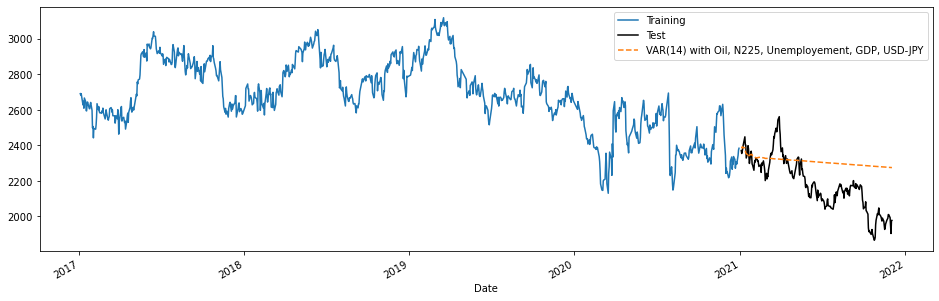

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_5.plot(ax=ax, label="VAR(14) with Oil, N225, Unemployement, GDP, USD-JPY", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics5 = calc_metrics(y_test, y_pred_var2_5, return_dict=True)

Test Error Metrics
MAE: 149.9029
MSE: 33680.3447
MAPE: 0.072
sMAPE: 0.0684
MASE: -6.441


### Vector Auto Regression (VAR) - All External Data

In [ ]:
# Merge data and fill NAs with interpolation
tokyo_6 = pd.concat([tokyo, gdp_s, unemp_s, oil_s, usdjpy_s, interest_s, n225_s], axis=1)
tokyo_6["jp_gdp"] = tokyo_6["jp_gdp"].fillna(method="ffill")
tokyo_6["jp_unemp"] = tokyo_6["jp_unemp"].fillna(method="ffill")
tokyo_6 = tokyo_6.dropna(subset=["tokyo"])
tokyo_6["oil"] = tokyo_6["oil"].interpolate()
tokyo_6["n225"] = tokyo_6["n225"].interpolate()
tokyo_6["usdjpy"] = tokyo_6["usdjpy"].interpolate()
tokyo_6[tokyo_6.isnull().any(axis=1)]

Empty DataFrame
Columns: [tokyo, jp_gdp, jp_unemp, oil, usdjpy, jp_i, n225]
Index: []

In [ ]:
# Take first difference
tokyo_6_diff = tokyo_6.diff().dropna()

In [ ]:
# Split diff into train/test
train_diff6 = tokyo_6_diff[tokyo_6_diff.index.year!=2021]
test_diff6 = tokyo_6_diff[tokyo_6_diff.index.year==2021]

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
var_model6=VAR(train_diff)

results_aic6 =[]
for p in range(1,21):
    results6 = var_model6.fit(p)
    results_aic6.append(results6.aic)

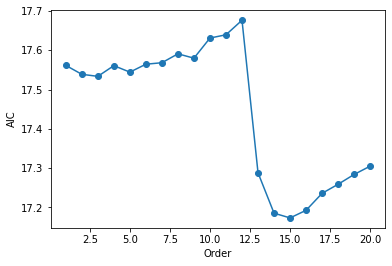

In [ ]:
# Min=2
plt.plot(list(np.arange(1,21,1)), results_aic, marker="o")
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
var2_model6 = var_model6.fit(15)
print(var2_model6.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Jun, 2022
Time:                     18:49:05
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    20.9383
Nobs:                     959.000    HQIC:                   18.6073
Log likelihood:          -17018.0    FPE:                2.89134e+07
AIC:                      17.1735    Det(Omega_mle):     1.38798e+07
--------------------------------------------------------------------
Results for equation tokyo
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.765500         1.287345            0.595           0.552
L1.tokyo             0.018599         0.037006            0.503           0.615
L1.jp_gdp            0.000939         0.000856            1.097 

In [ ]:
# Calculate yhat
yhat_var2_6 = var2_model6.forecast(var_model6.endog, steps=len(test_diff6))

In [ ]:
# clean up yhat
df_yhat_var2_6 = pd.DataFrame(yhat_var2_6)
df_yhat_var2_6.index = test_diff6.index
df_yhat_var2_6.columns = test_diff6.columns
df_yhat_var2_6

tokyo       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
Date                                                                         
2021-01-04   9.709107  -113.410223 -0.001618  0.179858 -0.139402 -0.001512   
2021-01-05   8.741641    75.065053  0.003261  0.089964 -0.054060 -0.000822   
2021-01-06   2.219266   -77.555580 -0.008300  0.148149 -0.066364  0.002384   
2021-01-07 -10.834405  -624.137319  0.000243  0.408428  0.000294  0.000256   
2021-01-08   2.062588 -1095.489061  0.002165  0.280710  0.106668  0.002013   
...               ...          ...       ...       ...       ...       ...   
2021-11-29  -0.282191    -0.951496  0.000110 -0.003702 -0.011049 -0.000055   
2021-11-30  -0.282192    -0.951481  0.000110 -0.003702 -0.011049 -0.000055   
2021-12-01  -0.282191    -0.951473  0.000110 -0.003702 -0.011049 -0.000055   
2021-12-02  -0.282191    -0.951510  0.000110 -0.003702 -0.011049 -0.000055   
2021-12-03  -0.282191    -0.951512  0.000110 -0.003702 -0.011049 -0.000055   

                 n225  
Date                   
2021-01-04  78.150147  
2021-01-05  38.893853  
2021-01-06  33.240096  
2021-01-07 -38.528112  
2021-01-08  27.572715  
...               ...  
2021-11-29   8.415911  
2021-11-30   8.415910  
2021-12-01   8.415906  
2021-12-02   8.415908  
2021-12-03   8.415908  

[226 rows x 7 columns]

In [ ]:
# Recover first order differencing
df_pred_var2_6 = pd.concat([tokyo_6[tokyo_6.index==pd.datetime(2020,12,30)], df_yhat_var2_6], axis=0).cumsum()
df_pred_var2_6 = df_pred_var2_6[df_pred_var2_6.index!=pd.datetime(2020,12,30)]

y_pred_var2_6 = df_pred_var2_6["tokyo"]

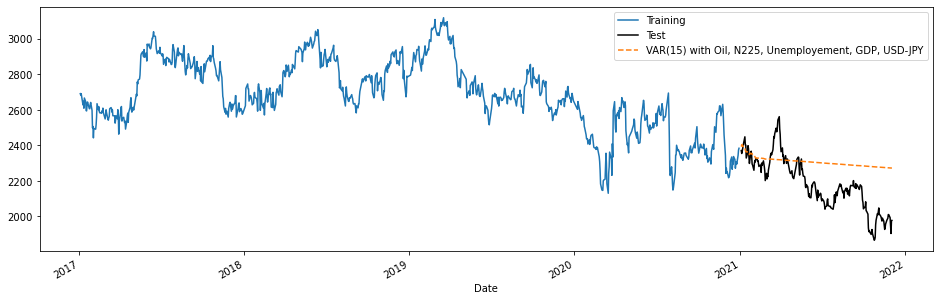

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
y_pred_var2_6.plot(ax=ax, label="VAR(15) with Oil, N225, Unemployement, GDP, USD-JPY", linestyle="dashed")
plt.legend()
plt.show()

In [ ]:
var2_metrics6 = calc_metrics(y_test, y_pred_var2_6, return_dict=True)

Test Error Metrics
MAE: 148.0882
MSE: 32951.911
MAPE: 0.0711
sMAPE: 0.0676
MASE: -6.363


#Prophet (Tokyo Gas)

### Daily Analysis Prophet (1 Year Prediction)

#### Univariate Prophet

In [98]:
y_train = tokyo_gas[tokyo_gas.index.year!=2021]
y_test = tokyo_gas[tokyo_gas.index.year==2021]

In [99]:
# Convert y_train into Prophet-suitable format
y_train_p = pd.DataFrame(y_train)
y_train_p = y_train_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})

# Convert y_test into Prophet-suitable format
y_test_p = pd.DataFrame(y_test)
y_test_p = y_test_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})
y_test_p.size
y_train_p.size

1950

In [100]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

# Train model with default parameter
p_model_1 = Prophet()
p_model_1.fit(y_train_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.56358


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2748     0.0223508       667.786           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2778.9    0.00948636       248.657      0.3866           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2795.37    0.00321743       249.765           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2804.08    0.00501663        280.05           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2813.61    0.00319059       135.081           1           1      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     564     

In [ ]:
# Create future_data dataframe
future_data = p_model_1.make_future_dataframe(periods=len(y_test_p), freq='D')

In [ ]:
# Make prediction
p_result_1 = p_model_1.predict(future_data)
p_result_1.head(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2017-01-04  2618.951503  2490.847581  2697.074230  2618.951503  2618.951503   
1 2017-01-05  2619.616665  2499.469519  2699.442227  2619.616665  2619.616665   
2 2017-01-06  2620.281827  2502.258062  2698.550801  2620.281827  2620.281827   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0      -22.638445            -22.638445            -22.638445  -7.441870   
1      -23.379497            -23.379497            -23.379497 -11.277116   
2      -22.732299            -22.732299            -22.732299 -13.295097   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0     -7.441870     -7.441870 -15.196575    -15.196575    -15.196575   
1    -11.277116    -11.277116 -12.102380    -12.102380    -12.102380   
2    -13.295097    -13.295097  -9.437203     -9.437203     -9.437203   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2596.313057  
1                         0.0  2596.237168  
2                         0.0  2597.549527

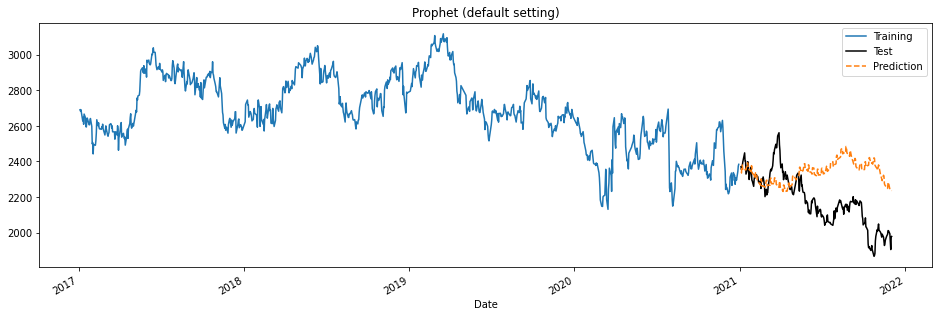

In [ ]:
# Calculate predicted values (for test data)
p_pred_1 = p_result_1["yhat"][len(y_train):]
p_pred_1.index = y_test.index

# Display result
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
p_pred_1.plot(ax=ax, label="Prediction", linestyle="dashed")
ax.set_title("Prophet (default setting)")
plt.legend()
plt.show()

In [ ]:
prophet1_metrics = calc_metrics(y_test, p_pred_1, return_dict=True)

Test Error Metrics
MAE: 197.3705
MSE: 56943.7882
MAPE: 0.0943
sMAPE: 0.0886
MASE: -8.4805


#### Multivariate Prophet

##### N225 & Oil

In [ ]:
# Add external regressor 
y_train_p_toyko = y_train_p.copy()
y_train_p_toyko["oil"] = tokyo_gas_m["oil"].values[:len(y_train_p_toyko)]
y_train_p_toyko["n225"] = tokyo_gas_m["n225"].values[:len(y_train_p_toyko)]

In [ ]:
# Train model with default parameter
p_model_2 = Prophet()
p_model_2.add_regressor("oil")
p_model_2.add_regressor("n225")
p_model_2.fit(y_train_p_toyko)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Create future_data dataframe
future_data_toyko = p_model_2.make_future_dataframe(periods=len(y_test_p), freq='D')
future_data_toyko["oil"] = tokyo_gas_m["oil"].values
future_data_toyko["n225"] = tokyo_gas_m["n225"].values
future_data_toyko.head(2)

ds    oil          n225
0 2017-01-04  53.26  19594.160156
1 2017-01-05  53.77  19520.689453

In [ ]:
# Make prediction
p_result_2 = p_model_2.predict(future_data_toyko)
p_result_2.head(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2017-01-04  2753.634345  2543.559076  2728.107631  2753.634345  2753.634345   
1 2017-01-05  2753.309951  2534.905638  2730.342785  2753.309951  2753.309951   
2 2017-01-06  2752.985556  2526.241706  2718.228527  2752.985556  2752.985556   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0     -116.943238           -116.943238           -116.943238   
1     -123.723115           -123.723115           -123.723115   
2     -127.609524           -127.609524           -127.609524   

   extra_regressors_additive  ...     weekly  weekly_lower  weekly_upper  \
0                 -94.172335  ...  19.848219     19.848219     19.848219   
1                -100.173035  ...  16.739797     16.739797     16.739797   
2                -104.221791  ...  15.027839     15.027839     15.027839   

      yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -42.619122    -42.619122    -42.619122                   0.0   
1 -40.289877    -40.289877    -40.289877                   0.0   
2 -38.415572    -38.415572    -38.415572                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  2636.691108  
1                         0.0                         0.0  2629.586835  
2                         0.0                         0.0  2625.376032  

[3 rows x 28 columns]

In [ ]:
# Calculate fitted values (for training data)
p_fitted_2 = p_result_2["yhat"][:len(y_train)]
p_fitted_2.index = y_train.index

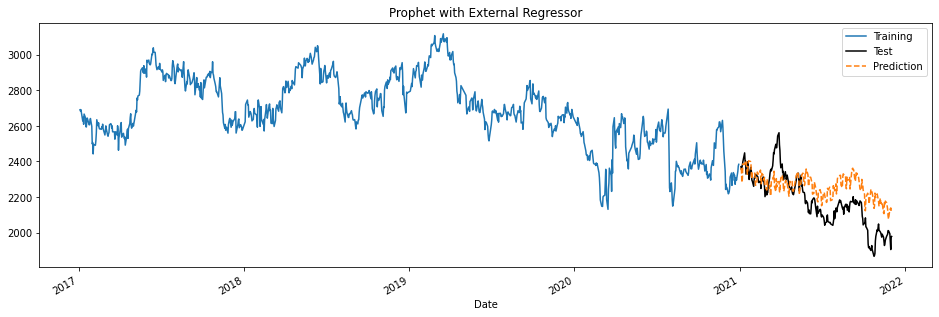

In [ ]:
# Calculate predicted values (for test data)
p_pred_2 = p_result_2["yhat"][len(y_train):]
p_pred_2.index = y_test.index

# Display result
fig, ax = plt.subplots(figsize=(16,5))
y_train.plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
p_pred_2.plot(ax=ax, label="Prediction", linestyle="dashed")
ax.set_title("Prophet with External Regressor")
plt.legend()
plt.show()

In [ ]:
prophet2_metrics = calc_metrics(y_test, p_pred_2, return_dict=True)

Test Error Metrics
MAE: 120.3906
MSE: 20752.0242
MAPE: 0.0569
sMAPE: 0.0551
MASE: -5.1729


### Weekly Analysis Prophet (6 Monthes Prediction)

#### Univariate Prophet

In [ ]:
df_train = tokyo_gas_weekly[:-23]
df_test = tokyo_gas_weekly[-23:]

In [ ]:
# Convert y_train into Prophet-suitable format
y_train_p = pd.DataFrame(df_train)
y_train_p = y_train_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})

# Convert y_test into Prophet-suitable format
y_test_p = pd.DataFrame(df_test)
y_test_p = y_test_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})
y_train_p.head(2)

ds            y
0 2017-01-08  2688.833333
1 2017-01-15  2638.250000

In [ ]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

# Train model with default parameter
prophet_uni = Prophet()
prophet_uni.fit(y_train_p)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Create future_data dataframe
future_data = prophet_uni.make_future_dataframe(periods=len(y_test_p), freq='W')

In [ ]:
# Make prediction
result_prophet_uni = prophet_uni.predict(future_data)
result_prophet_uni.head(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2017-01-08  2679.856082  2520.912654  2816.145145  2679.856082  2679.856082   
1 2017-01-15  2682.312208  2536.257599  2831.972440  2682.312208  2682.312208   
2 2017-01-22  2684.768334  2537.962647  2813.673938  2684.768334  2684.768334   

   additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0      -10.684018            -10.684018            -10.684018 -10.684018   
1       -0.999257             -0.999257             -0.999257  -0.999257   
2      -18.771677            -18.771677            -18.771677 -18.771677   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    -10.684018    -10.684018                   0.0   
1     -0.999257     -0.999257                   0.0   
2    -18.771677    -18.771677                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  2669.172064  
1                         0.0                         0.0  2681.312951  
2                         0.0                         0.0  2665.996658

#### Multivariate Prophet 

In [ ]:
df_train = weekly_m[:-23]
df_test = weekly_m[-23:]
# Convert y_train into Prophet-suitable format
y_train_p = pd.DataFrame(df_train)
y_train_p = y_train_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})

# Convert y_test into Prophet-suitable format
y_test_p = pd.DataFrame(df_test)
y_test_p = y_test_p.reset_index().rename(columns={"Tokyo Gas":"y", "Date":"ds"})

In [ ]:
def run_prophet_(_list, train_y_p=y_train_p, test_y=y_test, df_merged=weekly_m):
    """
    Needs following inputs
    - _list: column names used as external regressors
    - train_y_p: y_train with prophet suitable format ('ds' and 'y')
    - test_y: y_test wiht normal format (length and index are needed)
    - df_merged: whole data (train+test) with external regressors
    """
    # Create df with external regressor
    y_train = train_y_p.copy()
    for c in _list:
        y_train[c] = df_merged[c].values[:len(y_train)]

    # Train model with default parameter
    prophet_model = Prophet()
    for c in _list:
        prophet_model.add_regressor(c)
    prophet_model.fit(y_train)

    # Create future_data dataframe
    future_data = prophet_model.make_future_dataframe(periods=len(test_y), freq='W')
    for c in _list:
        future_data[c] = df_merged[c].values
    
    # Make prediction
    prophet_result = prophet_model.predict(future_data)

    # Extract y_pred for test data
    pred_prophet = prophet_result["yhat"][len(y_train):]
    pred_prophet.index = test_y.index

    # Return modle, result, predicted values
    return prophet_model, prophet_result, pred_prophet

##### All External regressors

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet (default) / all


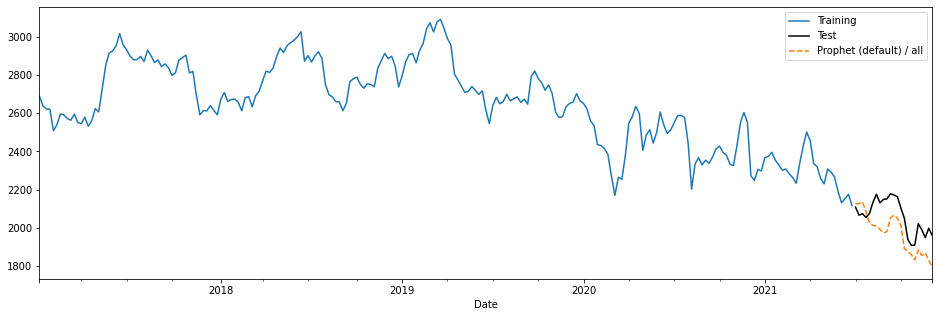

Test Error Metrics
MAE: 106.9358
MSE: 13783.4934
MAPE: 0.0516
sMAPE: 0.0532
MASE: -0.9018


In [ ]:
# With all regressors
prophet_all, result_prophet_all, pred_prophet_all = run_prophet_(_list=['jp_gdp', 'jp_unemp', 'oil', 'usdjpy', 'jp_i', 'n225'])

# Print result
print("Prophet (default) / all")
make_plot(y_train, y_test, pred_prophet_all, "Prophet (default) / all")
metrics_prophet_all = calc_metrics(y_test, pred_prophet_all, return_dict=True)

##### only n225

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet (default) / n225


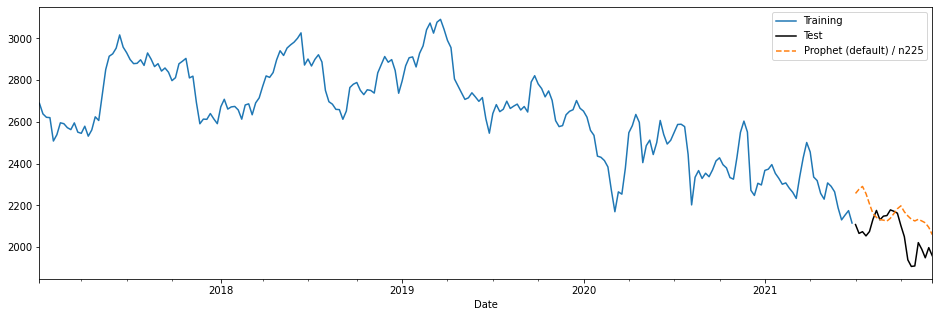

Test Error Metrics
MAE: 111.7085
MSE: 18302.6546
MAPE: 0.0554
sMAPE: 0.0533
MASE: -0.9421


In [ ]:
# Run Prophet
prophet_n225, result_prophet_n225, pred_prophet_n225 = run_prophet_(_list=['n225'])

# Print result
print("Prophet (default) / n225")
make_plot(y_train, y_test, pred_prophet_n225, "Prophet (default) / n225")
metrics_prophet_n225 = calc_metrics(y_test, pred_prophet_n225, return_dict=True)

##### oil & usdjpy

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet (default) / oil & USDJPY


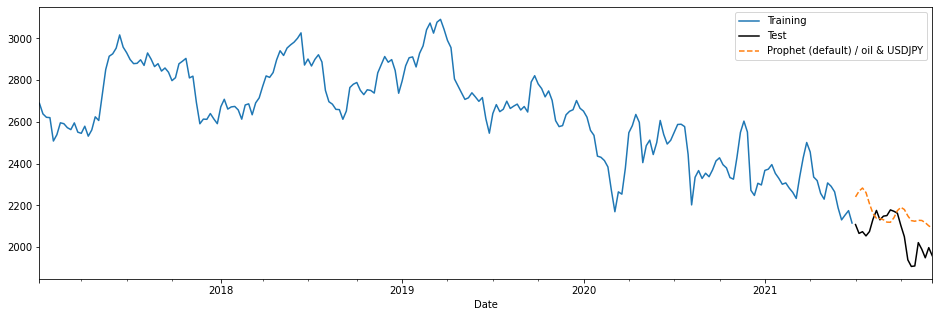

Test Error Metrics
MAE: 113.8575
MSE: 18311.7282
MAPE: 0.0565
sMAPE: 0.0543
MASE: -0.9602


In [ ]:
# Run Prophet
prophet_oilusdjpy, result_prophet_oilusdjpy, pred_prophet_oilusdjpy = run_prophet_(_list=['oil', 'usdjpy'])

# Print result
print("Prophet (default) / oil & USDJPY")
make_plot(y_train, y_test, pred_prophet_oilusdjpy, "Prophet (default) / oil & USDJPY")
metrics_prophet_oilusdjpy = calc_metrics(y_test, pred_prophet_oilusdjpy, return_dict=True)

##### GDP & Unemp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet (default) / GDP & Unemp


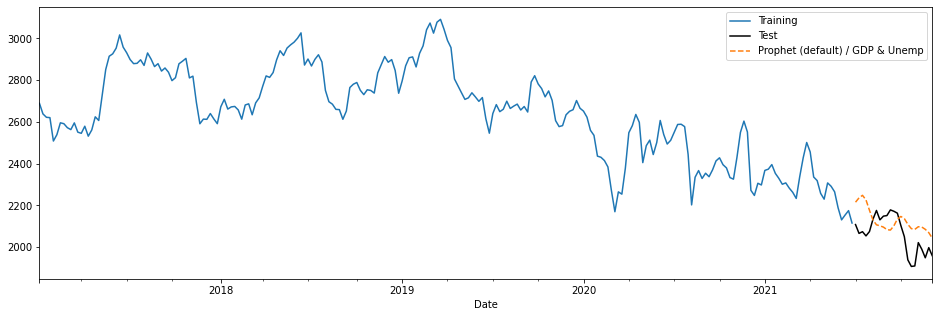

Test Error Metrics
MAE: 98.772
MSE: 12537.1325
MAPE: 0.0487
sMAPE: 0.0474
MASE: -0.833


In [ ]:
# Run Prophet
prophet_gdpunemp, result_prophet_gdpunemp, pred_prophet_gdpunemp = run_prophet_(_list=['jp_gdp', 'jp_unemp'])

# Print result
print("Prophet (default) / GDP & Unemp")
make_plot(y_train, y_test, pred_prophet_gdpunemp, "Prophet (default) / GDP & Unemp")
metrics_prophet_gdpunemp = calc_metrics(y_test, pred_prophet_gdpunemp, return_dict=True)

## Tunnned Daily Prophet 1 Year Prediction

### Hyperparameter Tunnning

In [104]:
df_tokyo = pd.Series(fitted_data, index = tokyo_gas.index)
df_tokyo = pd.DataFrame(df_tokyo).reset_index()
df_tokyo['ds'] = df_tokyo['Date']
df_tokyo = df_tokyo.drop(['Date'], axis = 1)
df_tokyo['y'] = df_tokyo[0]
df_tokyo = df_tokyo.drop([0], axis = 1)

In [105]:
train = df_tokyo.iloc[:int(len(df_tokyo)*0.75)]
test = df_tokyo.iloc[int(len(df_tokyo)*0.75):]

In [106]:
pmodel = Prophet()
pmodel.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.8576


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1747.4    0.00611402       245.253      0.3515           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1755.75   0.000645741       115.432   2.407e-06       0.001      233  LS failed, Hessian reset 
     199       1757.79   0.000744222       66.6534          10           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1760.68   0.000414647       87.8548      0.9737      0.9737      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       1762.58   0.000476129       139.536   6.199e-06       0.001      547  LS failed, Hessian reset 
     399       1763.72    5.7492e-05       61.0545      0.2352      0.2352      585   
    Iter      log prob        ||dx||      ||grad||       alpha

In [107]:
modeltuned = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)
modeltuned.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.8576


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1923.63     0.0206014       348.146           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2121.59     0.0102148       622.397      0.6409      0.6409      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2139.48     0.0172466       202.801           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2168.27     0.0327547       605.706     0.06411           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2191.91    0.00680939       108.276           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

### Residuals Check for Prohpet

In [ ]:
future_data = modeltuned.make_future_dataframe(periods=len(test), freq='d')

In [ ]:
forecast_data = modeltuned.predict(future_data)

In [ ]:
residual_pm = train['y'] - forecast_data['yhat'][:900]

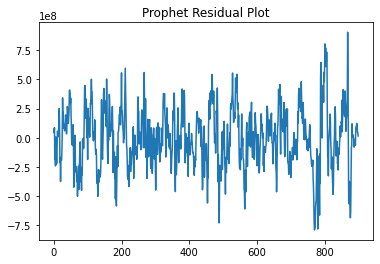

In [ ]:
residual_pm.plot()
plt.title('Prophet Residual Plot')
plt.show()

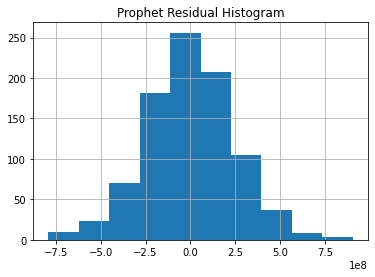

In [ ]:
residual_pm.hist()
plt.title('Prophet Residual Histogram')
plt.show()

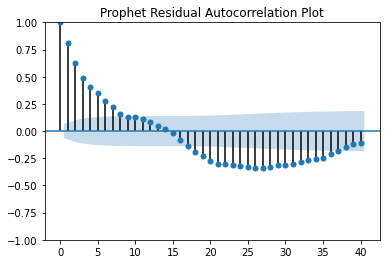

In [ ]:
p = plot_acf(residual_pm, lags=40, title='Prophet Residual Autocorrelation Plot')

In [ ]:
sm.stats.acorr_ljungbox(residual_pm, lags=[10], return_df=True, boxpierce=True)

lb_stat  lb_pvalue      bp_stat  bp_pvalue
10  1586.427578        0.0  1578.159423        0.0

In [ ]:
forecast_data_exp = pd.concat([
    forecast_data['ds'],
    inv_boxcox(forecast_data['yhat'], fitted_lambda)],axis=1)

In [ ]:
tokyo_gas1 = pd.DataFrame(data = tokyo_gas).reset_index()

In [ ]:
tokyo_gas1['ds'] = tokyo_gas1['Date']

In [ ]:
tokyo_gas1 = tokyo_gas1.drop(['Date'], axis = 1)

In [ ]:
tokyo_gas1['y'] = tokyo_gas1['Tokyo Gas']

In [ ]:
tokyo_gas1 = tokyo_gas1.drop(['Tokyo Gas'], axis = 1)

In [ ]:
tokyo_gas1['ds'] = pd.to_datetime(tokyo_gas1['ds'])
forecast_data_exp['ds'] = pd.to_datetime(forecast_data_exp['ds'])
comb = pd.merge_asof(forecast_data_exp[['ds','yhat']], tokyo_gas1[['ds','y']], on=['ds']).set_index('ds')

In [ ]:
train_comb, test_comb = comb[comb.index<test['ds'].min()], comb[comb.index>=test['ds'].min()]

In [ ]:
Prophet_TRAIN_MAE = mean_absolute_error(train_comb['y'], train_comb['yhat'])
Prophet_TRAIN_MSE = mean_squared_error(train_comb['y'], train_comb['yhat'])
Prophet_TRAIN_MAPE = mean_absolute_percentage_error(train_comb['y'], train_comb['yhat'], symmetric=False)
Prophet_TRAIN_SMAPE = mean_absolute_percentage_error(train_comb['y'], train_comb['yhat'])

In [ ]:
print(f'Prophet TRAIN MAE: {Prophet_TRAIN_MAE}')
print(f'Prophet TRAIN MSE: {Prophet_TRAIN_MSE}')
print(f'Prophet TRAIN MAPE: {Prophet_TRAIN_MAPE}')
print(f'Prophet TRAIN SMAPE: {Prophet_TRAIN_SMAPE}')

Prophet TRAIN MAE: 48.14927362512074
Prophet TRAIN MSE: 4128.805761297893
Prophet TRAIN MAPE: 0.01820474440062813
Prophet TRAIN SMAPE: 0.01813276953161715


### Prediction and Accuracy

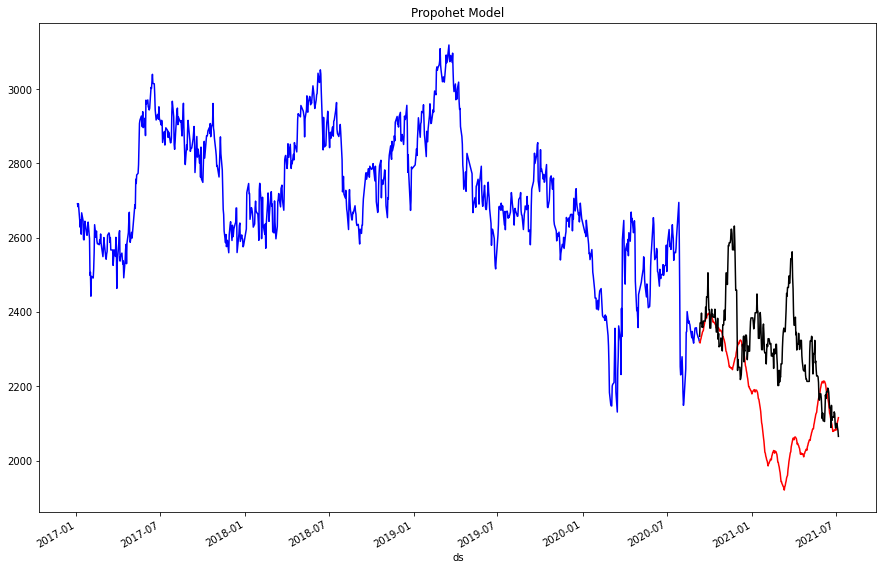

In [ ]:
train_comb['y'].plot(color = 'blue', figsize=(15, 10))
test_comb['yhat'].plot(color='red')
test_comb['y'].plot(color = 'black')
plt.title('Propohet Model')
plt.show()

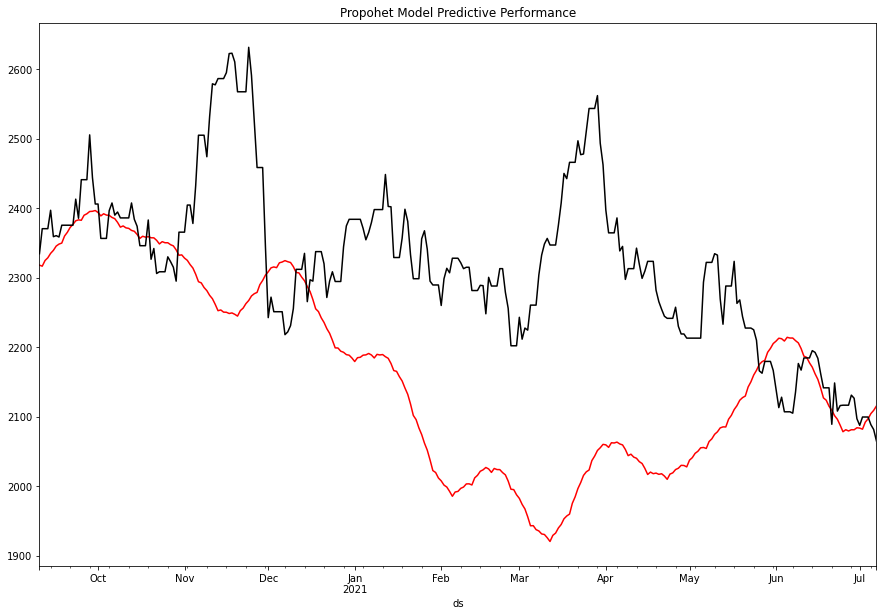

In [ ]:
test_comb['yhat'].plot(color='red', figsize=(15, 10))
test_comb['y'].plot(color = 'black')
plt.title('Propohet Model Predictive Performance')
plt.show()

In [ ]:
Prophet_TEST_MAE = mean_absolute_error(test_comb['y'], test_comb['yhat'])
Prophet_TEST_MSE = mean_squared_error(test_comb['y'], test_comb['yhat'])
Prophet_TEST_MAPE = mean_absolute_percentage_error(test_comb['y'], test_comb['yhat'], symmetric=False)
Prophet_TEST_SMAPE = mean_absolute_percentage_error(test_comb['y'], test_comb['yhat'])

/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


In [ ]:
print(f'Prophet TEST MAE: {Prophet_TEST_MAE}')
print(f'Prophet TEST MSE: {Prophet_TEST_MSE}')
print(f'Prophet TEST MAPE: {Prophet_TEST_MAPE}')
print(f'Prophet TEST SMAPE: {Prophet_TEST_SMAPE}')

Prophet TEST MAE: 174.70018620167997
Prophet TEST MSE: 49763.55046425741
Prophet TEST MAPE: 0.07399878601699326
Prophet TEST SMAPE: 0.07858572220829031


In [102]:
fitted_data, fitted_lambda = stats.boxcox(tokyo_gas)

In [103]:
df_tokyo = pd.Series(fitted_data, index = tokyo_gas.index)

In [ ]:
adf_kpss(df_tokyo)

stationarity from ADF test: False
stationarity from KPSS test('c'): False
stationarity from KPSS test('ct'): False



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.541135    3.73534    0.701049
p-value               0.513073    0.01000    0.010000
Lags Used             8.000000   20.00000   20.000000
Critical Value (1%)  -3.435848    0.73900    0.216000
Critical Value (5%)  -2.863968    0.46300    0.146000
Critical Value (10%) -2.568063    0.34700    0.119000

In [ ]:
y_train, y_test = temporal_train_test_split(df_tokyo)

In [ ]:
y_train_nonseasdiff = y_train.diff(1).dropna()

# LSTM Model

In [ ]:
main5 = df.copy().loc[df["SecuritiesCode"].isin([9501, 9503, 9531, 9532, 5020]), ["Date", "SecuritiesCode", "Close", "Name", "Category"]]
main5.loc[main5["Name"]=="ENEOS Holdings,Inc.", "Name"] = "ENEOS"
main5.loc[main5["Name"]=="Tokyo Electric Power Company Holdings,Incorporated", "Name"] = "Tokyo Electric Power"
main5.loc[main5["Name"]=="The Kansai Electric Power Company,Incorporated", "Name"] = "Kansai Electric Power"
main5.loc[main5["Name"]=="TOKYO GAS CO.,LTD.", "Name"] = "Tokyo Gas"
main5.loc[main5["Name"]=="OSAKA GAS CO.,LTD.", "Name"] = "Osaka Gas"

In [ ]:
main5["Adjusted Close"] = main5["Close"]
main5.loc[(main5["SecuritiesCode"].isin([9531, 9532])) & (main5["Date"] < dt.datetime(2017,9,27)), "Adjusted Close"] = main5.loc[(main5["SecuritiesCode"].isin([9531, 9532])) & (main5["Date"] < dt.datetime(2017,9,27)), "Adjusted Close"]*5

In [ ]:
tokyo_gas = main5.loc[main5["Name"]=="Tokyo Gas", "Adjusted Close"].dropna()

## RNN

In [ ]:
dataset = tokyo_gas[:900]

In [ ]:
dataset = dataset.to_numpy()

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps = 30
X, y = split_sequence(dataset, n_steps)

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
X.shape

(870, 30, 1)

In [ ]:
y.shape

(870,)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(1, activation="relu"))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, verbose=0)

In [ ]:
model.save("LSTM_model.h5")

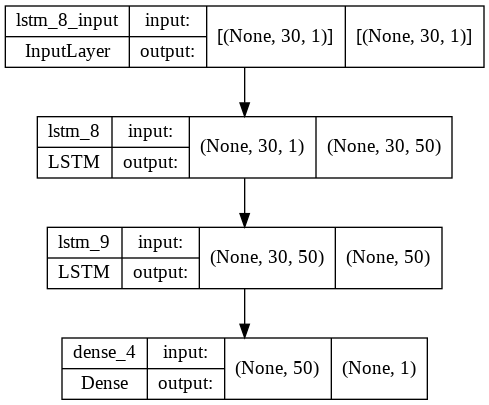

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

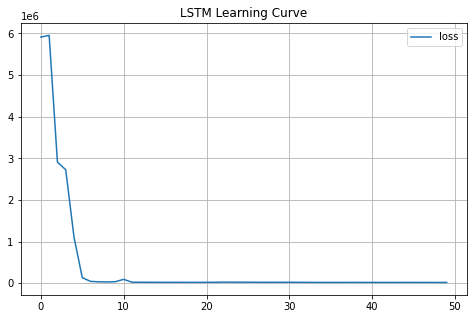

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('LSTM Learning Curve')
plt.show()

## LSTM

In [ ]:
x_input = dataset[-30:]
x_input = x_input.reshape((1, n_steps, n_features))

In [ ]:
x_input = dataset[-30:]
LSTM_pred = []
for i in range(0, 301):
  x_input_arr = x_input.reshape((1, n_steps, n_features))
  new_pred = model.predict(x_input_arr, verbose=0)
  LSTM_pred.append(new_pred[0][0])
  x_input = np.delete(x_input, 0)
  x_input = np.append(x_input, new_pred)

In [ ]:
LSTM_pred = pd.Series(LSTM_pred, index = tokyo_gas.index[-301:])

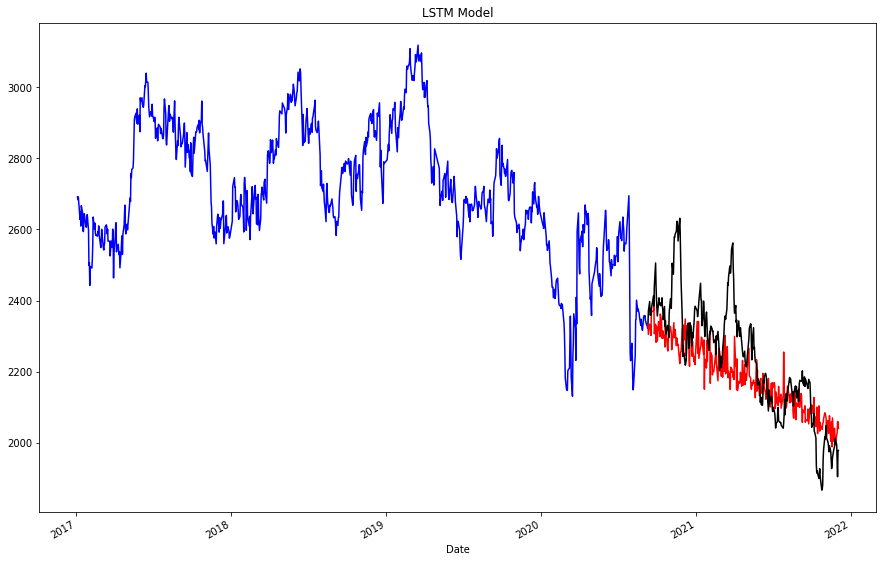

In [ ]:
tokyo_gas[:900].plot(color = 'blue', figsize=(15, 10))
LSTM_pred.plot(color='red')
tokyo_gas[-301:].plot(color = 'black')
plt.title('LSTM Model')
plt.show()

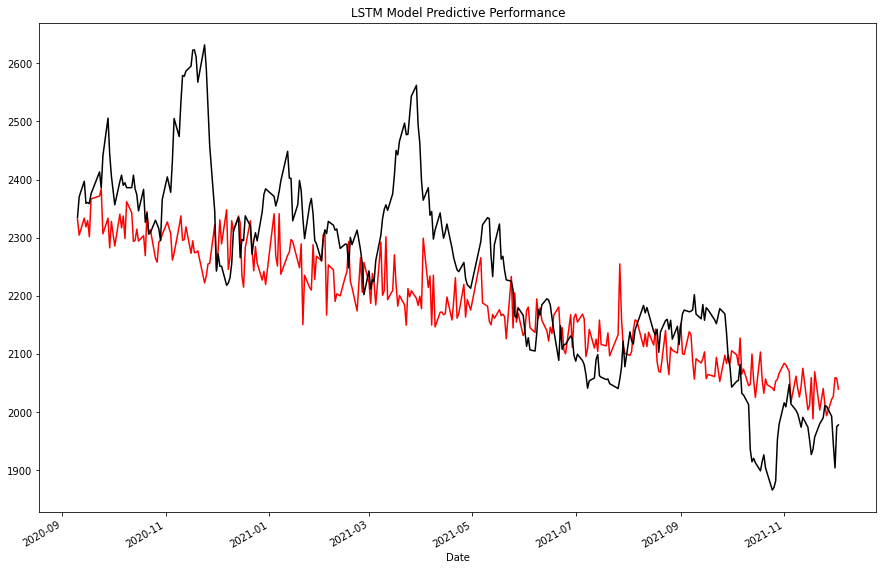

In [ ]:
LSTM_pred.plot(color='red', figsize=(15, 10))
tokyo_gas[-301:].plot(color = 'black')
plt.title('LSTM Model Predictive Performance')
plt.show()

In [ ]:
LSTM_TEST_MAE = mean_absolute_error(tokyo_gas[-301:], LSTM_pred)
LSTM_TEST_MSE = mean_squared_error(tokyo_gas[-301:], LSTM_pred)
LSTM_TEST_MAPE = mean_absolute_percentage_error(tokyo_gas[-301:], LSTM_pred, symmetric=False)
LSTM_TEST_SMAPE = mean_absolute_percentage_error(tokyo_gas[-301:], LSTM_pred)

/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


In [ ]:
print(f'LSTM TEST MAE: {LSTM_TEST_MAE}')
print(f'LSTM TEST MSE: {LSTM_TEST_MSE}')
print(f'LSTM TEST MAPE: {LSTM_TEST_MAPE}')
print(f'LSTM TEST SMAPE: {LSTM_TEST_SMAPE}')

LSTM TEST MAE: 88.87023723006645
LSTM TEST MSE: 14273.594674552101
LSTM TEST MAPE: 0.03885517634287059
LSTM TEST SMAPE: 0.03966203776120834


# Recursive model (ENEOS)
## Rolling model only applied to the stock ENEOS  because the runtime was too long when rolling model run on other stocks we picked
- Every points during test periods, assume that we can use past data at that point.

### Pre-processing

#### Pre-processing & stationarity check
- Original sereies is non-stationary / differenced series is stationary.
- There's no seasonality in the series.
- ACF/PACF indicates ARIMA(1,1,0) or ARIMA(0,1,1).

In [ ]:
# Take average of each week
eneos_weekly = eneos.resample("W").mean()

In [ ]:
# NA value in 2019-05-05 due to consecutive national holidays (called "Golden Week")
eneos_weekly[eneos_weekly.isna()]

Date
2019-05-05   NaN
Freq: W-SUN, Name: eneos, dtype: float64

In [ ]:
# Fill NA with interpolation
eneos_weekly = eneos_weekly.interpolate()

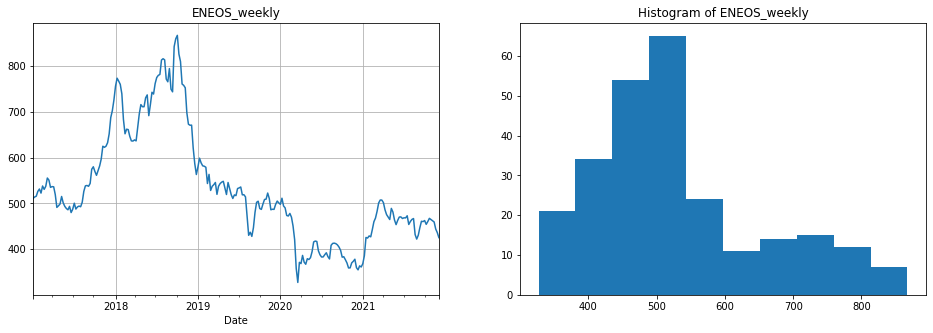


ADF/KPSS tests for ENEOS_weekly (alpha=0.05):
stationarity from ADF test: False
stationarity from KPSS test('c'): False
stationarity from KPSS test('ct'): False



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.402885    1.17686    0.264062
p-value               0.580892    0.01000    0.010000
Lags Used             1.000000   10.00000   10.000000
Critical Value (1%)  -3.456257    0.73900    0.216000
Critical Value (5%)  -2.872942    0.46300    0.146000
Critical Value (10%) -2.572846    0.34700    0.119000

In [ ]:
# Check stationarity
create_plot_adf_kpss(eneos_weekly, "ENEOS_weekly")

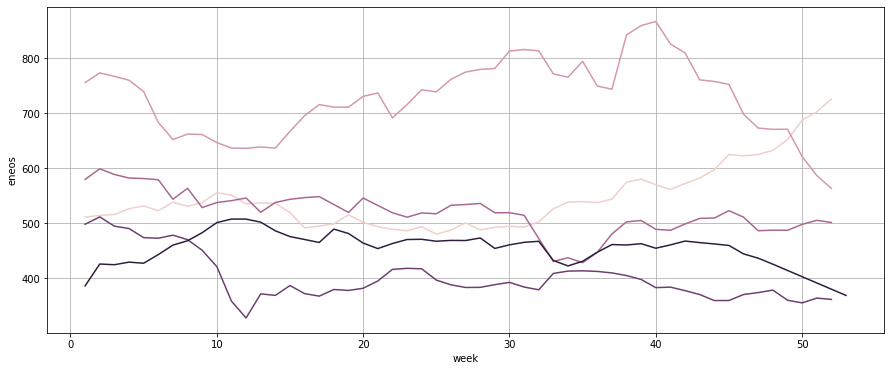

In [ ]:
# Check seasonality: No seasonality
df_season = pd.DataFrame(eneos_weekly)
df_season["year"] = df_season.index.year
df_season["week"] = df_season.index.week

# Line plot
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot("week", "eneos", data=df_season, hue="year", ax=ax, legend=None)
ax.grid()
plt.show()

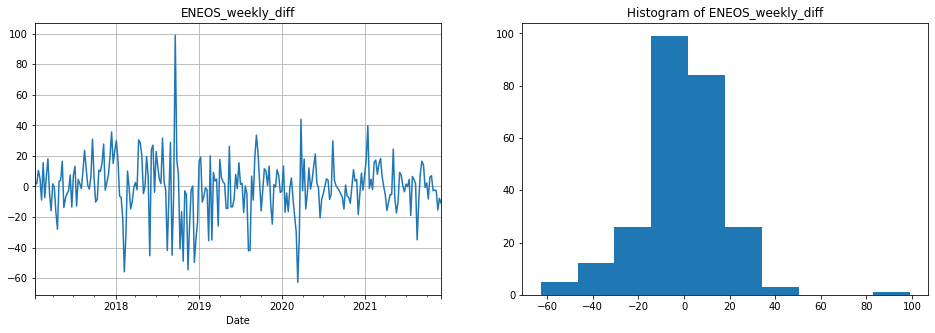


ADF/KPSS tests for ENEOS_weekly_diff (alpha=0.05):
stationarity from ADF test: True
stationarity from KPSS test('c'): True
stationarity from KPSS test('ct'): True



ADF  KPSS('c')  KPSS('ct')
Test Statistic       -1.243787e+01   0.138115    0.098419
p-value               3.811269e-23   0.100000    0.100000
Lags Used             0.000000e+00   3.000000    3.000000
Critical Value (1%)  -3.456257e+00   0.739000    0.216000
Critical Value (5%)  -2.872942e+00   0.463000    0.146000
Critical Value (10%) -2.572846e+00   0.347000    0.119000

In [ ]:
# Check stationarity for differenced data
create_plot_adf_kpss(eneos_weekly.diff().dropna(), "ENEOS_weekly_diff")

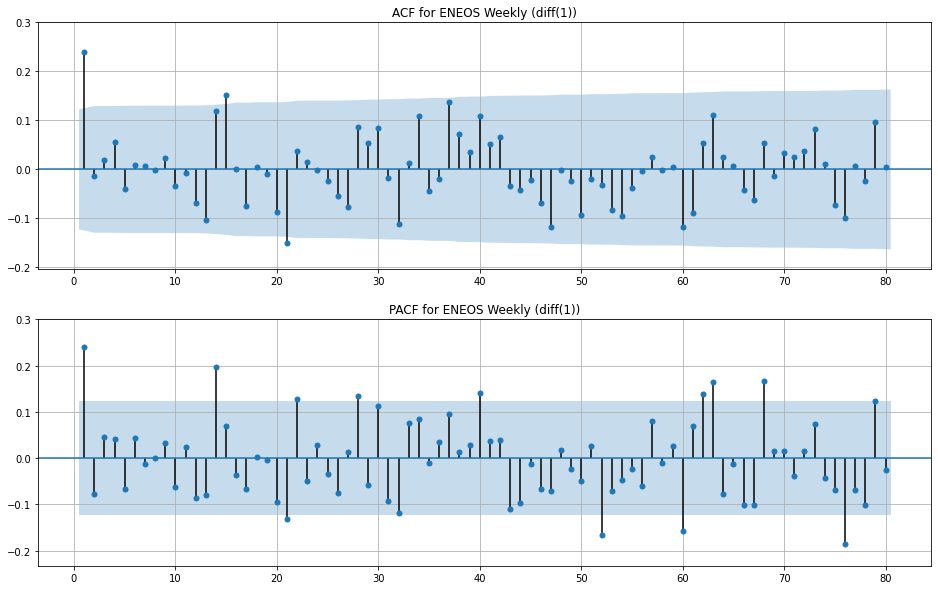

In [ ]:
plot_acf_pacf(eneos_weekly.diff().dropna(), "ENEOS Weekly (diff(1))", lags=80)

#### Pre-processing for external regressors
-  GDP (quarterly), unemployment rate (monthly): Forward fill
- Interest rate / Nikkei 225: interpolate for 2019-05-05 (same as eneos)


In [ ]:
# GDP
gdp_weekly = gdp_s.resample("W").mean().fillna(method="ffill")

In [ ]:
# unemplyment rate
unemp_weekly = unemp_s.resample("W").mean().fillna(method="ffill")

In [ ]:
# Oil Price
oil_weekly = oil_s.resample("W").mean()

In [ ]:
# JPY/USD
usdjpy_weekly = usdjpy_s.resample("W").mean()

In [ ]:
# Interest Rate (long-term)
interest_weekly = interest_s.resample("W").mean()

In [ ]:
# Find NAs for interest_weekly
interest_weekly[interest_weekly.isna()]

Date
2019-05-05   NaN
Freq: W-SUN, Name: jp_i, dtype: float64

In [ ]:
# Interpolation
interest_weekly = interest_weekly.interpolate()

In [ ]:
# Nikkei 225 index
n225_weekly = n225_s.resample("W").mean()

In [ ]:
# Find NAs
n225_weekly[n225_weekly.isna()]

Date
2019-05-05   NaN
Freq: W-SUN, Name: n225, dtype: float64

In [ ]:
# Interpolation
n225_weekly = n225_weekly.interpolate()

In [ ]:
# Merge data
weekly_m = pd.concat([eneos_weekly, gdp_weekly, unemp_weekly, oil_weekly, usdjpy_weekly, interest_weekly, n225_weekly], axis=1)

# Show rows with NAs => Need to fill jp_gdp (since last observation for gdp_weekly is for 2021-10-03)
weekly_m[weekly_m.isnull().any(axis=1)]

eneos    jp_gdp  jp_unemp        oil      usdjpy     jp_i  \
Date                                                                      
2017-01-01      NaN  547306.2       3.1        NaN         NaN      NaN   
2021-10-10  454.200       NaN       2.8  78.504000  111.295401  0.07200   
2021-10-17  460.300       NaN       2.8  81.176000  113.262399  0.08740   
2021-10-24  467.280       NaN       2.8  83.476000  114.278200  0.09280   
2021-10-31  464.500       NaN       2.8  83.844000  113.801801  0.09940   
2021-11-07  462.025       NaN       2.9  81.788000  114.039799  0.08300   
2021-11-14  459.300       NaN       2.9  81.930000  113.517799  0.06840   
2021-11-21  443.880       NaN       2.9  78.992000  114.297801  0.08020   
2021-11-28  436.075       NaN       2.9  77.793333  114.909200  0.08475   
2021-12-05  425.140       NaN       2.8  66.890000  113.345203  0.06980   
2021-12-12      NaN       NaN       NaN  71.314000  113.431400  0.05800   
2021-12-19      NaN       NaN       NaN  71.184000  113.724001  0.05820   
2021-12-26      NaN       NaN       NaN  71.625000  113.950601  0.06920   
2022-01-02      NaN       NaN       NaN  76.048000  114.781801  0.07950   

                    n225  
Date                      
2017-01-01           NaN  
2021-10-10  27904.605859  
2021-10-17  28497.729687  
2021-10-24  29001.992188  
2021-10-31  28903.487891  
2021-11-07  29643.479980  
2021-11-14  29357.424219  
2021-11-21  29723.555859  
2021-11-28  29331.916992  
2021-12-05  27964.847656  
2021-12-12  28481.365625  
2021-12-19  28628.970313  
2021-12-26  28519.714062  
2022-01-02  28861.053223

In [ ]:
# Drop rows when "eneos" is NA 
weekly_m = weekly_m.dropna(subset=["eneos"])

# Show rows with NAs
weekly_m[weekly_m.isnull().any(axis=1)]

eneos  jp_gdp  jp_unemp        oil      usdjpy     jp_i  \
Date                                                                    
2021-10-10  454.200     NaN       2.8  78.504000  111.295401  0.07200   
2021-10-17  460.300     NaN       2.8  81.176000  113.262399  0.08740   
2021-10-24  467.280     NaN       2.8  83.476000  114.278200  0.09280   
2021-10-31  464.500     NaN       2.8  83.844000  113.801801  0.09940   
2021-11-07  462.025     NaN       2.9  81.788000  114.039799  0.08300   
2021-11-14  459.300     NaN       2.9  81.930000  113.517799  0.06840   
2021-11-21  443.880     NaN       2.9  78.992000  114.297801  0.08020   
2021-11-28  436.075     NaN       2.9  77.793333  114.909200  0.08475   
2021-12-05  425.140     NaN       2.8  66.890000  113.345203  0.06980   

                    n225  
Date                      
2021-10-10  27904.605859  
2021-10-17  28497.729687  
2021-10-24  29001.992188  
2021-10-31  28903.487891  
2021-11-07  29643.479980  
2021-11-14  29357.424219  
2021-11-21  29723.555859  
2021-11-28  29331.916992  
2021-12-05  27964.847656

In [ ]:
# Fill NAs for jp_gdp with forward fill
weekly_m["jp_gdp"] = weekly_m["jp_gdp"].fillna(method="ffill")

# Show rows with NAs
weekly_m[weekly_m.isnull().any(axis=1)]

Empty DataFrame
Columns: [eneos, jp_gdp, jp_unemp, oil, usdjpy, jp_i, n225]
Index: []

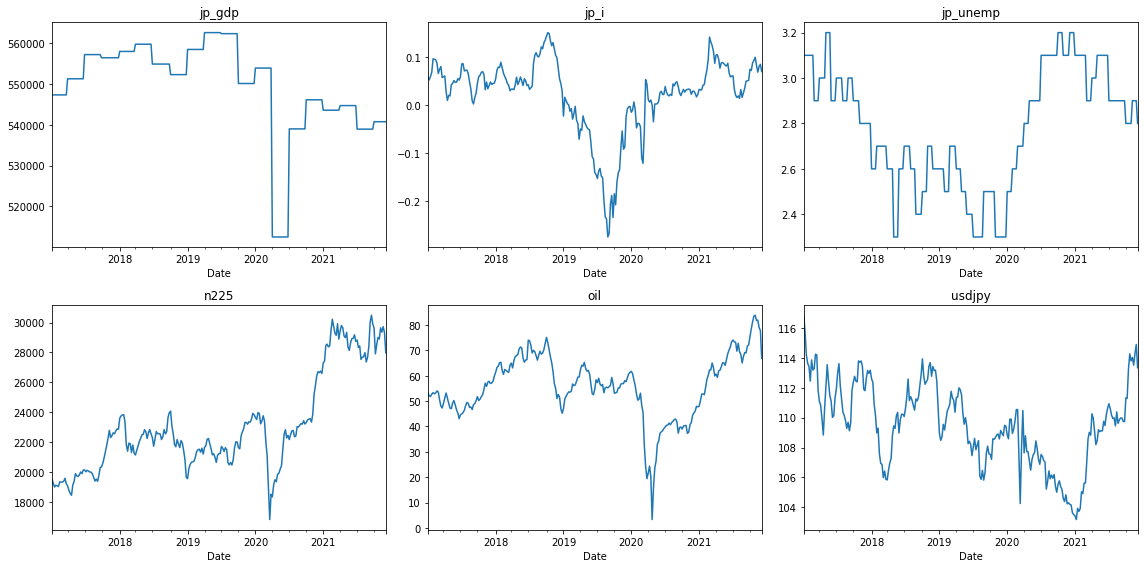

In [ ]:
# Plot external regressors
fig, axes = plt.subplots(2,3, figsize=(16,8), tight_layout=True)
axes_flat = [s for sublist in axes for s in sublist]
for i, c in enumerate(weekly_m.columns.difference(["eneos"])):
    weekly_m[c].plot(ax=axes_flat[i])
    axes_flat[i].set_title(c)
plt.show()

#### Data Splitting

In [ ]:
# Using data before June 2021 as training
df_train = weekly_m[:-23]
df_test = weekly_m[-23:]

In [ ]:
df_train

eneos    jp_gdp  jp_unemp      oil      usdjpy      jp_i  \
Date                                                                        
2017-01-08  510.933333  547306.2       3.1  53.3425  116.865399  0.058333   
2017-01-15  514.000000  547306.2       3.1  52.0660  115.753801  0.052250   
2017-01-22  515.660000  547306.2       3.1  51.8225  114.199800  0.059200   
2017-01-29  526.200000  547306.2       3.1  52.7420  113.635599  0.068200   
2017-02-05  531.400000  547306.2       3.1  53.3280  113.432199  0.096200   
...                ...       ...       ...      ...         ...       ...   
2021-05-30  453.560000  544693.4       3.1  66.3980  109.110199  0.081200   
2021-06-06  462.780000  544693.4       3.1  68.7425  109.750798  0.087000   
2021-06-13  470.080000  544693.4       3.1  70.1120  109.475800  0.067000   
2021-06-20  470.500000  544693.4       3.1  71.5460  110.185799  0.058600   
2021-06-27  466.940000  544693.4       3.1  73.4840  110.632399  0.060400   

                    n225  
Date                      
2017-01-08  19523.059896  
2017-01-15  19272.021973  
2017-01-22  19002.659766  
2017-01-29  19121.262109  
2017-02-05  19078.209766  
...                  ...  
2021-05-30  28651.839844  
2021-06-06  28924.037891  
2021-06-13  28950.178516  
2021-06-20  29175.304297  
2021-06-27  28742.272266  

[234 rows x 7 columns]

In [ ]:
df_test

eneos    jp_gdp  jp_unemp        oil      usdjpy      jp_i  \
Date                                                                          
2021-07-04  468.480000  538923.3       2.9  74.068000  110.931200  0.060800   
2021-07-11  468.260000  538923.3       2.9  73.345000  110.617801  0.033000   
2021-07-18  472.900000  538923.3       2.9  73.188000  110.179399  0.020600   
2021-07-25  453.900000  538923.3       2.9  69.684000  109.944598  0.015667   
2021-08-01  460.400000  538923.3       2.9  72.750000  109.990399  0.019000   
2021-08-08  464.960000  538923.3       2.9  69.500000  109.449399  0.014000   
2021-08-15  466.850000  538923.3       2.9  68.334000  110.388000  0.032250   
2021-08-22  431.860000  538923.3       2.9  65.048000  109.613600  0.015800   
2021-08-29  421.980000  538923.3       2.9  67.590000  109.854399  0.025800   
2021-09-05  430.480000  538923.3       2.9  69.150000  109.981200  0.035200   
2021-09-12  446.980000  538923.3       2.9  68.982500  109.975800  0.049600   
2021-09-19  460.880000  538923.3       2.9  71.688000  109.742001  0.050400   
2021-09-26  460.166667  538923.3       2.9  72.180000  109.740999  0.051333   
2021-10-03  462.480000  540745.2       2.8  75.454000  111.330598  0.074400   
2021-10-10  454.200000  540745.2       2.8  78.504000  111.295401  0.072000   
2021-10-17  460.300000  540745.2       2.8  81.176000  113.262399  0.087400   
2021-10-24  467.280000  540745.2       2.8  83.476000  114.278200  0.092800   
2021-10-31  464.500000  540745.2       2.8  83.844000  113.801801  0.099400   
2021-11-07  462.025000  540745.2       2.9  81.788000  114.039799  0.083000   
2021-11-14  459.300000  540745.2       2.9  81.930000  113.517799  0.068400   
2021-11-21  443.880000  540745.2       2.9  78.992000  114.297801  0.080200   
2021-11-28  436.075000  540745.2       2.9  77.793333  114.909200  0.084750   
2021-12-05  425.140000  540745.2       2.8  66.890000  113.345203  0.069800   

                    n225  
Date                      
2021-07-04  28828.495312  
2021-07-11  28333.359766  
2021-07-18  28435.583984  
2021-07-25  27529.633464  
2021-08-01  27690.235938  
2021-08-08  27711.017578  
2021-08-15  27987.707520  
2021-08-22  27365.598047  
2021-08-29  27666.914062  
2021-09-05  28400.293359  
2021-09-12  30029.454297  
2021-09-19  30490.514062  
2021-09-26  29909.307292  
2021-10-03  29638.408203  
2021-10-10  27904.605859  
2021-10-17  28497.729687  
2021-10-24  29001.992188  
2021-10-31  28903.487891  
2021-11-07  29643.479980  
2021-11-14  29357.424219  
2021-11-21  29723.555859  
2021-11-28  29331.916992  
2021-12-05  27964.847656

In [ ]:
# extract eneos sereis as y_train and y_test
y_train = df_train["eneos"]
y_test = df_test["eneos"]

#### Function

In [ ]:
# Make prediction with arima model from pmdarima
def predict_from_arima(arima_model, test_y, test_X=None):
    y_pred = arima_model.predict(n_periods=len(test_y), X=test_X)
    y_pred = pd.Series(y_pred)
    y_pred.index = test_y.index
    return y_pred

In [ ]:
# Make plot fro training/test/prediction
def make_plot(train_y, test_y, pred_y, title):
    fig, ax = plt.subplots(figsize=(16,5))
    train_y.plot(ax=ax, label="Training")
    test_y.plot(ax=ax, label="Test", color="black")
    pred_y.plot(ax=ax, label=title, linestyle="dashed")
    plt.legend()
    plt.show()

### Rolling Univariate ARIMA (3)

In [ ]:
# Function to run rolling fit
def rolling_arima3(train_y_raw, test_y_raw):

    # Series to store predicted values
    y_pred = pd.Series(name="eneos")

    # Set initial training / test data / prediction
    train_y = train_y_raw.copy()
    test_y = test_y_raw.copy()

    for i in range(len(test_y)):
        # Train ARIMA and make 1-step ahead forecast
        arima = auto_arima(train_y, start_p=0, d=1, start_q=0, seasonal=False)
        arima_order = arima.get_params()["order"]
        ypred = pd.Series(arima.predict(1), name="eneos", index=[test_y_raw.index[i]])

        # Store predicted value into y_pred
        y_pred = y_pred.append(ypred)

        # Add 1-step ahead true observation to train_y and drop first observation from train_y
        train_y = train_y.append(test_y[i:i+1])[1:]

        # Print progress      
        print(f"Index {i+1}: ARIMA{str(arima_order)} : Prediction: {ypred.index[0].strftime('%Y-%m-%d')} {ypred.values}")
    
    return y_pred

In [ ]:
pred_airma_rolling_uni3 = rolling_arima3(y_train, y_test)

Index 1: ARIMA(0, 1, 1) : Prediction: 2021-07-04 [466.04885912]
Index 2: ARIMA(0, 1, 1) : Prediction: 2021-07-11 [469.12423017]
Index 3: ARIMA(0, 1, 1) : Prediction: 2021-07-18 [468.03096663]
Index 4: ARIMA(0, 1, 1) : Prediction: 2021-07-25 [474.18261045]
Index 5: ARIMA(0, 1, 1) : Prediction: 2021-08-01 [448.54126388]
Index 6: ARIMA(0, 1, 1) : Prediction: 2021-08-08 [463.53587825]
Index 7: ARIMA(0, 1, 1) : Prediction: 2021-08-15 [465.33062447]
Index 8: ARIMA(0, 1, 1) : Prediction: 2021-08-22 [467.25361844]
Index 9: ARIMA(0, 1, 1) : Prediction: 2021-08-29 [422.5013441]
Index 10: ARIMA(0, 1, 1) : Prediction: 2021-09-05 [421.83617573]
Index 11: ARIMA(0, 1, 1) : Prediction: 2021-09-12 [432.76519871]
Index 12: ARIMA(0, 1, 1) : Prediction: 2021-09-19 [450.75625216]
Index 13: ARIMA(0, 1, 1) : Prediction: 2021-09-26 [463.58074917]
Index 14: ARIMA(0, 1, 1) : Prediction: 2021-10-03 [459.25553856]
Index 15: ARIMA(0, 1, 1) : Prediction: 2021-10-10 [463.32435339]
Index 16: ARIMA(0, 1, 1) : Predicti

Rolling ARIMA3 / No-exog


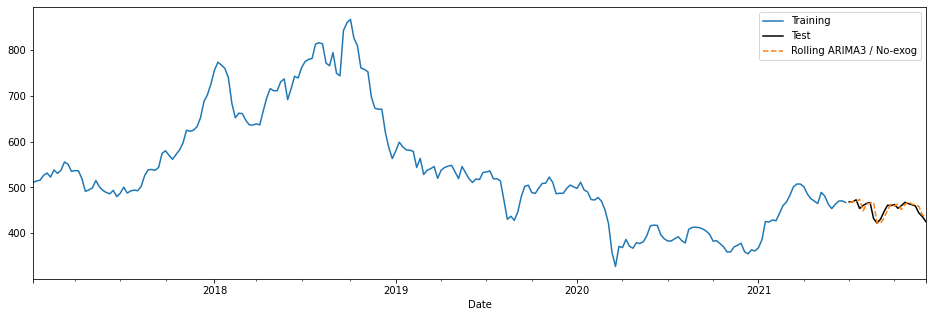

Test Error Metrics
MAE: 7.7174
MSE: 120.645
MAPE: 0.0172
sMAPE: 0.0171
MASE: 10.232


In [ ]:
print("Rolling ARIMA3 / No-exog")
make_plot(y_train, y_test, pred_airma_rolling_uni3, "Rolling ARIMA3 / No-exog")
metrics_airma_rolling_uni3 = calc_metrics(y_test, pred_airma_rolling_uni3, return_dict=True)

### Rolling Univariate ARIMA (4)
- Use last 52 observations instead of whole training data

In [ ]:
# Function to run rolling fit
def rolling_arima4(train_y_raw, test_y_raw):

    # Series to store predicted values
    y_pred = pd.Series(name="eneos")

    # Set initial training / test data / prediction
    train_y = train_y_raw.copy()[-52:]
    test_y = test_y_raw.copy()

    for i in range(len(test_y)):
        # Train ARIMA and make 1-step ahead forecast
        arima = auto_arima(train_y, start_p=0, d=1, start_q=0, seasonal=False)
        arima_order = arima.get_params()["order"]
        ypred = pd.Series(arima.predict(1), name="eneos", index=[test_y_raw.index[i]])

        # Store predicted value into y_pred
        y_pred = y_pred.append(ypred)

        # Add 1-step ahead true observation to train_y and drop first observation from train_y
        train_y = train_y.append(test_y[i:i+1])[1:]

        # Print progress      
        print(f"Index {i+1}: ARIMA{str(arima_order)} : Prediction: {ypred.index[0].strftime('%Y-%m-%d')} {ypred.values}")
    
    return y_pred

In [ ]:
pred_airma_rolling_uni4 = rolling_arima4(y_train, y_test)

Index 1: ARIMA(0, 1, 1) : Prediction: 2021-07-04 [465.92946759]
Index 2: ARIMA(0, 1, 1) : Prediction: 2021-07-11 [469.25236729]
Index 3: ARIMA(0, 1, 1) : Prediction: 2021-07-18 [467.96385521]
Index 4: ARIMA(1, 1, 0) : Prediction: 2021-07-25 [474.3483901]
Index 5: ARIMA(1, 1, 0) : Prediction: 2021-08-01 [448.3256459]
Index 6: ARIMA(1, 1, 0) : Prediction: 2021-08-08 [462.49101024]
Index 7: ARIMA(1, 1, 0) : Prediction: 2021-08-15 [466.35811465]
Index 8: ARIMA(1, 1, 0) : Prediction: 2021-08-22 [467.42946451]
Index 9: ARIMA(0, 1, 0) : Prediction: 2021-08-29 [431.86]
Index 10: ARIMA(1, 1, 0) : Prediction: 2021-09-05 [419.0842712]
Index 11: ARIMA(0, 1, 1) : Prediction: 2021-09-12 [432.80907358]
Index 12: ARIMA(0, 1, 1) : Prediction: 2021-09-19 [450.94037173]
Index 13: ARIMA(1, 1, 0) : Prediction: 2021-09-26 [465.10402167]
Index 14: ARIMA(0, 1, 1) : Prediction: 2021-10-03 [459.12547473]
Index 15: ARIMA(0, 1, 1) : Prediction: 2021-10-10 [463.45498001]
Index 16: ARIMA(0, 1, 1) : Prediction: 2021

Rolling ARIMA4 / No-exog


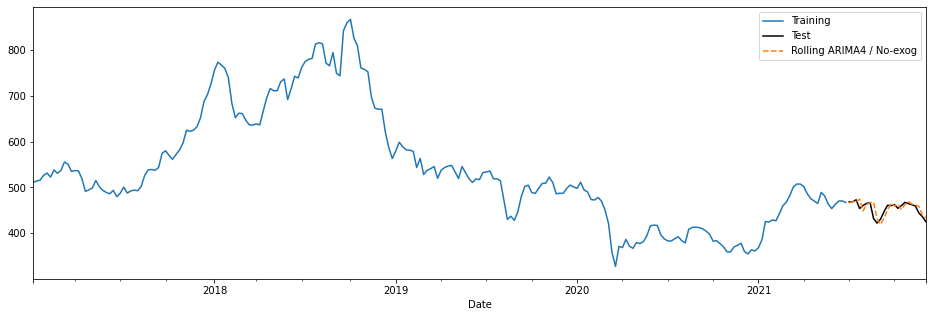

Test Error Metrics
MAE: 8.2791
MSE: 127.8672
MAPE: 0.0185
sMAPE: 0.0184
MASE: 10.9768


In [ ]:
print("Rolling ARIMA4 / No-exog")
make_plot(y_train, y_test, pred_airma_rolling_uni4, "Rolling ARIMA4 / No-exog")
metrics_airma_rolling_uni4 = calc_metrics(y_test, pred_airma_rolling_uni4, return_dict=True)

### Rolling ARIMAX with External Regressors (3) [link text](https:// [link text](https://))

In [ ]:
# Function to run rolling fit
def rolling_arimax3(exog_list, train_df=df_train, test_df=df_test, verbose=False):
    """
    Input:
        (1) exog_list: column names for external regressors
        (2) train_df: df_train
        (3) test_df: df for extracting index / exog for training
    Process:
        (1) Build model using auto_arima() and whole training data (eneos + external regressors)
        (2) Make one-step ahead prediction for external regressors using actual values available at the point of prediction
        (3) Use model from (1) and external regressors from (2) to make one-step ahead prediction for eneos
        (4) Store predicted eneos and predicted external regressors as training data
        (5) Repeat (1) through (4) over test data periods
    Outoput:
        - Prediction for Eneos (23-step ahead)
    """
    # Extract eneos from train/test df as train_y and test_y
    train_y = train_df.copy()["eneos"]
    test_y = test_df.copy()["eneos"]

    # Create df for external regressors (Use whole trainig data)
    df_X = train_df.copy()[exog_list]

    # Series to store predicted values
    y_pred = pd.Series(name="eneos")

    for i in range(test_df.shape[0]):
        # Create ARIMAX model using training eneos and external regressors (df_X)
        arimax = auto_arima(train_y, X=df_X, start_p=0, d=1, start_q=0, seasonal=False)
        arimax_order = arimax.get_params()["order"]

        # Create df for predicted external regressors
        df_pred_exog = pd.DataFrame(columns=exog_list, index=[test_df.index[i]])

        # Make one-step ahead forecast for external regressors
        for c in exog_list:
            arima_exog = auto_arima(df_X[c], start_p=0, d=1, start_q=0, seasonal=False)
            pred_exog = arima_exog.predict(n_periods=1)
            df_pred_exog[c] = pred_exog
        
        # Make prediction
        ypred = arimax.predict(n_periods=1, X=df_pred_exog)
        ypred = pd.Series(ypred, name="eneos", index=[test_df.index[i]])

        # Store predicted value into y_pred
        y_pred = y_pred.append(ypred)

        # Add 1-step ahead true observation to train_y and drop first observation from train_y
        train_y = train_y.append(test_y[i:i+1])[1:]

        # Add 1-step ahead true external regressors into df_X and drop first observation from df_X
        df_X = df_X.append(test_df.copy().iloc[i][exog_list])[1:]

        # Print progress
        if verbose:
            print(f"Index {i + 1}")
            print(f"     ARIMAX{str(arimax_order)} : Prediction: {ypred.index[0].strftime('%Y-%m-%d')} {ypred.values}")
            print("     One-step ahead forecast for External Regressors:")
            display(df_pred_exog)
    
    return y_pred

#### All External regressors

In [ ]:
pred_rolling_arimax_all3 = rolling_arimax3(exog_list=['jp_gdp', 'jp_unemp', 'oil', 'usdjpy', 'jp_i', 'n225'], verbose=True)

Index 1
     ARIMAX(0, 1, 1) : Prediction: 2021-07-04 [465.91477323]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-07-04  544693.4       3.1  73.904943  110.552615  0.060778  28651.033847

Index 2
     ARIMAX(0, 1, 1) : Prediction: 2021-07-11 [467.89726752]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-07-11  538923.3       2.9  74.110167  110.879991  0.060803  28858.915501

Index 3
     ARIMAX(0, 1, 1) : Prediction: 2021-07-18 [467.33418279]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-07-18  538923.3       2.9  73.147407  110.534072  0.029448  28225.604976

Index 4
     ARIMAX(0, 1, 1) : Prediction: 2021-07-25 [474.06311931]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i         n225
2021-07-25  538923.3       2.9  73.198394  110.197102  0.019372  28475.57012

Index 5
     ARIMAX(0, 1, 1) : Prediction: 2021-08-01 [450.19378469]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil     usdjpy      jp_i          n225
2021-08-01  538923.3       2.9  68.778817  110.00473  0.015115  27367.662905

Index 6
     ARIMAX(0, 1, 1) : Prediction: 2021-08-08 [463.17176243]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i         n225
2021-08-08  538923.3       2.9  73.730575  110.040719  0.019578  27759.97867

Index 7
     ARIMAX(0, 1, 1) : Prediction: 2021-08-15 [464.46909374]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-08-15  538923.3       2.9  68.513237  109.380316  0.013173  27703.860008

Index 8
     ARIMAX(0, 1, 1) : Prediction: 2021-08-22 [467.44840949]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy     jp_i          n225
2021-08-22  538923.3       2.9  68.291897  110.592858  0.03225  28039.377361

Index 9
     ARIMAX(0, 1, 1) : Prediction: 2021-08-29 [425.91171047]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-08-29  538923.3       2.9  64.286315  109.358079  0.0158  27256.389598

Index 10
     ARIMAX(0, 1, 1) : Prediction: 2021-09-05 [422.51938531]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-09-05  538923.3       2.9  68.327579  110.015825  0.0258  27748.853309

Index 11
     ARIMAX(0, 1, 1) : Prediction: 2021-09-12 [431.77977365]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-09-12  538923.3       2.9  69.335438  109.951308  0.0352  28506.469404

Index 12
     ARIMAX(0, 1, 1) : Prediction: 2021-09-19 [449.87442377]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-09-19  538923.3       2.9  68.902585  109.952471  0.0496  30312.484859

Index 13
     ARIMAX(0, 1, 1) : Prediction: 2021-09-26 [463.03152018]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp       oil      usdjpy    jp_i          n225
2021-09-26  538923.3       2.9  72.31478  109.722053  0.0504  30524.521575

Index 14
     ARIMAX(0, 1, 1) : Prediction: 2021-10-03 [459.45598211]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-10-03  538923.3       2.9  72.151752  109.784679  0.051333  29792.865017

Index 15
     ARIMAX(0, 1, 1) : Prediction: 2021-10-10 [462.17379157]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-10-10  540745.2       2.8  76.185142  111.464668  0.0744  29589.177257

Index 16
     ARIMAX(0, 1, 1) : Prediction: 2021-10-17 [450.42288851]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i          n225
2021-10-17  540745.2       2.8  79.192979  111.012492  0.072  27509.708505

Index 17
     ARIMAX(0, 1, 1) : Prediction: 2021-10-24 [461.2741628]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-10-24  540745.2       2.8  81.784506  113.415063  0.0874  28604.580802

Index 18
     ARIMAX(0, 1, 1) : Prediction: 2021-10-31 [467.31047581]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-10-31  540745.2       2.8  84.005536  113.945806  0.0928  29065.758955

Index 19
     ARIMAX(0, 1, 1) : Prediction: 2021-11-07 [464.17870306]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-07  540745.2       2.8  83.928965  113.776244  0.0994  28876.920802

Index 20
     ARIMAX(0, 1, 1) : Prediction: 2021-11-14 [462.44274815]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i         n225
2021-11-14  540745.2       2.9  81.316586  114.134864  0.083  29773.53907

Index 21
     ARIMAX(0, 1, 1) : Prediction: 2021-11-21 [458.89018475]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-21  540745.2       2.9  81.962652  113.392382  0.0684  29309.477076

Index 22
     ARIMAX(0, 1, 1) : Prediction: 2021-11-28 [441.77058407]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-28  540745.2       2.9  78.321511  114.493276  0.0802  29801.798751

Index 23
     ARIMAX(0, 1, 1) : Prediction: 2021-12-05 [434.39410034]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy     jp_i          n225
2021-12-05  540745.2       2.9  77.520128  114.762155  0.08475  29272.477744

Rolling ARIMAX3 / all exog


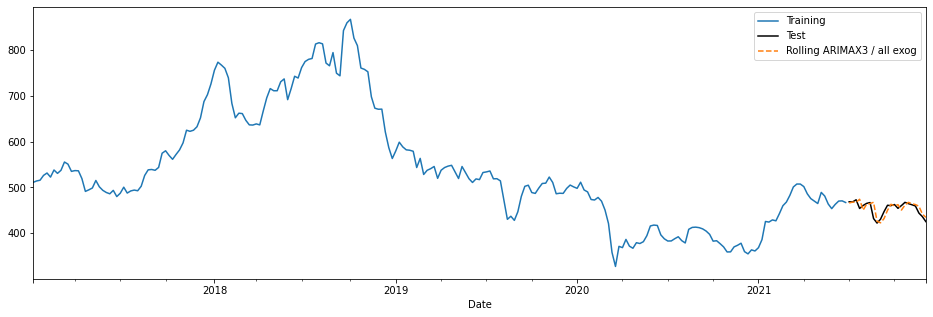

Test Error Metrics
MAE: 8.0231
MSE: 123.2682
MAPE: 0.0179
sMAPE: 0.0178
MASE: 10.6373


In [ ]:
print("Rolling ARIMAX3 / all exog")
make_plot(y_train, y_test, pred_rolling_arimax_all3, "Rolling ARIMAX3 / all exog")
metrics_rolling_arimax_all3 = calc_metrics(y_test, pred_rolling_arimax_all3, return_dict=True)

#### only n225

In [ ]:
pred_rolling_arimax_n2253 = rolling_arimax3(exog_list=['n225'], verbose=False)

Rolling ARIMAX3 / n225


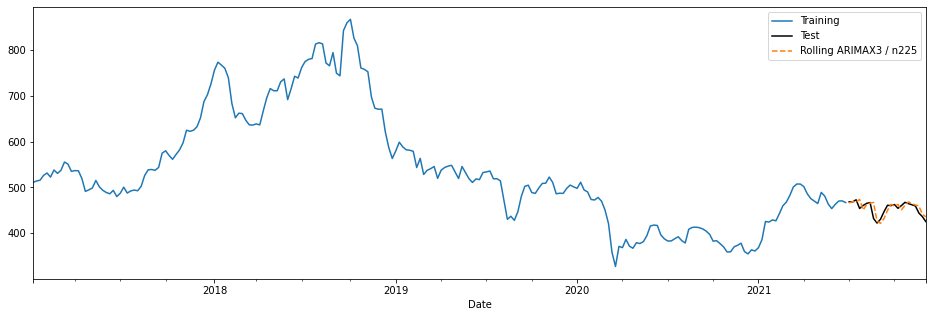

Test Error Metrics
MAE: 8.0718
MSE: 124.1081
MAPE: 0.0181
sMAPE: 0.0179
MASE: 10.7018


In [ ]:
print("Rolling ARIMAX3 / n225")
make_plot(y_train, y_test, pred_rolling_arimax_n2253, "Rolling ARIMAX3 / n225")
metrics_rolling_arimax_n2253 = calc_metrics(y_test, pred_rolling_arimax_n2253, return_dict=True)

#### oil & usdjpy

In [ ]:
pred_rolling_arimax_oilusdjpy3 = rolling_arimax3(exog_list=['oil', 'usdjpy'], verbose=False)

Rolling ARIMAX3 / Oil & USDJPY


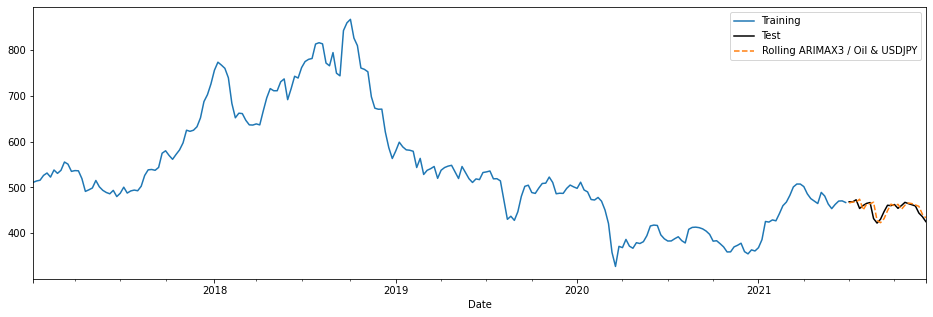

Test Error Metrics
MAE: 7.8984
MSE: 122.567
MAPE: 0.0177
sMAPE: 0.0175
MASE: 10.472


In [ ]:
print("Rolling ARIMAX3 / Oil & USDJPY")
make_plot(y_train, y_test, pred_rolling_arimax_oilusdjpy3, "Rolling ARIMAX3 / Oil & USDJPY")
metrics_rolling_arimax_oilusdjpy3 = calc_metrics(y_test, pred_rolling_arimax_oilusdjpy3, return_dict=True)

#### GDP & Unemp

In [ ]:
pred_rolling_arimax_gdpunemp3 = rolling_arimax3(exog_list=['jp_gdp', 'jp_unemp'], verbose=False)

Rolling ARIMAX3 / GDP & Unemp


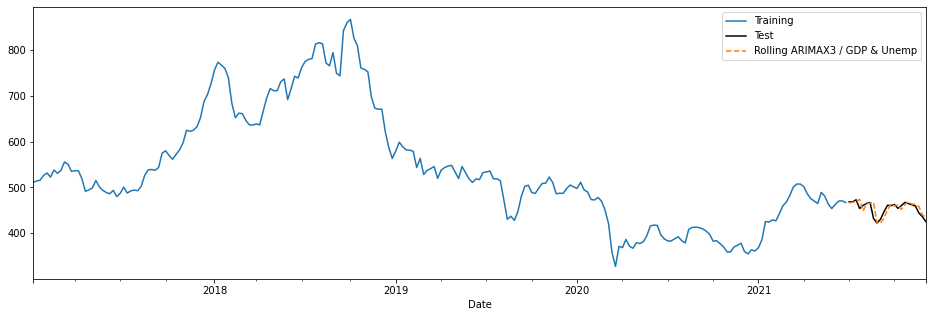

Test Error Metrics
MAE: 7.6359
MSE: 118.8654
MAPE: 0.0171
sMAPE: 0.0169
MASE: 10.1239


In [ ]:
print("Rolling ARIMAX3 / GDP & Unemp")
make_plot(y_train, y_test, pred_rolling_arimax_gdpunemp3, "Rolling ARIMAX3 / GDP & Unemp")
metrics_rolling_arimax_gdpunemp3 = calc_metrics(y_test, pred_rolling_arimax_gdpunemp3, return_dict=True)

### Rolling ARIMAX with External Regressors (4)

In [ ]:
# Function to run rolling fit
def rolling_arimax4(exog_list, train_df=df_train, test_df=df_test, verbose=False):
    """
    ***** Rolling ARIMAX(3) uses whole training data, while Rolling ARIMAX(4) uses 52 latest values for prediction  *****
    Input:
        (1) exog_list: column names for external regressors
        (2) train_df: df_train
        (3) test_df: df for extracting index / exog for training
    Process:
        (1) Build model using auto_arima() and whole training data (eneos + external regressors / use only 52 latest values)
        (2) Make one-step ahead prediction for external regressors using actual values available at the point of prediction
        (3) Use model from (1) and external regressors from (2) to make one-step ahead prediction for eneos
        (4) Store predicted eneos and predicted external regressors as training data
        (5) Repeat (1) through (4) over test data periods
    Outoput:
        - Prediction for Eneos (23-step ahead)
    """
    # Extract eneos from train/test df as train_y and test_y (use last 52 values for train_y)
    train_y = train_df.copy()[-52:]["eneos"]
    test_y = test_df.copy()["eneos"]

    # Create df for external regressors (Use last 52 values)
    df_X = train_df.copy()[-52:][exog_list]

    # Series to store predicted values
    y_pred = pd.Series(name="eneos")

    for i in range(test_df.shape[0]):
        # Create ARIMAX model using training eneos and external regressors (df_X)
        arimax = auto_arima(train_y, X=df_X, start_p=0, d=1, start_q=0, seasonal=False)
        arimax_order = arimax.get_params()["order"]

        # Create df for predicted external regressors
        df_pred_exog = pd.DataFrame(columns=exog_list, index=[test_df.index[i]])

        # Make one-step ahead forecast for external regressors
        for c in exog_list:
            arima_exog = auto_arima(df_X[c], start_p=0, d=1, start_q=0, seasonal=False)
            pred_exog = arima_exog.predict(n_periods=1)
            df_pred_exog[c] = pred_exog
        
        # Make prediction
        ypred = arimax.predict(n_periods=1, X=df_pred_exog)
        ypred = pd.Series(ypred, name="eneos", index=[test_df.index[i]])

        # Store predicted value into y_pred
        y_pred = y_pred.append(ypred)

        # Add 1-step ahead true observation to train_y and drop first observation from train_y
        train_y = train_y.append(test_y[i:i+1])[1:]

        # Add 1-step ahead true external regressors into df_X and drop first observation from df_X
        df_X = df_X.append(test_df.copy().iloc[i][exog_list])[1:]

        # Print progress
        if verbose:
            print(f"Index {i + 1}")
            print(f"     ARIMAX{str(arimax_order)} : Prediction: {ypred.index[0].strftime('%Y-%m-%d')} {ypred.values}")
            print("     One-step ahead forecast for External Regressors:")
            display(df_pred_exog)
    
    return y_pred

#### All External regressors

In [ ]:
pred_rolling_arimax_all4 = rolling_arimax4(exog_list=['jp_gdp', 'jp_unemp', 'oil', 'usdjpy', 'jp_i', 'n225'], verbose=True)

Index 1
     ARIMAX(0, 1, 0) : Prediction: 2021-07-04 [468.85475778]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i         n225
2021-07-04  544693.4       3.1  74.143539  110.632399  0.0604  28871.11152

Index 2
     ARIMAX(0, 1, 0) : Prediction: 2021-07-11 [470.37104768]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil    usdjpy    jp_i          n225
2021-07-11  538923.3       2.9  74.727333  110.9312  0.0608  28952.238833

Index 3
     ARIMAX(0, 1, 0) : Prediction: 2021-07-18 [470.00972894]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i         n225
2021-07-18  538923.3       2.9  73.987647  110.617801  0.033  28442.70396

Index 4
     ARIMAX(0, 1, 0) : Prediction: 2021-07-25 [474.63855928]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp       oil      usdjpy    jp_i          n225
2021-07-25  538923.3       2.9  73.81251  110.179399  0.0206  28546.390791

Index 5
     ARIMAX(0, 1, 0) : Prediction: 2021-08-01 [455.57135168]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-08-01  538923.3       2.9  70.252588  109.944598  0.015667  27630.922079

Index 6
     ARIMAX(1, 1, 2) : Prediction: 2021-08-08 [463.54081244]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i         n225
2021-08-08  538923.3       2.9  73.361412  109.990399  0.019  27793.84064

Index 7
     ARIMAX(0, 1, 1) : Prediction: 2021-08-15 [469.58547707]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i          n225
2021-08-15  538923.3       2.9  70.037725  109.449399  0.014  27711.017578

Index 8
     ARIMAX(1, 1, 0) : Prediction: 2021-08-22 [468.58825959]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil   usdjpy     jp_i          n225
2021-08-22  538923.3       2.9  68.836118  110.388  0.03225  28085.272924

Index 9
     ARIMAX(1, 1, 2) : Prediction: 2021-08-29 [421.50703324]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil    usdjpy    jp_i          n225
2021-08-29  538923.3       2.9  65.481647  109.6136  0.0158  27365.598047

Index 10
     ARIMAX(1, 1, 2) : Prediction: 2021-09-05 [418.42460147]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-09-05  538923.3       2.9  68.094863  109.854399  0.0258  27666.914062

Index 11
     ARIMAX(1, 1, 2) : Prediction: 2021-09-12 [434.93178222]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil    usdjpy    jp_i          n225
2021-09-12  538923.3       2.9  69.773039  109.9812  0.0352  28502.108601

Index 12
     ARIMAX(0, 1, 3) : Prediction: 2021-09-19 [453.68096809]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil    usdjpy    jp_i         n225
2021-09-19  538923.3       2.9  69.559529  109.9758  0.0496  30158.77932

Index 13
     ARIMAX(1, 1, 2) : Prediction: 2021-09-26 [464.4047016]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-09-26  538923.3       2.9  72.313647  109.742001  0.0504  30633.210876

Index 14
     ARIMAX(1, 1, 2) : Prediction: 2021-10-03 [467.00260623]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy      jp_i          n225
2021-10-03  538923.3       2.9  72.830745  109.740999  0.051333  30038.579306

Index 15
     ARIMAX(1, 1, 2) : Prediction: 2021-10-10 [455.94011783]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp       oil      usdjpy    jp_i          n225
2021-10-10  540745.2       2.8  76.14549  111.330598  0.0744  29759.022281

Index 16
     ARIMAX(0, 1, 3) : Prediction: 2021-10-17 [456.90419329]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp       oil      usdjpy   jp_i          n225
2021-10-17  540745.2       2.8  79.25251  111.295401  0.072  27904.605859

Index 17
     ARIMAX(0, 1, 3) : Prediction: 2021-10-24 [463.24581137]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp       oil      usdjpy    jp_i          n225
2021-10-24  540745.2       2.8  81.97502  113.420599  0.0874  28497.729687

Index 18
     ARIMAX(0, 1, 1) : Prediction: 2021-10-31 [469.26151881]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-10-31  540745.2       2.8  84.381098  114.468247  0.0928  29001.992188

Index 19
     ARIMAX(0, 1, 1) : Prediction: 2021-11-07 [466.08425237]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-07  540745.2       2.8  84.748627  113.986573  0.0994  28886.404453

Index 20
     ARIMAX(0, 1, 1) : Prediction: 2021-11-14 [463.90703547]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy   jp_i         n225
2021-11-14  540745.2       2.9  82.594471  114.220364  0.083  29643.47998

Index 21
     ARIMAX(0, 1, 1) : Prediction: 2021-11-21 [460.80152421]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-21  540745.2       2.9  82.722431  113.700043  0.0684  29357.424219

Index 22
     ARIMAX(0, 1, 1) : Prediction: 2021-11-28 [442.14873412]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy    jp_i          n225
2021-11-28  540745.2       2.9  79.670275  114.493848  0.0802  29723.555859

Index 23
     ARIMAX(1, 1, 2) : Prediction: 2021-12-05 [444.98068675]
     One-step ahead forecast for External Regressors:


jp_gdp  jp_unemp        oil      usdjpy     jp_i          n225
2021-12-05  540745.2       2.9  78.429085  115.119297  0.08475  29331.916992

Rolling ARIMAX4 / all exog


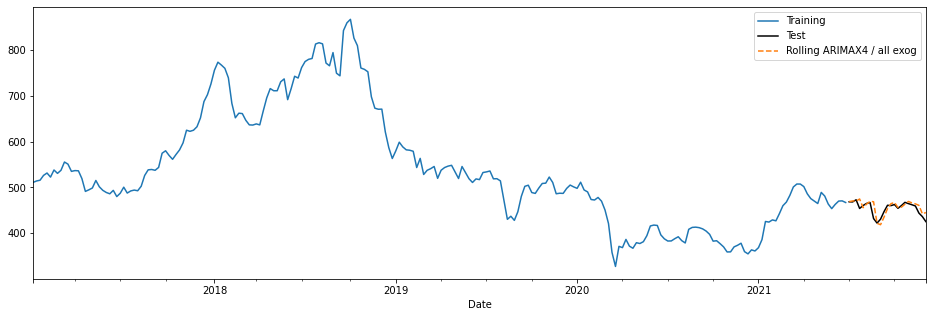

Test Error Metrics
MAE: 7.7303
MSE: 131.0375
MAPE: 0.0174
sMAPE: 0.0171
MASE: 10.2491


In [ ]:
print("Rolling ARIMAX4 / all exog")
make_plot(y_train, y_test, pred_rolling_arimax_all4, "Rolling ARIMAX4 / all exog")
metrics_rolling_arimax_all4 = calc_metrics(y_test, pred_rolling_arimax_all4, return_dict=True)

#### only n225

In [ ]:
pred_rolling_arimax_n2254 = rolling_arimax4(exog_list=['n225'], verbose=False)

Rolling ARIMAX4 / n225


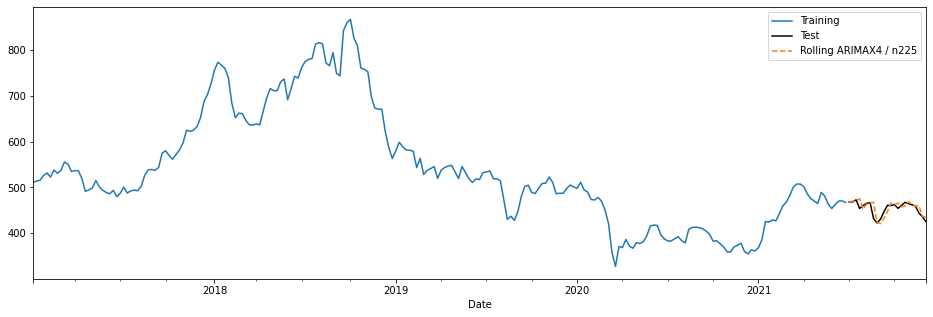

Test Error Metrics
MAE: 7.411
MSE: 127.3857
MAPE: 0.0166
sMAPE: 0.0164
MASE: 9.8258


In [ ]:
print("Rolling ARIMAX4 / n225")
make_plot(y_train, y_test, pred_rolling_arimax_n2254, "Rolling ARIMAX4 / n225")
metrics_rolling_arimax_n2254 = calc_metrics(y_test, pred_rolling_arimax_n2254, return_dict=True)

#### oil & usdjpy

In [ ]:
pred_rolling_arimax_oilusdjpy4 = rolling_arimax4(exog_list=['oil', 'usdjpy'], verbose=False)

Rolling ARIMAX4 / Oil & USDJPY


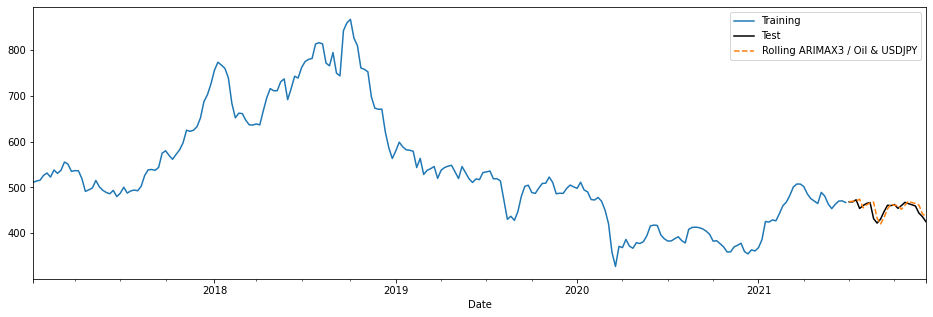

Test Error Metrics
MAE: 8.2142
MSE: 127.4794
MAPE: 0.0185
sMAPE: 0.0182
MASE: 10.8906


In [ ]:
print("Rolling ARIMAX4 / Oil & USDJPY")
make_plot(y_train, y_test, pred_rolling_arimax_oilusdjpy4, "Rolling ARIMAX3 / Oil & USDJPY")
metrics_rolling_arimax_oilusdjpy4 = calc_metrics(y_test, pred_rolling_arimax_oilusdjpy4, return_dict=True)

#### GDP & Unemp

In [ ]:
pred_rolling_arimax_gdpunemp4 = rolling_arimax4(exog_list=['jp_gdp', 'jp_unemp'], verbose=False)

Rolling ARIMAX4 / GDP & Unemp


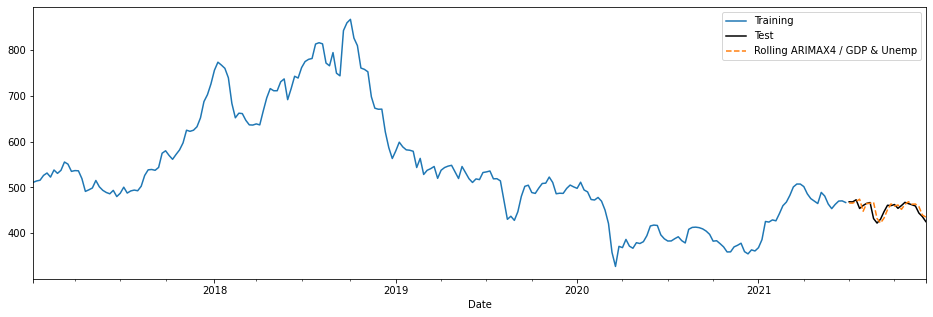

Test Error Metrics
MAE: 8.084
MSE: 123.1674
MAPE: 0.0181
sMAPE: 0.0179
MASE: 10.718


In [ ]:
print("Rolling ARIMAX4 / GDP & Unemp")
make_plot(y_train, y_test, pred_rolling_arimax_gdpunemp4, "Rolling ARIMAX4 / GDP & Unemp")
metrics_rolling_arimax_gdpunemp4 = calc_metrics(y_test, pred_rolling_arimax_gdpunemp4, return_dict=True)

### Rolling VAR

In [ ]:
# Library
from statsmodels.tsa.vector_ar.var_model import VAR

# Function to run VAR
def rolling_var(exog_list, train_diff_raw=df_train_diff, test_diff_raw=df_test_diff, train_raw=df_train, verbose=False):
    """
    Input:
        (1) exog_list: column names for external regressors
        (2) train_diff_raw: df_train_diff (differenced training data)
        (3) test_diff_raw: df for extracting index / exog for training
        (4) train_raw: df_train (non-differenced training data)
    Process:
        (1) Build model using VAR() with optimal order p in terms of AIC using whole differenced training data
        (2) Make one-step ahead prediction & Store predicted values
        (3) Add 1-step ahead true values into differenced training data and drop first observation from it
        (5) Repeat (1) through (3) over test data periods
    Outoput:
        - Prediction for Eneos (23-step ahead)
    """
    # Slice data by eneos and specified exog
    train_diff = train_diff_raw[["eneos"] + exog_list]
    test_diff = test_diff_raw[["eneos"] + exog_list]
    train = train_raw[["eneos"] + exog_list]

    # DF to store predicted values
    df_pred = pd.DataFrame(columns=train.columns)

    # Fit var model and make 1-step ahead prediction
    for i in range(test_diff.shape[0]):

        # Create instance
        var_model=VAR(train_diff)

        # Run VAR with different order (1-20)
        results_aic =[]
        for p in range(1,21):
            results = var_model.fit(p)
            results_aic.append(results.aic)

        # Store optimal p order
        optimal_p = list(np.arange(1,21,1))[np.argmin(results_aic)]

        # Refit var with optimal p
        best_var = var_model.fit(optimal_p)

        # Make 1-step ahead forecast
        yhat_var = best_var.forecast(var_model.endog, steps=1)

        # clean up yhat
        df_yhat_var = pd.DataFrame(yhat_var)
        df_yhat_var.index = [test_diff.index[i]]
        df_yhat_var.columns = test_diff.columns
 

        # Store df_yhat_var
        df_pred = df_pred.append(df_yhat_var)

        # Add actual 1-steap ahead actual test data into training set and drop 1st observation from training data
        train_diff = train_diff.append(test_diff.copy().iloc[i])[1:]
       
        # Print progress
        if verbose:
            print(f"Index {i + 1}")
            print("Optimal p with minimum AIC: ", optimal_p)
            print("One-step ahead forecast (differened data)")
            display(df_yhat_var)
    
    # Recover first order differencing
    df_pred_var = pd.concat([train.tail(1), df_pred], axis=0).cumsum()
    df_pred_var = df_pred_var[-23:]

    # Extract predictions for eneos
    y_pred_var = df_pred_var["eneos"]

    # Return prediction
    return y_pred_var

#### All external regressors

In [ ]:
pred_rolling_var_all = rolling_var(exog_list=['jp_gdp', 'jp_unemp', 'oil', 'usdjpy', 'jp_i', 'n225'], verbose=True)

Index 1
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-04 -1.513281  2256.425159 -0.007604 -0.876597  0.122273 -0.006571   

                 n225  
2021-07-04 -58.545145

Index 2
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-11  0.790945  379.409512 -0.007532 -0.236408  0.088532 -0.004658   

                 n225  
2021-07-11  130.51646

Index 3
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos     jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-18  1.780447 -62.975103  0.008574 -1.289651  0.061688  0.001161   

                 n225  
2021-07-18  39.305007

Index 4
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-25  2.142438  105.790606  0.005648 -1.660954 -0.272097 -0.000332   

                 n225  
2021-07-25  58.499436

Index 5
Optimal p with minimum AIC:  4
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp      oil    usdjpy      jp_i  \
2021-08-01 -9.598102  3509.557975  0.052101 -1.14103  0.540356  0.004722   

                  n225  
2021-08-01 -246.397448

Index 6
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-08  5.806878 -407.818371 -0.014193  0.187219 -0.041772  0.002207   

                  n225  
2021-08-08  140.619358

Index 7
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-15 -4.06812 -2443.752324  0.021735 -0.613647  0.051894  0.001095   

                  n225  
2021-08-15 -165.265719

Index 8
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-22  5.779343  806.516374 -0.000558  0.578725  0.151531  0.003868   

                  n225  
2021-08-22  207.148541

Index 9
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-29 -14.277217 -1526.793746  0.020112 -0.899097 -0.540703 -0.011921   

                  n225  
2021-08-29 -287.263675

Index 10
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil   usdjpy      jp_i  \
2021-09-05  3.015781  763.635324 -0.015081  0.373261 -0.00101  0.005832   

                  n225  
2021-09-05  200.867401

Index 11
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp      oil    usdjpy      jp_i  \
2021-09-12  3.615822 -1275.107669  0.009644  0.98505  0.260531 -0.002706   

                  n225  
2021-09-12  196.081054

Index 12
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-19  5.797649 -978.249732  0.006768  2.310025 -0.112974  0.007109   

                  n225  
2021-09-19  371.706652

Index 13
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-26  2.621508  2832.542566 -0.016965  2.689276  0.049251  0.001346   

                  n225  
2021-09-26  244.144054

Index 14
Optimal p with minimum AIC:  4
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-03 -8.355479  1962.103571  -0.00049  0.722212  0.023323 -0.006698   

                 n225  
2021-10-03 -39.499036

Index 15
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-10  2.631177  797.496434 -0.023534 -0.482489  0.103853 -0.005151   

                  n225  
2021-10-10  130.717288

Index 16
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil   usdjpy      jp_i  \
2021-10-17 -0.752958 -286.339306 -0.027094 -2.232542  0.50604 -0.006194   

                  n225  
2021-10-17 -239.274927

Index 17
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-24  13.361011 -2983.830347 -0.006674  0.011305  0.244386  0.003543   

                  n225  
2021-10-24  374.862648

Index 18
Optimal p with minimum AIC:  4
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-31  1.484041 -263.892506  0.003337 -1.706374  0.071836  0.008001   

                  n225  
2021-10-31  155.684278

Index 19
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-07 -2.50428  1170.709418 -0.020447  0.091229  0.191562  0.008108   

                 n225  
2021-11-07  21.573239

Index 20
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-14  4.948095 -748.361407  0.013751  1.234919 -0.052447  0.001858   

                  n225  
2021-11-14  277.452321

Index 21
Optimal p with minimum AIC:  1
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-21 -2.789755  344.983169  0.002458 -0.048189 -0.063408  0.000351   

                 n225  
2021-11-21 -43.117886

Index 22
Optimal p with minimum AIC:  1
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-28 -1.484458 -1067.674005  0.012255 -0.120835 -0.115756 -0.005088   

                 n225  
2021-11-28  66.204575

Index 23
Optimal p with minimum AIC:  3
One-step ahead forecast (differened data)


eneos     jp_gdp  jp_unemp       oil    usdjpy     jp_i  \
2021-12-05  0.344676  76.697144 -0.004458 -0.050559  0.017206 -0.00946   

                 n225  
2021-12-05  18.433166

Rolling Var / all exog


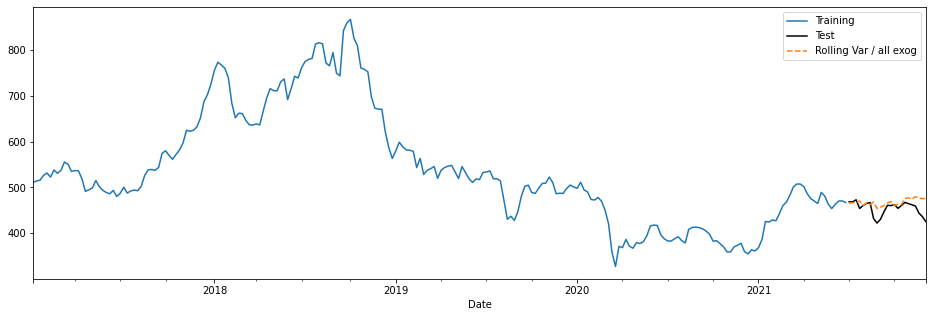

Test Error Metrics
MAE: 14.9596
MSE: 422.0461
MAPE: 0.0339
sMAPE: 0.0328
MASE: 19.834


In [ ]:
print("Rolling Var / all exog")
make_plot(y_train, y_test, pred_rolling_var_all, "Rolling Var / all exog")
metrics_rolling_var_all = calc_metrics(y_test, pred_rolling_var_all, return_dict=True)

#### only n225

In [ ]:
pred_rolling_var_n225 = rolling_var(exog_list=['n225'])

Rolling Var / n225


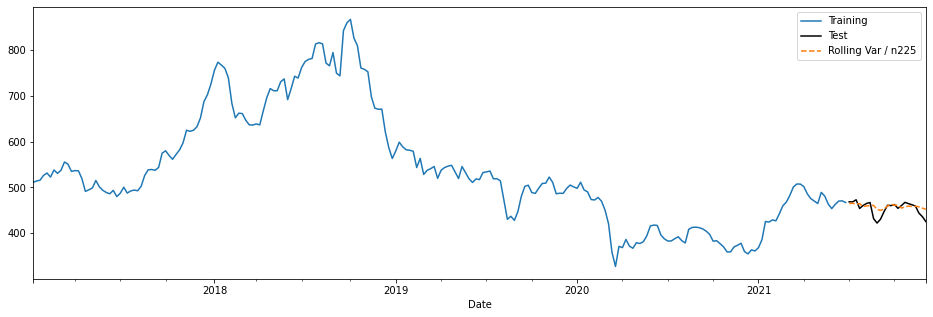

Test Error Metrics
MAE: 9.6287
MSE: 170.5378
MAPE: 0.0218
sMAPE: 0.0214
MASE: 12.766


In [ ]:
print("Rolling Var / n225")
make_plot(y_train, y_test, pred_rolling_var_n225, "Rolling Var / n225")
metrics_rolling_var_n225 = calc_metrics(y_test, pred_rolling_var_n225, return_dict=True)

#### oil & usdjpy

In [ ]:
pred_rolling_var_oilusdjpy = rolling_var(exog_list=['oil', 'usdjpy'])

Rolling Var / oil & usdjpy


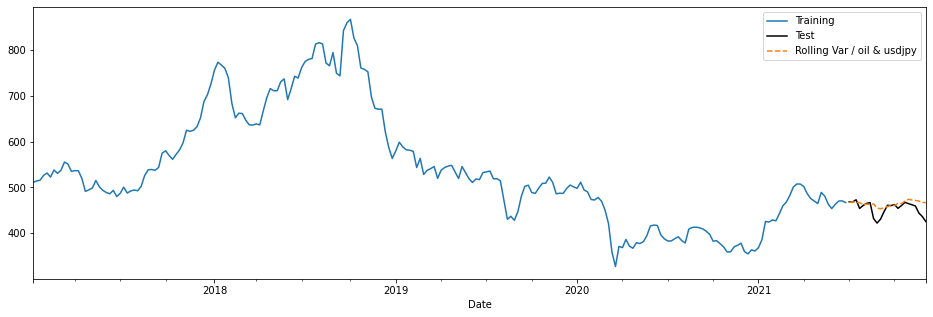

Test Error Metrics
MAE: 12.0597
MSE: 294.9881
MAPE: 0.0274
sMAPE: 0.0267
MASE: 15.9891


In [ ]:
print("Rolling Var / oil & usdjpy")
make_plot(y_train, y_test, pred_rolling_var_oilusdjpy, "Rolling Var / oil & usdjpy")
metrics_rolling_var_oilusdjpy = calc_metrics(y_test, pred_rolling_var_oilusdjpy, return_dict=True)

#### GDP & Unemp

In [ ]:
pred_rolling_var_gdpunemp = rolling_var(exog_list=['jp_gdp', 'jp_unemp'])

Rolling Var / GDP & Unemp


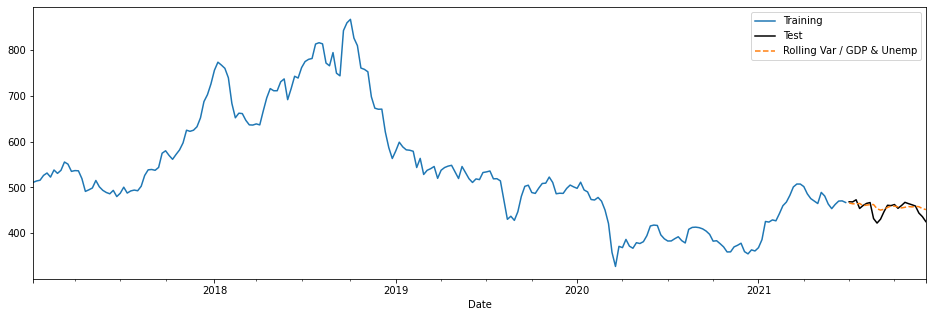

Test Error Metrics
MAE: 9.5726
MSE: 175.8181
MAPE: 0.0217
sMAPE: 0.0213
MASE: 12.6917


In [ ]:
print("Rolling Var / GDP & Unemp")
make_plot(y_train, y_test, pred_rolling_var_gdpunemp, "Rolling Var / GDP & Unemp")
metrics_rolling_var_gdpunemp = calc_metrics(y_test, pred_rolling_var_gdpunemp, return_dict=True)

### Rolling VAR2
- Use only last 52 observations as training
- Note: trying to find optimal p among 1 through 20 failed due to data points used for VAR is smaller. So I set 1 through 5 instead ([referrence](https://github.com/statsmodels/statsmodels/issues/3260)).

In [ ]:
# Library
from statsmodels.tsa.vector_ar.var_model import VAR

# Function to run VAR
def rolling_var2(exog_list, train_diff_raw=df_train_diff, test_diff_raw=df_test_diff, train_raw=df_train, verbose=False):
    """
    ***** Use only last 52 observations as training instead of whole training data *****
    Input:
        (1) exog_list: column names for external regressors
        (2) train_diff_raw: df_train_diff (differenced training data)
        (3) test_diff_raw: df for extracting index / exog for training
        (4) train_raw: df_train (non-differenced training data)
    Process:
        (1) Build model using VAR() with optimal order p in terms of AIC using whole differenced training data
        (2) Make one-step ahead prediction & Store predicted values
        (3) Add 1-step ahead true values into differenced training data and drop first observation from it
        (5) Repeat (1) through (3) over test data periods
    Outoput:
        - Prediction for Eneos (23-step ahead)
    """
    # Slice data by eneos and specified exog
    train_diff = train_diff_raw[["eneos"] + exog_list][-52:]
    test_diff = test_diff_raw[["eneos"] + exog_list]
    train = train_raw[["eneos"] + exog_list][-52:]

    # DF to store predicted values
    df_pred = pd.DataFrame(columns=train.columns)

    # Fit var model and make 1-step ahead prediction
    for i in range(test_diff.shape[0]):

        # Create instance
        var_model=VAR(train_diff)

        # Run VAR with different order (1-20)
        results_aic =[]
        for p in range(1,6):
            results = var_model.fit(p)
            results_aic.append(results.aic)

        # Store optimal p order
        optimal_p = list(np.arange(1,6,1))[np.argmin(results_aic)]

        # Refit var with optimal p
        best_var = var_model.fit(optimal_p)

        # Make 1-step ahead forecast
        yhat_var = best_var.forecast(var_model.endog, steps=1)

        # clean up yhat
        df_yhat_var = pd.DataFrame(yhat_var)
        df_yhat_var.index = [test_diff.index[i]]
        df_yhat_var.columns = test_diff.columns
 

        # Store df_yhat_var
        df_pred = df_pred.append(df_yhat_var)

        # Add actual 1-steap ahead actual test data into training set and drop 1st observation from training data
        train_diff = train_diff.append(test_diff.copy().iloc[i])[1:]
       
        # Print progress
        if verbose:
            print(f"Index {i + 1}")
            print("Optimal p with minimum AIC: ", optimal_p)
            print("One-step ahead forecast (differened data)")
            display(df_yhat_var)
    
    # Recover first order differencing
    df_pred_var = pd.concat([train.tail(1), df_pred], axis=0).cumsum()
    df_pred_var = df_pred_var[-23:]

    # Extract predictions for eneos
    y_pred_var = df_pred_var["eneos"]

    # Return prediction
    return y_pred_var

#### All external regressors

In [ ]:
pred_rolling_var_all2 = rolling_var2(exog_list=['jp_gdp', 'jp_unemp', 'oil', 'usdjpy', 'jp_i', 'n225'], verbose=True)

Index 1
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp      oil   usdjpy      jp_i  \
2021-07-04 -8.314044  1032.870871 -0.024384 -0.54334  0.36973 -0.016561   

                  n225  
2021-07-04 -197.944102

Index 2
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp      oil    usdjpy      jp_i  \
2021-07-11  13.773715  767.367637  0.166496  6.48703 -0.488471 -0.001586   

                  n225  
2021-07-11  1484.56999

Index 3
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-18  34.022276 -2003.867009  0.051157  3.874497  0.180855 -0.019495   

                  n225  
2021-07-18  692.113332

Index 4
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-07-25  13.704819  1232.097573 -0.011492 -4.396359 -0.035721 -0.025132   

                  n225  
2021-07-25 -243.306171

Index 5
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-01 -9.979757  2676.471064  0.130756  0.105056  0.668701  0.000527   

                 n225  
2021-08-01  460.34723

Index 6
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil   usdjpy      jp_i  \
2021-08-08 -13.51212  901.707149  0.051966 -1.730317  1.13102 -0.001993   

                 n225  
2021-08-08  43.375754

Index 7
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-15 -13.727547  4590.046158   0.12691 -1.019986 -1.050976  0.020383   

                  n225  
2021-08-15 -360.832896

Index 8
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-22  3.81321 -2514.132143 -0.057127  2.489032 -2.343505 -0.015342   

                  n225  
2021-08-22 -199.579536

Index 9
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-08-29 -24.016602  6414.83794  0.086795 -0.739135  0.482047 -0.068441   

                 n225  
2021-08-29 -512.76186

Index 10
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-05  17.115559  537.568207  0.006975  7.979582  0.349821  0.005611   

                   n225  
2021-09-05  2274.662849

Index 11
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-12 -10.198847 -2075.240077 -0.048603 -2.083864 -0.662296  0.017262   

                  n225  
2021-09-12 -575.768676

Index 12
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-19  9.770602  2109.146167  0.045889  1.082521  0.516407  0.020698   

                  n225  
2021-09-19  600.517591

Index 13
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-09-26 -13.924356 -121.961974 -0.035423  2.282769 -0.232916 -0.007618   

                  n225  
2021-09-26 -1345.55989

Index 14
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-03  34.107402 -2466.385345 -0.140396  4.307211  1.001937  0.010731   

                  n225  
2021-10-03  977.954973

Index 15
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-10  10.576827 -4474.261287 -0.168603  1.991815  1.174309 -0.010111   

                   n225  
2021-10-10  1361.117648

Index 16
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-17  2.898566 -3359.257614 -0.108837 -3.612282  1.579853 -0.034517   

                 n225  
2021-10-17 -315.72693

Index 17
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-10-24  18.073238  1446.265138  0.009273 -2.180989  0.572311  0.000718   

                 n225  
2021-10-24 -59.531563

Index 18
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy     jp_i  \
2021-10-31 -16.561538 -1990.81454  0.101579 -7.626686  1.106887 -0.00664   

                 n225  
2021-10-31  161.39252

Index 19
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-07  29.607473 -2719.392479 -0.115025  3.197274  1.370634  0.011837   

                   n225  
2021-11-07  1120.007327

Index 20
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil    usdjpy      jp_i  \
2021-11-14  16.558024  482.097909  0.004681  6.364389  1.439378  0.048759   

                   n225  
2021-11-14  2422.219235

Index 21
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos     jp_gdp  jp_unemp       oil    usdjpy     jp_i  \
2021-11-21 -16.262707 -684.00595 -0.006043 -3.499908 -1.380322 -0.03227   

                   n225  
2021-11-21 -1301.186927

Index 22
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos      jp_gdp  jp_unemp       oil   usdjpy      jp_i  \
2021-11-28  3.328882 -370.697842 -0.140702  0.426874 -0.57935 -0.020654   

                   n225  
2021-11-28 -1030.737425

Index 23
Optimal p with minimum AIC:  5
One-step ahead forecast (differened data)


eneos       jp_gdp  jp_unemp      oil    usdjpy      jp_i  \
2021-12-05 -21.840951 -2089.261937 -0.106138  1.60291 -0.987807 -0.023134   

                 n225  
2021-12-05 -63.743922

Rolling Var2 / all exog


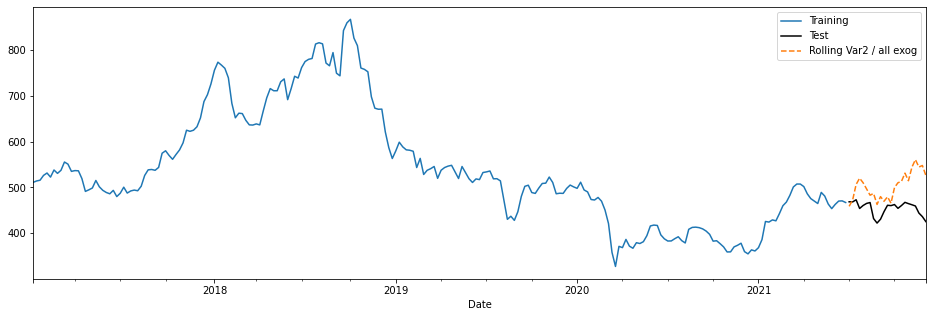

Test Error Metrics
MAE: 50.3905
MSE: 3522.3065
MAPE: 0.1121
sMAPE: 0.1041
MASE: 66.8095


In [ ]:
print("Rolling Var2 / all exog")
make_plot(y_train, y_test, pred_rolling_var_all2, "Rolling Var2 / all exog")
metrics_rolling_var_all2 = calc_metrics(y_test, pred_rolling_var_all2, return_dict=True)

#### only n225

In [ ]:
pred_rolling_var_n2252 = rolling_var2(exog_list=['n225'])

Rolling Var2 / n225


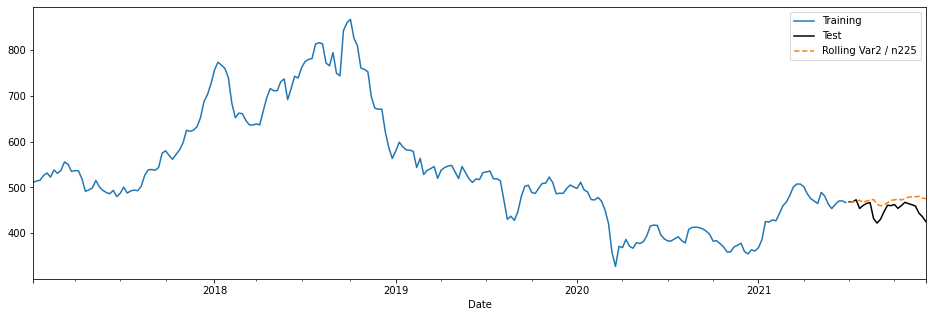

Test Error Metrics
MAE: 18.0353
MSE: 531.7428
MAPE: 0.0408
sMAPE: 0.0394
MASE: 23.9118


In [ ]:
print("Rolling Var2 / n225")
make_plot(y_train, y_test, pred_rolling_var_n2252, "Rolling Var2 / n225")
metrics_rolling_var_n2252 = calc_metrics(y_test, pred_rolling_var_n2252, return_dict=True)

#### oil & usdjpy

In [ ]:
pred_rolling_var_oilusdjpy2 = rolling_var2(exog_list=['oil', 'usdjpy'])

Rolling Var2 / oil & usdjpy


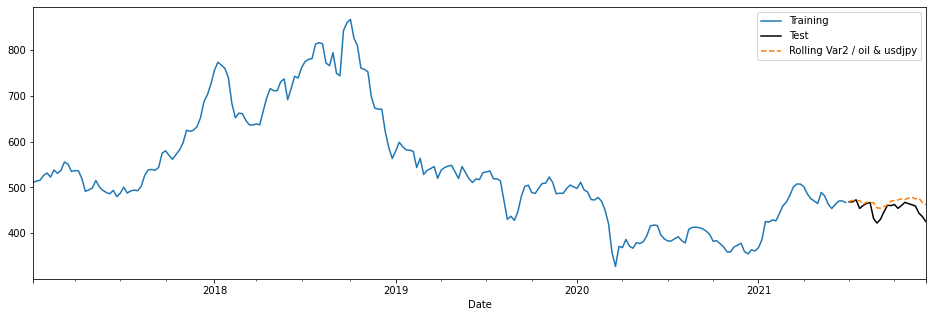

Test Error Metrics
MAE: 14.6472
MSE: 353.8647
MAPE: 0.0331
sMAPE: 0.0322
MASE: 19.4197


In [ ]:
print("Rolling Var2 / oil & usdjpy")
make_plot(y_train, y_test, pred_rolling_var_oilusdjpy2, "Rolling Var2 / oil & usdjpy")
metrics_rolling_var_oilusdjpy2 = calc_metrics(y_test, pred_rolling_var_oilusdjpy2, return_dict=True)

#### GDP & Unemp

In [ ]:
pred_rolling_var_gdpunemp2 = rolling_var2(exog_list=['jp_gdp', 'jp_unemp'])

Rolling Var2 / GDP & Unemp


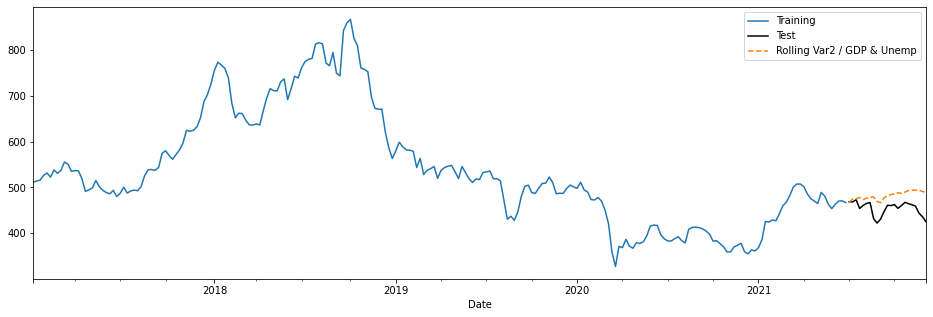

Test Error Metrics
MAE: 28.0494
MSE: 1056.3627
MAPE: 0.0629
sMAPE: 0.0603
MASE: 37.1889


In [ ]:
print("Rolling Var2 / GDP & Unemp")
make_plot(y_train, y_test, pred_rolling_var_gdpunemp2, "Rolling Var2 / GDP & Unemp")
metrics_rolling_var_gdpunemp2 = calc_metrics(y_test, pred_rolling_var_gdpunemp2, return_dict=True)

# Summarize results for rolling fit models

- Rolling fit model using only data from training periods (until 2021/6) doesn't improve predictions. As expected, rolling fit models using latest data avairable at each prediction point (for example, for predicting 2021-08-15 values, use data until 2021-08-08) seems better.
- Difference between (i) Rolling fit model that uses whole trainig periods and (ii) Rolling fit model that uses only 52 latest values seem small. But for Rolling ARIMA, (ii) performs better and for Rolling VAR, (i) performs btter.
- Thus, summarize rolling fit models for `Roplling Univariate ARIMA (4)`, `Rolling ARIMAX with External Regressors (4)`, and `Rolling VAR`
- In summary, Rolling ARIMA(X) performs better than VAR. Among rolling ARIMA, Rolling ARIMAX with Nikkei225 is the best. In general, multivariate models performs better than univariate model.

In [ ]:
# Store all predictions and metrics
weekly_rolling_pred = dict()
weekly_rolling_metrics = dict()

# Rolling Univariate ARIMA(4)
weekly_rolling_pred["Rolling ARIMA / No-exog"] = pred_airma_rolling_uni4
weekly_rolling_metrics["Rolling ARIMA / No-exog"] = metrics_airma_rolling_uni4

# Rolling ARIMAX with external regressors (4)
weekly_rolling_pred["Rolling ARIMAX / All"] = pred_rolling_arimax_all4
weekly_rolling_metrics["Rolling ARIMAX / All"] = metrics_rolling_arimax_all4

weekly_rolling_pred["Rolling ARIMAX / Nikkei225"] = pred_rolling_arimax_n2254
weekly_rolling_metrics["Rolling ARIMAX / Nikkei225"] = metrics_rolling_arimax_n2254

weekly_rolling_pred["Rolling ARIMAX / Oil & USDJPY"] = pred_rolling_arimax_oilusdjpy4
weekly_rolling_metrics["Rolling ARIMAX / Oil & USDJPY"] = metrics_rolling_arimax_oilusdjpy4

weekly_rolling_pred["Rolling ARIMAX / GDP & Unemp"] = pred_rolling_arimax_gdpunemp4
weekly_rolling_metrics["Rolling ARIMAX / GDP & Unemp"] = metrics_rolling_arimax_gdpunemp4

# Rolling VAR
weekly_rolling_pred["Rolling VAR / All"] = pred_rolling_var_all
weekly_rolling_metrics["Rolling VAR / All"] = metrics_rolling_var_all

weekly_rolling_pred["Rolling VAR / Nikkei225"] = pred_rolling_var_n225
weekly_rolling_metrics["Rolling VAR / Nikkei225"] = metrics_rolling_var_n225

weekly_rolling_pred["Rolling VAR / Oil & USDJPY"] = pred_rolling_var_oilusdjpy
weekly_rolling_metrics["Rolling VAR / Oil & USDJPY"] = metrics_rolling_var_oilusdjpy

weekly_rolling_pred["Rolling VAR / GDP & Unemp"] = pred_rolling_var_gdpunemp
weekly_rolling_metrics["Rolling VAR / GDP & Unemp"] = metrics_rolling_var_gdpunemp

In [ ]:
pd.DataFrame(weekly_rolling_metrics).T

MAE       MSE    MAPE   sMAPE     MASE
Rolling ARIMA / No-exog         8.2791  127.8672  0.0185  0.0184  10.9768
Rolling ARIMAX / All            7.7303  131.0375  0.0174  0.0171  10.2491
Rolling ARIMAX / Nikkei225      7.4110  127.3857  0.0166  0.0164   9.8258
Rolling ARIMAX / Oil & USDJPY   8.2142  127.4794  0.0185  0.0182  10.8906
Rolling ARIMAX / GDP & Unemp    8.0840  123.1674  0.0181  0.0179  10.7180
Rolling VAR / All              14.9596  422.0461  0.0339  0.0328  19.8340
Rolling VAR / Nikkei225         9.6287  170.5378  0.0218  0.0214  12.7660
Rolling VAR / Oil & USDJPY     12.0597  294.9881  0.0274  0.0267  15.9891
Rolling VAR / GDP & Unemp       9.5726  175.8181  0.0217  0.0213  12.6917

In [ ]:
pd.DataFrame(weekly_rolling_metrics).T.sort_values("sMAPE")

MAE       MSE    MAPE   sMAPE     MASE
Rolling ARIMAX / Nikkei225      7.4110  127.3857  0.0166  0.0164   9.8258
Rolling ARIMAX / All            7.7303  131.0375  0.0174  0.0171  10.2491
Rolling ARIMAX / GDP & Unemp    8.0840  123.1674  0.0181  0.0179  10.7180
Rolling ARIMAX / Oil & USDJPY   8.2142  127.4794  0.0185  0.0182  10.8906
Rolling ARIMA / No-exog         8.2791  127.8672  0.0185  0.0184  10.9768
Rolling VAR / GDP & Unemp       9.5726  175.8181  0.0217  0.0213  12.6917
Rolling VAR / Nikkei225         9.6287  170.5378  0.0218  0.0214  12.7660
Rolling VAR / Oil & USDJPY     12.0597  294.9881  0.0274  0.0267  15.9891
Rolling VAR / All              14.9596  422.0461  0.0339  0.0328  19.8340

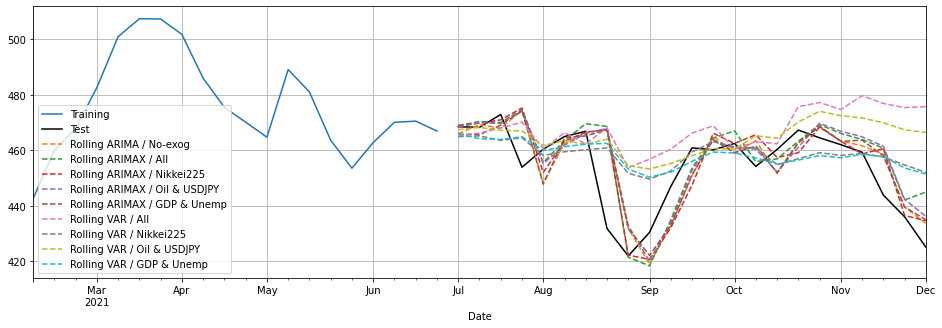

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
y_train[-20:].plot(ax=ax, label="Training")
y_test.plot(ax=ax, label="Test", color="black")
for model in weekly_rolling_pred.keys():
    weekly_rolling_pred[model].plot(ax=ax, label=model, linestyle="dashed")
plt.legend()
plt.grid()
plt.show()

# Summarize result for daily data
- ARIMAX(1,1,1) with oil price & nikkei225 index seems the best.
- VAR(2) and Prophet less fitted
- Since in actual setting, we cannot know future values for oil price and nikkei 225 index, we need to add some more modification on the prediction.
- Also, one-year forecast might not make sense (too long). Need to use same horizon.

# Summarize result for weekly analysis

- So far, we built models using ARIMA, VAR, and Prophet to predict "TOYKO GAS" stock price (weekly average for daily close price) in latter half of 2021 (training data is from 2017-01 to 2021-06). Also, we used the following as external regressors.
    - Nikkei 225 Index
    - Oil price
    - Exchange rate (USD/JPY)
    - GDP
    - Unemployment Rate
    - Long-term interest rate

- Based on sMAPE criteria, VAR(1) using TOYKO GAS price and Nikkei 225 index performs best for test data. Also, other VAR models seem to perform better than ARIMA and Prophet.
- When comparing univariate and multivariate models for ARIMA and Prophet, univariate models relatively perform better than multivariate models, even though they use future actual values for external regoressors. This is possibly because Nikkei 225 Index, Oil price, and USDJPY rate continuously increased during test set period (latter half of 2021), while Toyko Gas stock price continuously decreased for the same periods.